# Setup

Install in R:
```
install.packages("BiocManager")
BiocManager::install(c("edgeR", "BiocParallel", "RhpcBLASctl"))
```

Install

```pip install toytree ete4 pybiomart```

## Options & Data

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy

# Display/Environment Settings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings("ignore", message=".*ast.Ellipsis is deprecated.*")
config.PANDAS_BACKEND = True
warnings.filterwarnings("ignore", message=".*vert.*will be deprecated.*")
pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)
warnings.filterwarnings(
    "ignore", message="Bitwise inversion '~' on bool is deprecated",
    category=DeprecationWarning)

# Process Options
ncpus = os.cpu_count() - 1
overwrite = True

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "analyze_senescence_celltype"
                        "_specific_threshold.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_scanvi"
# col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"
# use_hierarchy = False
collapse_neurons = True  # collapse neuron categories?

# Metadata Information
species = "Mouse"
col_sample, col_batch = "sample", "Group"
# col_age = "Characteristics[Age at Euthanasia]"
# col_condition = "Factor Value[Spaceflight]"
col_age = "Age_End"
col_condition = "Condition"
# group_order = ["Ground Control | 12 Weeks", "Ground Control | 29 Weeks",
#                "Space Flight | 12 Weeks", "Space Flight | 29 Weeks"]
group_order = ["Ground Control | 20 Weeks", "Ground Control | 37 Weeks",
               "Space Flight | 20 Weeks", "Space Flight | 37 Weeks"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        col_age: dict(key_control="20 Weeks",
                      key_treatment="37 Weeks"),
        # col_age: dict(key_control="12 Weeks",
        #               key_treatment="29 Weeks"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1:])}
palette = {col_condition: {keys[col_condition]["key_control"]: "b",
                           keys[col_condition]["key_treatment"]: "r"},
           col_age: {keys[col_age]["key_control"]: "g",
                     keys[col_age]["key_treatment"]: "y"},
           col_batch: dict(zip(group_order, ["c", "b", "tab:pink", "r"]))}

# Scoring Metrics
sen_metrics = ["senmayo"]
# sen_metrics = ["senepy", "senmayo"]
use_metric = "senmayo"
percentile = 1

# Regress Out Confounders?
vars_regress_out = ["Time"]

# File Input & Output
file_path = "data/OSD-613_integrated.h5ad"
file_path_new = os.path.splitext(file_path)[0] + "_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.obs.loc[:, "Aged"] = (self.rna.obs[col_age] == keys[
    col_age]["key_treatment"]).astype(int)  # 1 vs. 0 older
self.rna.X = self.rna.layers["log1p"].copy()
self.rna.raw = None

# Hierarchical
keys_cts = {"Neurons": ["Excitatory", "Inhibitory",
                        "Excitatory-Inhibitory", "Neuron"],
            "Macroglia": ["Oligodendrocyte", "OPC", "Astrocyte"],
            "Microglia": ["Microglial"],
            "Endothelial Cell": ["Endothelial"]}
key_cts = dict(pd.concat([pd.Series(dict(([(i, x) for i in keys_cts[
    x]]))) for x in keys_cts]))
if collapse_neurons is True:
    self.rna.obs.loc[:, f"{col_celltype}_collapsed"] = self.rna.obs[
        col_celltype].replace(dict(zip(keys_cts["Neurons"], ["Neurons"]*3)))
    col_celltype = f"{col_celltype}_collapsed"
    self.col_celltype = col_celltype
self.rna.obs.loc[:, f"{col_celltype}_hierarchy"] = self.rna.obs[
    col_celltype].replace(key_cts)

# Display Object
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/senepy/load_hubs.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(


AnnData object with n_obs × n_vars = 103274 × 12097
    obs: 'Group', 'sample', 'Sample Number', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Characteristics[Feeding Schedule]', 'Characteristics[Age at Euthanasia]', 'Unit.1', 'Term Source REF.7', 'Term Accession Number.7', 'Protocol REF', 'Parameter Value[habitat]', 'Parameter Value[Enrichment material]', 'Parameter Value[duration]', 'Unit.2', 'Term Source REF.8', 'Term Accession Number.8', 'Parame

Group                       sample Sample Number Characteristics[Organism] Term Source REF                                 Term Accession Number Characteristics[Strain] Term Source REF.1               Term Accession Number.1  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4    HGC-ISS-04              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
AAACAGCCAGCACCAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4    HGC-ISS-04              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
AAACAGCCAGGTTCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4    HGC-ISS-04              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
AAACAGCCATCAATCG-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4    HGC-ISS-04              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
AAACAGCCATGTCAAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4    HGC-ISS-04              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
...                                                                   ...                          ...           ...                       ...             ...                                                   ...                     ...               ...                                   ...   
TTTGTGTTCCCTGATC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5     FL-ISS-05              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
TTTGTGTTCCGTAAAC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5     FL-ISS-05              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
TTTGTGTTCTGTGCAG-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5     FL-ISS-05              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
TTTGTTGGTGTTAGCA-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5     FL-ISS-05              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   
TTTGTTGGTTAAGTGT-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5     FL-ISS-05              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON/10090             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093   

                                               Characteristics[Genotype] Term Source REF.2                     Term Accession Number.2 Characteristics[Animal Source] Characteristics[Sex] Term Source REF.3                            Term Accession Number.3 Factor Value[Spaceflight]  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4                  Wild Type              NCIT  http://purl.obolibrary.org/obo/NCIT_C62195            Taconic Biosciences               Female              MESH  http://purl.bioontology.

## Data Descriptives

In [2]:
%matplotlib inline

# Detect Metadata Columns in AnnData Object
metadata_cols = self.rna.obs.groupby(col_sample).apply(
    lambda x: list(x.columns[np.where(
        x.apply(lambda y: len(y.unique()) ==  1))[0]]))
metadata_cols = [x for x in metadata_cols.explode().unique() if all((
    x in metadata_cols.loc[i] for i in metadata_cols.index.values))]

# Value Counts for Categorical Variables
metadata_cols_category = self.rna.obs[metadata_cols].dtypes[((
    self.rna.obs[metadata_cols].dtypes == "category") | (self.rna.obs[
        metadata_cols].apply(lambda x: len(x.unique()) < 6))) & (self.rna.obs[
            metadata_cols].apply(lambda x: len(x.unique()) > 1))].index
for x in metadata_cols_category:
    print(x, "\n\n", self.rna.obs[x].value_counts(), "\n\n")
    if col_batch is not None:  # by batch
        if x != col_batch:
            print(x, "\n\n", self.rna.obs[[x, col_batch]].groupby(
                col_batch).value_counts(), "\n\n")

# Descriptives for Continuous Variables
print(self.rna.obs[self.rna.obs.columns.difference(
    metadata_cols_category)].describe())
if col_batch is not None:  # by batch
    print(self.rna.obs[list(self.rna.obs.columns.difference(
        metadata_cols_category)) + [col_batch]].groupby(col_batch).describe())

# Cells per Cluster
perc_clusters = round(100 * self.rna.obs.groupby(col_sample).value_counts(
    [col_celltype], normalize=True).unstack(1), 2)
print(f"\n\n*** Cell Composition (%) ***\n\n{perc_clusters}")

# Number of Cells
n_cells = self.rna.obs.groupby(col_sample).apply(
    lambda x: x.n_cells_original_sample.unique()[0],
    include_groups=False).to_frame("Original Cell N").join(
        self.rna.obs.groupby(col_sample).apply(
            lambda x: x.shape[0], include_groups=False).to_frame("N Cells"))
n_cells.loc[:, "Percent_Filtered"] = round(100 * (1 - n_cells[
    "N Cells"] / n_cells["Original Cell N"]), 2)
print("\n\n", n_cells.sort_values("Percent_Filtered"))

/tmp/ipykernel_919320/1416146960.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_cols = self.rna.obs.groupby(col_sample).apply(


Group 

 Group
Ground Control | 37 Weeks    35362
Ground Control | 20 Weeks    31600
Space Flight | 37 Weeks      19904
Space Flight | 20 Weeks      16408
Name: count, dtype: int64 


sample 

 sample
RRRM2_BRN_GC_ISS-T_OLD_GO16     18386
RRRM2_BRN_GC_ISS-T_YNG_GY2       9651
RRRM2_BRN_GC_ISS-T_YNG_GY4       7547
RRRM2_BRN_GC_ISS-T_OLD_GO19      7539
RRRM2_BRN_GC_ISS-T_OLD_GO18      5842
RRRM2_BRN_FLT_ISS-T_OLD_FO19     5747
RRRM2_BRN_GC_ISS-T_YNG_GY9       5465
RRRM2_BRN_GC_ISS-T_YNG_GY7       5265
RRRM2_BRN_FLT_ISS-T_YNG_FY8      5095
RRRM2_BRN_FLT_ISS-T_OLD_FO20     4922
RRRM2_BRN_FLT_ISS-T_OLD_FO16     4050
RRRM2_BRN_FLT_ISS-T_YNG_FY5      3914
RRRM2_BRN_FLT_ISS-T_OLD_FO14     3864
RRRM2_BRN_FLT_ISS-T_YNG_FY2      3730
RRRM2_BRN_GC_ISS-T_YNG_GY1       3672
RRRM2_BRN_FLT_ISS-T_YNG_FY7      3669
RRRM2_BRN_GC_ISS-T_OLD_GO13      3595
RRRM2_BRN_FLT_ISS-T_OLD_FO17     1321
Name: count, dtype: int64 


sample 

 Group                      sample                      
Ground Control | 20 

## Get Marker Gene Sets

From Google Drive, except senmayo derived from file downloaded from
https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SAUL_SEN_MAYO.html
then created using:

```
from pybiomart import Server

senmayo = pd.read_csv("resources/SAUL_SEN_MAYO.v2025.1.Hs.tsv",
                      sep="\t", header=0)
senmayo = senmayo[senmayo.STANDARD_NAME == "GENE_SYMBOLS"]
senmayo = pd.Series({"Senmayo": senmayo.iloc[0, 1].split(
    ",")}, name="symbol").rename_axis("Gene_Set").explode().str.strip(
        ).replace("", np.nan).dropna().to_frame()
server = Server(host="http://www.ensembl.org")
mart = server.marts["ENSEMBL_MART_ENSEMBL"] # Access the Ensembl mart
human_dataset = mart.datasets["hsapiens_gene_ensembl"]
orthologs = human_dataset.query(attributes=[
    "external_gene_name", "mmusculus_homolog_associated_gene_name"])
orthologs = orthologs.dropna().set_index(orthologs.columns[0])
orthologs = orthologs.loc[orthologs.index.intersection(
    senmayo.symbol.to_list())].iloc[:, 0]
print(f"{orthologs.shape[0]} orthologs found out of"
      f" {len(senmayo.symbol.unique())} senmayo genes")
senmayo = senmayo.assign(symbol=senmayo.replace({"symbol": dict(zip(
    orthologs.index, orthologs.values))}))
senmayo.to_csv("gene_sets/senmayo.csv")
```

(Also could use `scflow.tl.convert_gene_species(senmayo.symbol.to_list())`)

Certain gene sets created from Google Drive ADBR AWG > Projects > White Matter > Gene Sets files (with the suffix = "_adjusted") were modified for consistency, e.g.,

```
pd.read_csv("gene_sets/_iron_genes_gmt_out.csv", index_col=[
    0, 1]).rename_axis(["row_id", "pathway"]).stack().to_frame(
        "symbol").reset_index(-1, drop=True).reset_index().to_csv(
            "gene_sets/_iron_genes_gmt_out_adjusted.csv")
```


### *A Priori*

In [3]:
mks = [pd.read_csv(os.path.join("gene_sets", i)).dropna(
    how="all", axis=1).assign(Source_File=i) for i in os.listdir("gene_sets")]
mks = [x.assign(Gene_Set=x["Source_File"].iloc[0].split("_2025")[0]) if (
    "pathway" in x) else x for x in mks]
mks = pd.concat(mks).drop("Unnamed: 0", axis=1).drop("row_id", axis=1)
mks = mks[mks.symbol.isin(self.rna.var_names)]
mks = mks[["Gene_Set", "symbol"]].set_index("Gene_Set").groupby(
    "Gene_Set").apply(lambda x: x["symbol"].to_list())
marker_genes_dict = dict(mks)
marker_gene_sets = mks.copy()
print(marker_gene_sets)

Gene_Set
GOBP_CELLULAR_RESPONSE_TO_IRON_ION                                                                                                                                                                                                                          [B2m, Bmp6, Gpld1, Ireb2, Tfrc, Trf]
GOBP_CENTRAL_NERVOUS_SYSTEM_MYELIN_FORMATION                                                                                                                                                                                                      [Abca2, Ckap5, Cntn1, Ercc2, Mag, Mios, Tenm4]
GOBP_INTRACELLULAR_IRON_ION_HOMEOSTASIS                                                                                                                                                      [Abcb7, Aco1, Atp13a2, Atp6ap1, Atp6v0a2, Atp6v0d1, Atp6v1a, Atp6v1g1, B2m, Bmp6, Bmyc, Bola2, C...
GOBP_IRON_COORDINATION_ENTITY_TRANSPORT                                                                                     

### Clusters in Data

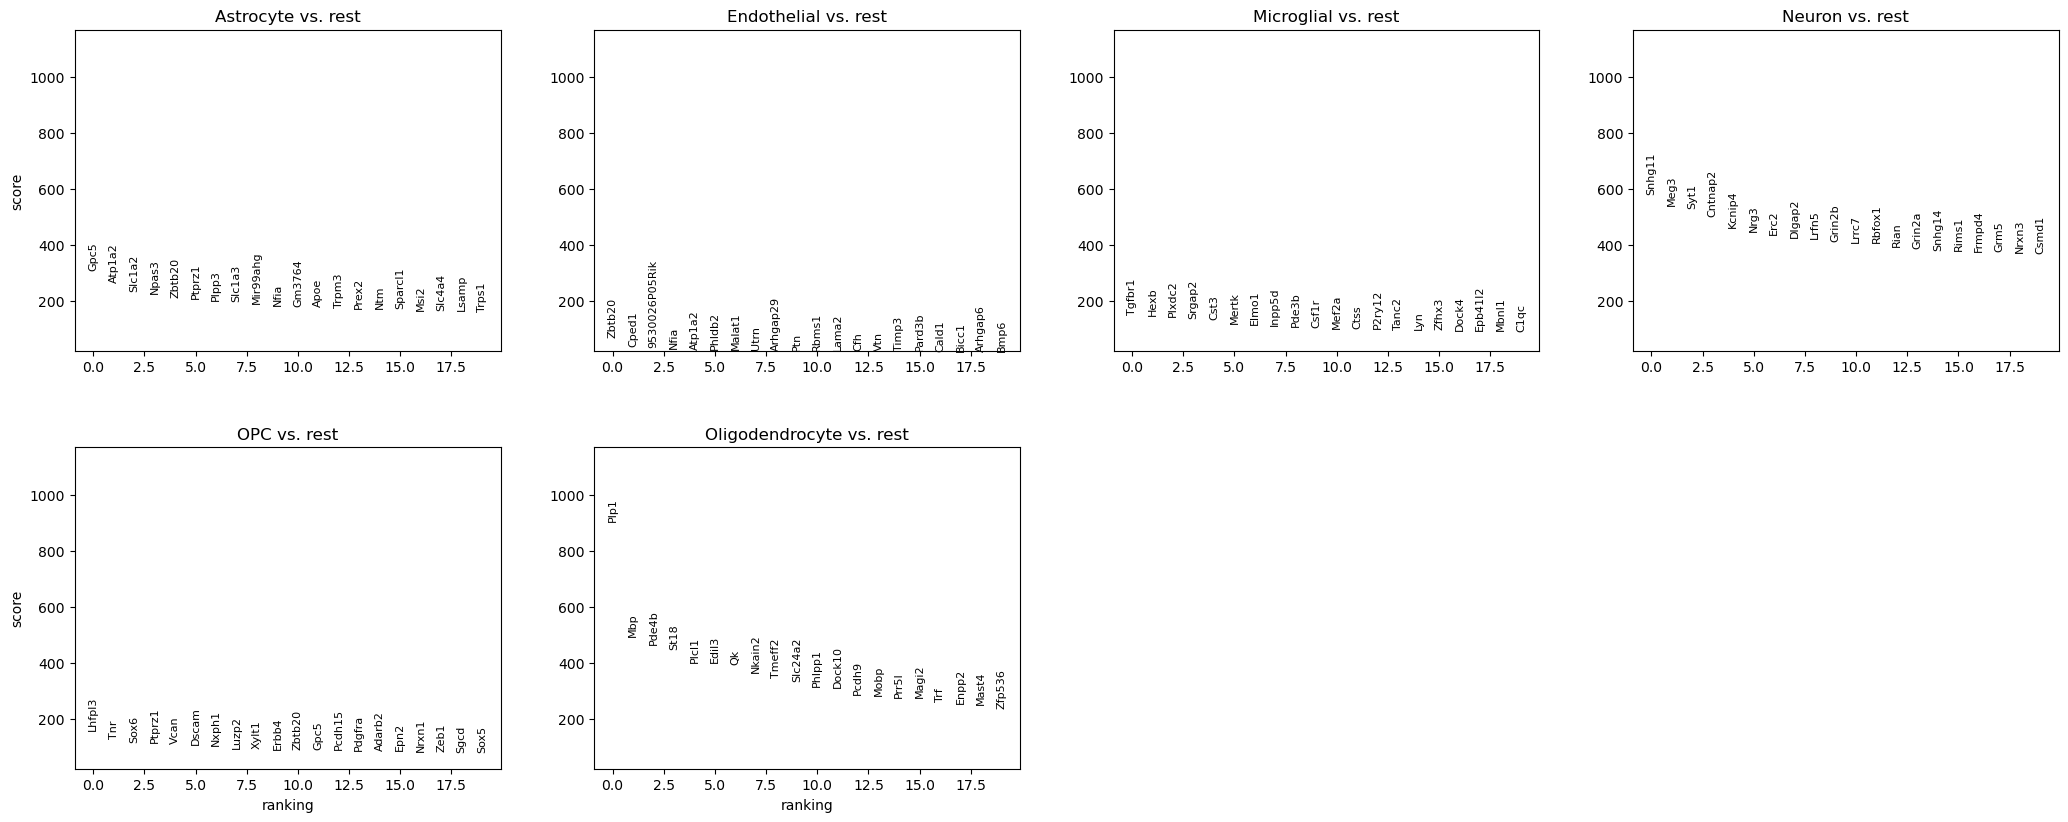

scores  logfoldchanges          pvals      pvals_adj
annotation_scanvi_collapsed annotation_scanvi_collapsed names                                                                  
Astrocyte                   Astrocyte                   Bcl2            48.966312        2.244818   0.000000e+00   0.000000e+00
                                                        Abhd3           47.107872        3.003248   0.000000e+00   0.000000e+00
                                                        Ugp2            47.243469        2.251395   0.000000e+00   0.000000e+00
Endothelial                 Endothelial                 Zbtb20          71.523643        3.209239   0.000000e+00   0.000000e+00
                                                        Cped1           37.842743        7.205899  3.891507e-186  6.621035e-185
                                                        9530026P05Rik   34.913925        5.121674  7.849119e-168  1.249353e-166
Microglial                  Microglial                  Tgfbr1         151.537048        7.483766   0.000000e+00   0.000000e+00
                                                        Hexb           150.142044        5.966863   0.000000e+00   0.000000e+00
                                                        Plxdc2         145.446838        4.734621   0.000000e+00   0.000000e+00
Neuron                      Neuron                      Pde7a           56.121979        1.154942   0.000000e+00   0.000000e+00
                                                        Chic1           55.948746        1.314887   0.000000e+00   0.000000e+00
                                                        Pkig            55.969212        1.236063   0.000000e+00   0.000000e+00
OPC                         OPC                         Lhfpl3         161.057190        5.147624   0.000000e+00   0.000000e+00
                                                        Tnr            131.139984        4.126481   0.000000e+00   0.000000e+00
                                                        Sox6           118.223061        5.241720   0.000000e+00   0.000000e+00
Oligodendrocyte             Oligodendrocyte             Map4k5          52.164612        1.264680   0.000000e+00   0.000000e+00
                                                        Dleu2           54.534840        1.288954   0.000000e+00   0.000000e+00
                                                        E130308A19Rik   54.438168        1.582712   0.000000e+00   0.000000e+00

In [4]:
self.find_markers(col_celltype=col_celltype)
df_celltype_markers = self.get_markers_df(
    n_genes=50, col_celltype=col_celltype,
    log2fc_threshold=1, p_threshold=1e-10)
df_celltype_markers.groupby(col_celltype).apply(lambda x: x.head(3))

# Regress Out?

In [5]:
# if vars_regress_out is not None:
#     self.rna.X = self.rna.layers["log1p"].copy()
#     sc.pp.regress_out(self.rna, vars_regress_out)
#     self.rna.layers["log1p"] = self.rna.X.copy()
#     pkg.pp.scale(self.rna, zero_center=True, max_value=10)
#     self.rna.layers["scaled"] = self.rna.X.copy()
#     self.rna.X = self.rna.layers["log1p"].copy()

# Score Senescence

## Run Scoring

If you want just to find the senescence-related genes, run:

```
tissue = "Brain"  # or whatever you want here
celltype = None  # or whatever you want here
genes_senepy, hubs, figs = find_senescence_genes(
    self.rna, species=species, tissue=tissue, celltype=celltype,
    overlap_threshold=0, literature_sources=None,
    sengpt_sources=True, plot=True, col_celltype=col_celltype
)  # find tissue- and/or cell type-specific genes
```

To see available hubs:

```
hubs = senepy.load_hubs(species=species)
hubs.metadata.set_index(["tissue", "cell"]).sort_index()
```

Other examples of arguments you could use:

```
# tissue = ["Brain", "Myeloid"]
# tissue = None

# celltype = "GABA interneuron"  # only human I think
# celltype = ["microglia", "t cell", "monocyte"]
# celltype = "microglia"
# celltype = "microglial cell"`

### Senepy

In [6]:
%%time

tissue = "Brain"
celltype = None  # use all cell types

if "senepy" in sen_metrics:
    self.rna.X = self.rna.layers["log1p"].copy()
    self.rna, genes_senepy, figs = run_senepy(
        self.rna, species=species, tissue=tissue, celltype=celltype,
        overlap_threshold=0, literature_sources=None,
        sengpt_sources=True, col_celltype=col_celltype,
        col_senscore="score_senepy", identifiers=[col_celltype],
        use_translator=True, plot=True, figsize=(20, 20),
        swap_axes=False, standard_scale="group", plot_layer="log1p"
    )  # find tissue- and/or cell type-specific genes
    self.rna.obs.loc[
        :, "score_senepy_original_scale"] = self.rna.obs.score_senepy
    self.rna.obs.loc[:, "score_senepy"] = np.log(
        self.rna.obs.score_senepy)  # log-transform senescence score
    self.rna.obs[["score_senepy"]]

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.72 μs


### Senmayo

In [7]:
if "senmayo" in sen_metrics:
    sc.tl.score_genes(self.rna, marker_gene_sets.loc["Senmayo"],
                      ctrl_as_ref=True, ctrl_size=50, gene_pool=None,
                      n_bins=25, score_name="score_senmayo", random_state=0,
                      copy=False, layer="log1p", use_raw=False)

## Label SnCs

### Define Snc Threshold & Label Cells

Based on percentile threshold derived from control group

In [8]:
# Determine Threshold
perc_s, perc = str(100 - percentile) + "%", 1 - (percentile / 100)
p_h = 3
perc_s_h, perc_h = str(100 - p_h) + "%", 1 - (p_h / 100)
print("Percentile for Threshold:", perc_s)
for u in sen_metrics:
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc])[perc_s], include_groups=False).to_frame(
                    f"Senescence_Threshold_{u}"), on=col_celltype).loc[
                        self.rna.obs.index]
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc_h])[perc_s_h],
                                include_groups=False).to_frame(
                                    f"Senescence_Threshold_{u}_{p_h}"),
                                on=col_celltype).loc[self.rna.obs.index]

# Binary CLassification
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_{x}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}"])
    self.rna.obs.loc[:, f"Senescent_Cell_{x}_{p_h}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}_{p_h}"])

# String Labels (for Plotting/Categorical Analysis)
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_{x}_{p_h}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_by_Type_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype].astype(str)
    self.rna.obs.loc[:, f"SnC_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype + "_hierarchy"].astype(str)

# Descriptives
for x in sen_metrics:
    print(x, round(self.rna.obs[[
        f"Senescent_Cell_Label_{x}", col_celltype]].value_counts(
            normalize=True).sort_index() * 100, 1).unstack(0))

# Choose Metrics for Main Analysis
for x in ["Senescent_Cell_Label", "Senescent_Cell", "SnC_hierarchy",
            "Senescence_Threshold", "Senescent_Cell_Label_by_Type"]:
    self.rna.obs.loc[:, x] = self.rna.obs[f"{x}_{use_metric}"]
self.rna.obs.loc[:, "senscore"] = self.rna.obs[f"score_{use_metric}"]
self.rna.obs.loc[
    :, f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_Label_{use_metric}_{p_h}"].replace({
            "Non-Senescent": "", "Senescent": "SnC "}).astype(
                str) + self.rna.obs[
                    col_celltype].astype(str)  # lower threshold SnC by type
genes = marker_gene_sets.loc["Senmayo"] if (
    use_metric == "senmayo") else genes_senepy  # main senescence gene list

# Avoid Nesting Duplication Issues
self.rna.obs.loc[:, "SnC_hierarchy"] = self.rna.obs[
    "SnC_hierarchy"].replace({
        "Neuron": "Neurons", "SnC Neuron": "SnC Neurons"})

Percentile for Threshold: 99%
senmayo Senescent_Cell_Label_senmayo  Non-Senescent  Senescent
annotation_scanvi_collapsed                           
Astrocyte                               6.8        0.1
Endothelial                             0.8        0.0
Microglial                              3.2        0.1
Neuron                                 65.9        1.5
OPC                                     3.4        0.0
Oligodendrocyte                        17.9        0.2


### Label Batch/Cell-Specific Senescence Percentiles

In [9]:
# for x in ["Senescence_Label", "Senescence_CellType"]:
#     if x in self.rna.obs:
#         self.rna.obs = self.rna.obs.drop(x, axis=1)

# # %ile Thresholds (Overall)
# thresh = self.rna.obs["score_senepy"].describe(
#     percentiles=[0.90, 0.95, 0.99])
# thres_ct =  self.rna.obs[["score_senepy", col_celltype]].groupby(
#     col_celltype).describe(percentiles=[0.90, 0.95, 0.99])["score_senepy"]

# sen = self.rna.obs["score_senepy"].apply(
#     lambda x: "Top 1%" if x >= float(thresh.loc["99%"]) else "Top 5%" if (
#         x >= float(thresh.loc["95%"])) else "Top 10%" if x >= float(
#             thresh.loc["90%"]) else "Bottom 90%").to_frame(
#                 "Senescence_Label").loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sen).loc[self.rna.obs.index]

# # %ile Thresholds (by Cell Type)
# sct = self.rna.obs.groupby(
#     col_celltype).apply(lambda g: g["score_senepy"].apply(
#         lambda x: f"Top 1% {g.name}" if x >= float(thres_ct.loc[g.name][
#             "99%"]) else f"Top 5% {g.name}" if (x >= float(thres_ct.loc[
#                 g.name]["95%"])) else f"Top 10% {g.name}" if x >= float(
#                     thres_ct.loc[g.name]["90%"]) else g.name),
#                         include_groups=False)

# sct = sct.to_frame("Senescence_CellType").reset_index(0, drop=True)
# sct = sct.loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sct).loc[self.rna.obs.index]

# for x in ["Senescence_Label", "Senescence_CellType"]:
#     self.rna.obs = self.rna.obs.assign(**{
#         x: self.rna.obs[x].astype("category")})

# high_sen_cts = [i for i in self.rna.obs["Senescence_CellType"].unique(
#     ) if " 1% " in i]

### Descriptives of SnCs

Percent Senescent: 

 annotation_scanvi_collapsed               Astrocyte  Endothelial  Microglial  Neuron    OPC  Oligodendrocyte
Group                     Senescent_Cell                                                                    
Ground Control | 20 Weeks 0                   98.96        98.82       98.96   98.99  98.97            99.00
                          1                    1.04         1.18        1.04    1.01   1.03             1.00
Ground Control | 37 Weeks 0                   98.41        96.59       97.73   97.23  98.92            99.01
                          1                    1.59         3.41        2.27    2.77   1.08             0.99
Space Flight | 20 Weeks   0                   98.22       100.00       97.90   98.18  98.59            98.33
                          1                    1.78          NaN        2.10    1.82   1.41             1.67
Space Flight | 37 Weeks   0                   96.87        97.78       97.60   96.63  97.71            98.

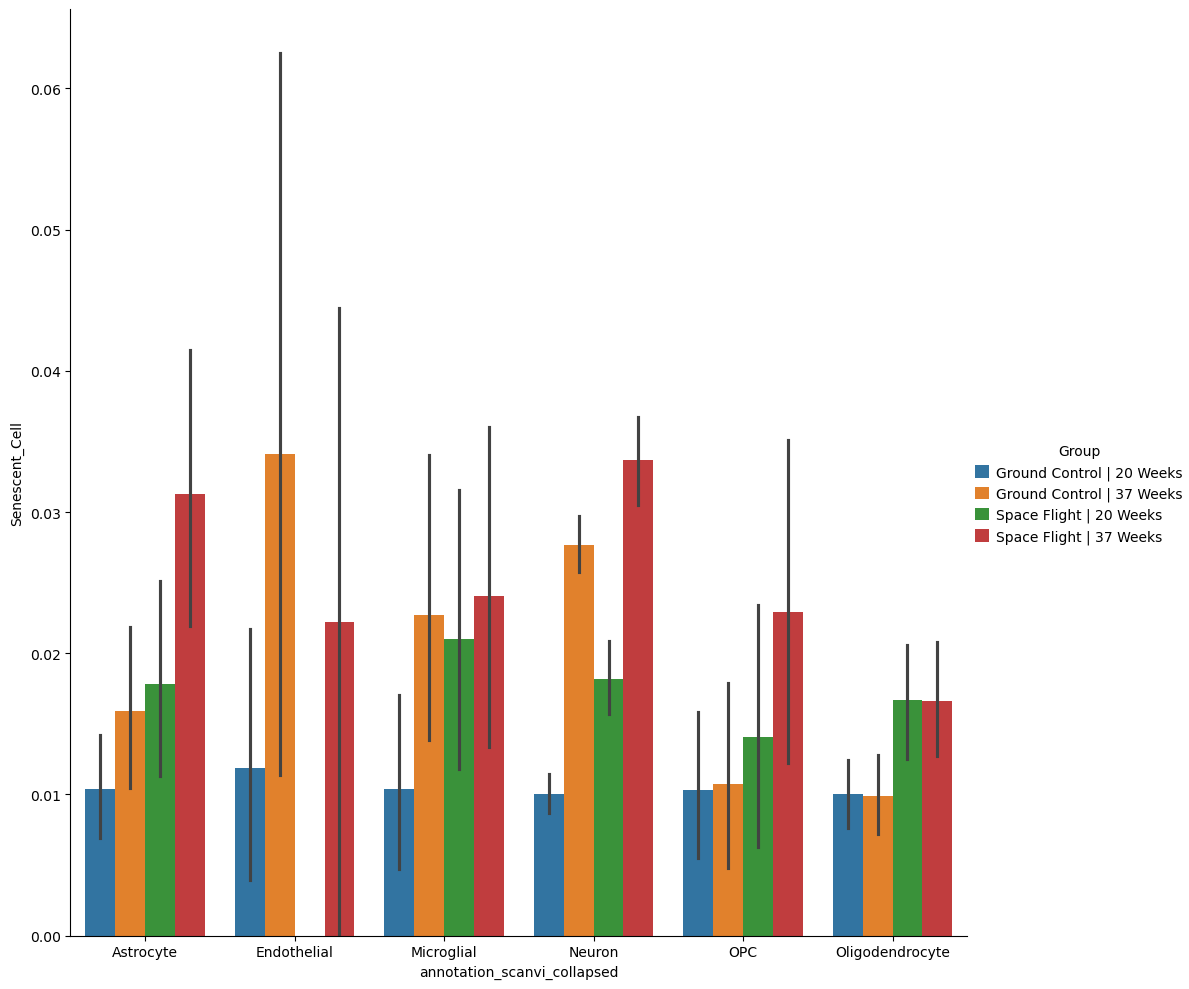

In [10]:
print("Percent Senescent: \n\n", round(self.rna.obs.groupby([
    col_celltype, col_batch]).apply(lambda x: x["Senescent_Cell"].astype(
        int).value_counts(normalize=True), include_groups=False) * 100,
    2).unstack(col_celltype))
sns.catplot(self.rna.obs, y="Senescent_Cell", x=col_celltype,
            hue=col_batch, kind="bar", height=10)

# SnC DEGs

## Overall

... storing 'Senescent_Cell_Label_senmayo' as categorical
... storing 'Senescent_Cell_Label_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label_senmayo_3' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo' as categorical
... storing 'SnC_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label' as categorical
... storing 'SnC_hierarchy' as categorical
... storing 'Senescent_Cell_Label_by_Type' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo_3' as categorical


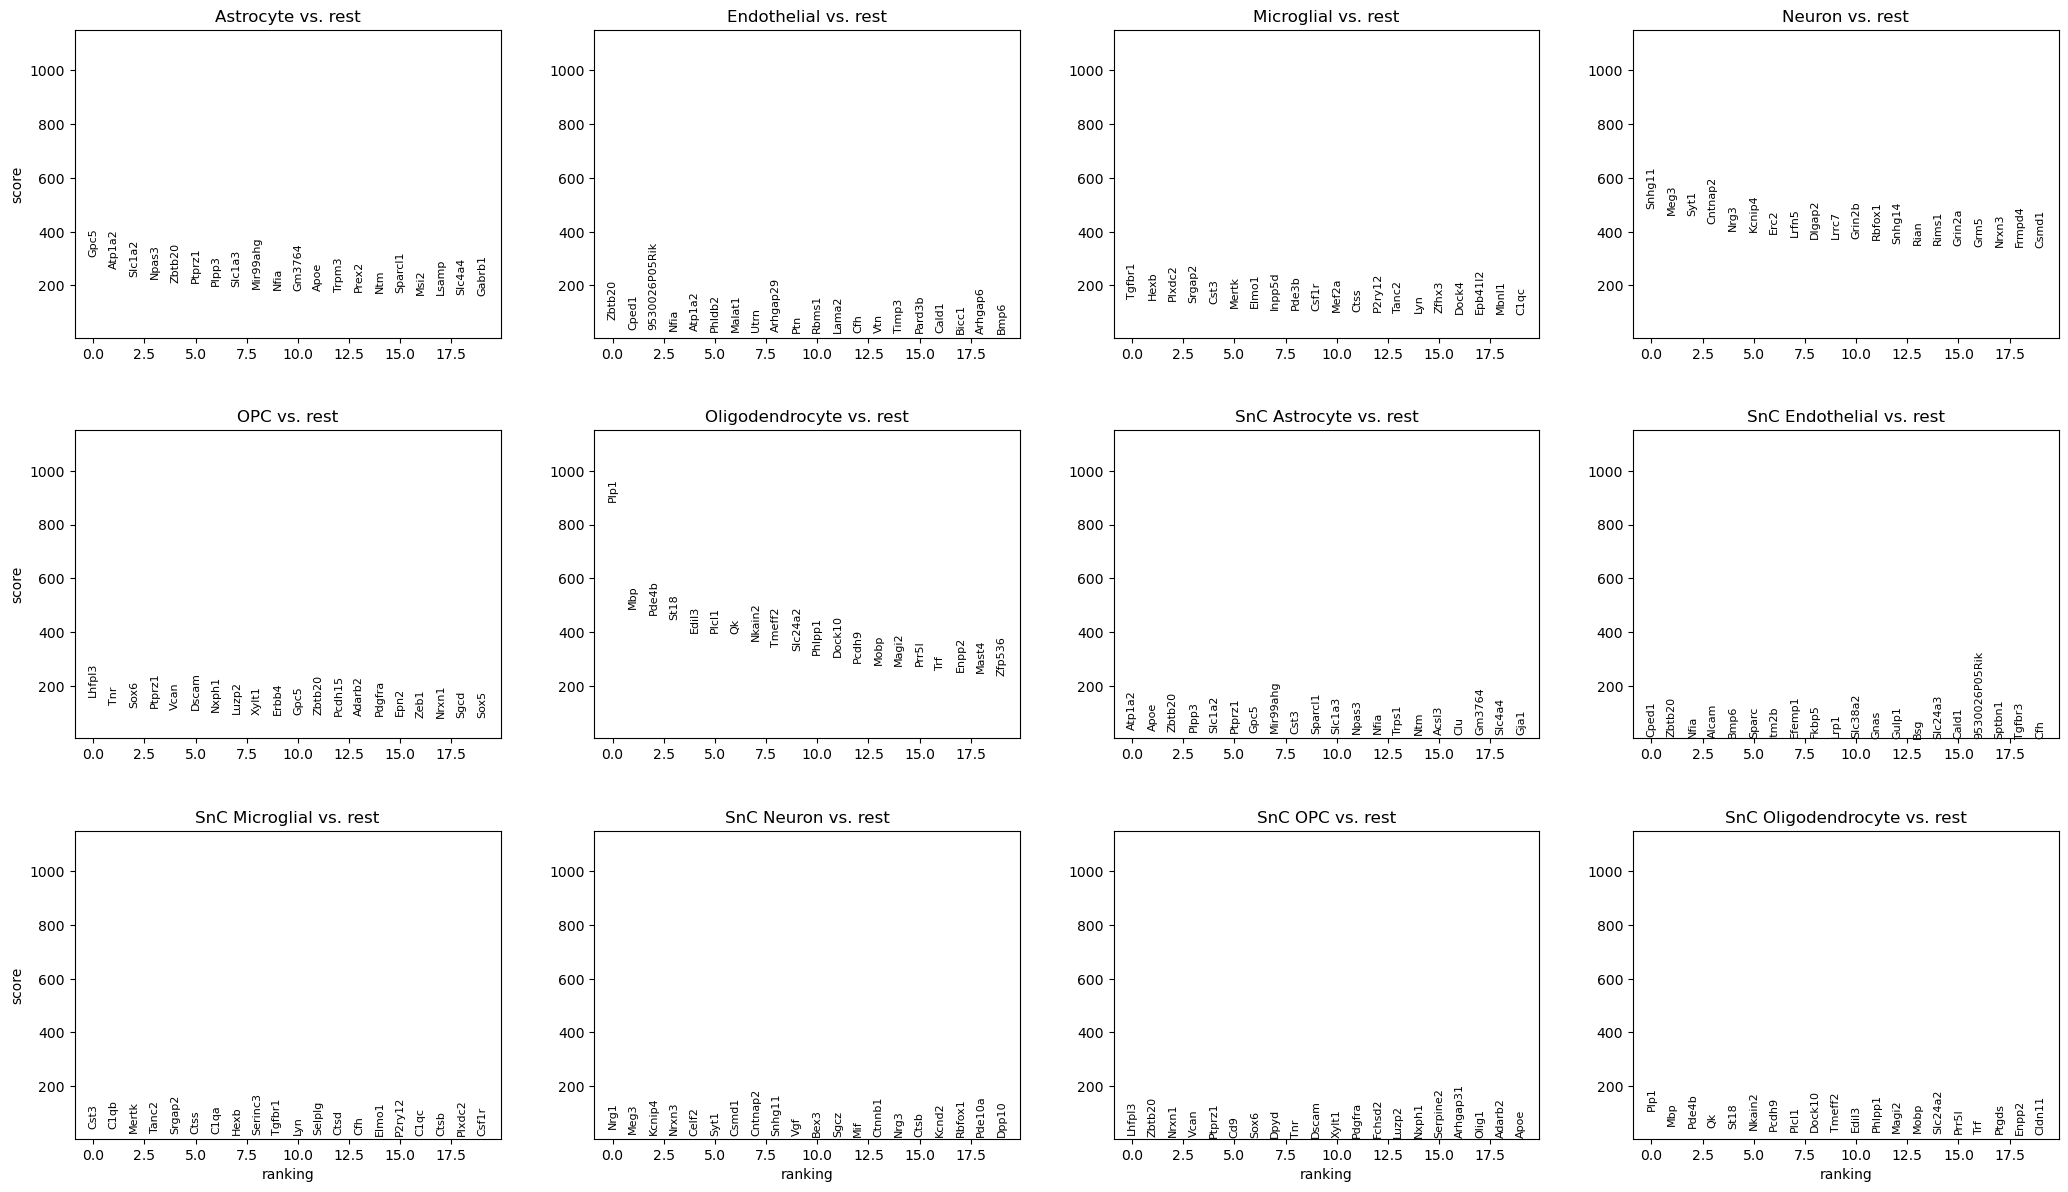

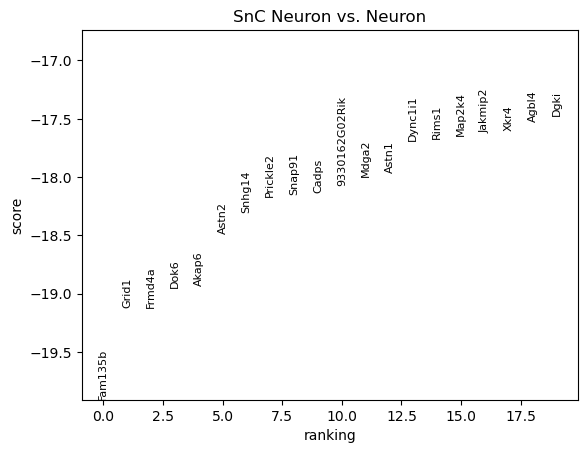

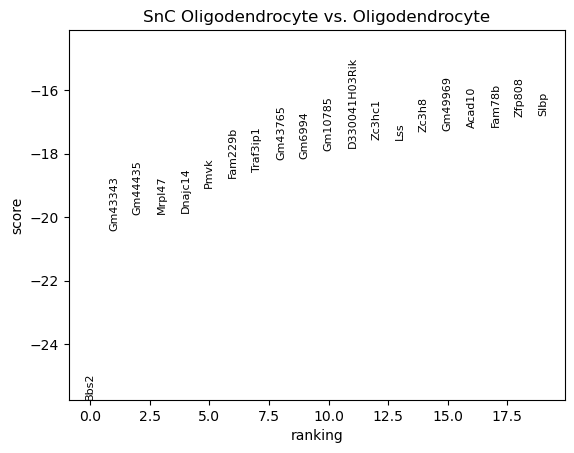

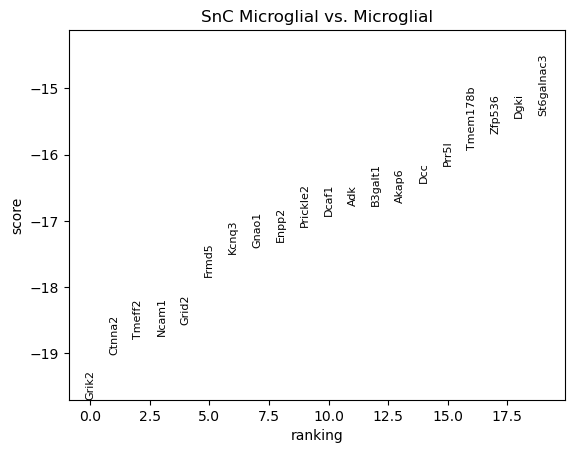

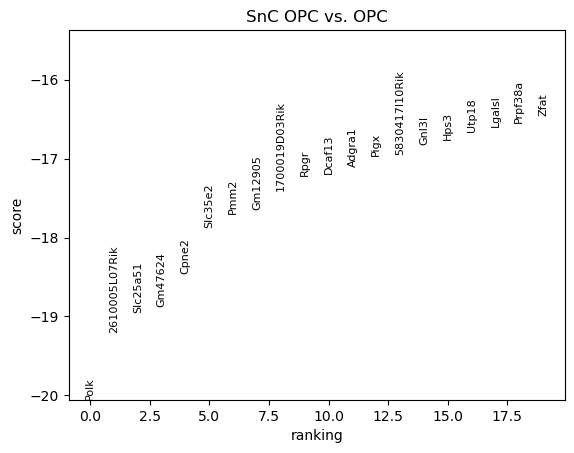

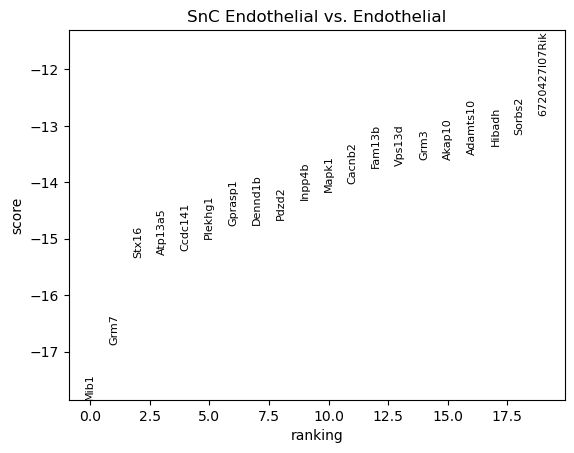

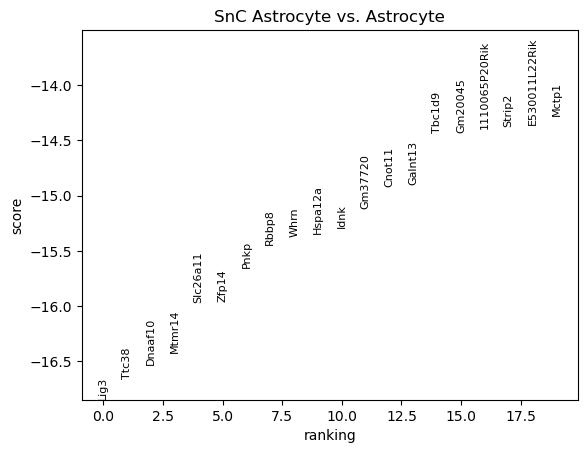

In [11]:
p_threshold = 1e-10
lfc_threshold = 1
self.find_markers(col_celltype="Senescent_Cell_Label_by_Type")
df_snc_markers = {}
df_snc_markers["All"] = self.get_markers_df(
    n_genes=50, col_celltype="Senescent_Cell_Label_by_Type",
    log2fc_threshold=1, p_threshold=1e-10)
# print(df_snc_markers["All"].loc[pd.unique([
#     i[0] for i in df_snc_markers["All"].index.values if (
#         "SnC" in i[0])])].groupby("Senescent_Cell_Label_by_Type").apply(
#             lambda x: x.head(3)))
for x in self.rna.obs[col_celltype].unique():
    df_snc_markers[x] = self.find_markers(
        col_celltype="Senescent_Cell_Label_by_Type",
        reference=x, groups=[x, f"SnC {x}"], rankby_abs=True,
        inplace=False).reset_index(0, drop=True).assign(**{
            col_celltype: f"SnC {x}"}).reset_index().set_index([
                col_celltype, "names"])
df_snc_markers = pd.concat(df_snc_markers, names=["Comparison"])
df_snc_markers = df_snc_markers.rename_axis([
    "Comparison", col_celltype, "names"]).rename({
        "logfoldchanges": "log_fc"}, axis=1).assign(
            log_fc_abs=df_snc_markers["logfoldchanges"].abs())
df_snc_markers_top = df_snc_markers[df_snc_markers.pvals_adj < p_threshold]
df_snc_markers_top = df_snc_markers_top[
    df_snc_markers.log_fc_abs >= lfc_threshold]
df_snc_markers_top = df_snc_markers_top.groupby([
    "Comparison", col_celltype]).apply(
        lambda x: x.assign(scores_abs=x.scores.abs()).sort_values(
            "scores_abs", ascending=False).head(20),
        include_groups=False).reset_index([0, 1], drop=True)

## By Group

In [ ]:
res_rank_genes, p_threshold = {}, 1e-10
for x in self.rna.obs[col_batch].unique():
    res_rank_genes[x] = {}
    for c in self.rna.obs[self.rna.obs[col_batch] == x][
            col_celltype].unique():
        s_iter = (self.rna.obs[col_batch] == x) & (self.rna.obs[
            "Senescent_Cell_Label_by_Type"].isin([c, f"SnC {c}"]))
        tmp = sc.tl.rank_genes_groups(
            self.rna[s_iter], "Senescent_Cell_Label_by_Type", rankby_abs=True,
            layer="log1p", groups=[c, f"SnC {c}"], reference=c, copy=True)
        res_rank_genes[x][c] = sc.get.rank_genes_groups_df(
            tmp, f"SnC {c}", pval_cutoff=p_threshold)
    tmp = sc.tl.rank_genes_groups(
            self.rna[self.rna.obs[col_batch] == x],
            "Senescent_Cell_Label", rankby_abs=True,
            layer="log1p", reference="Non-Senescent", copy=True)
    res_rank_genes[x]["Overall"] = sc.get.rank_genes_groups_df(
            tmp, f"Senescent", pval_cutoff=p_threshold)
    res_rank_genes[x] = pd.concat(res_rank_genes[x], names=[col_celltype])
res_rank_genes = pd.concat(res_rank_genes, names=[col_batch])
res_rank_genes = res_rank_genes.assign(
    logfoldchanges_abs=res_rank_genes.logfoldchanges.abs())
res_rank_genes_top = res_rank_genes.reset_index().groupby([
    col_batch, col_celltype]).apply(
        lambda x: x.sort_values("logfoldchanges_abs").iloc[:20],
        include_groups=False).reset_index(2, drop=True).set_index(
            "names", append=True).rename_axis([
                col_batch, col_celltype, "variable"])
res_rank_genes_top

# Plot

## Comparison

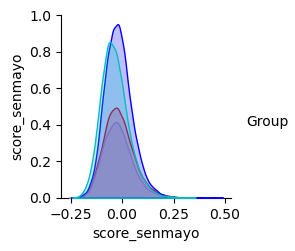

In [ ]:
scores = self.rna.obs[[col_batch] + [
    f"score_{x}" for x in sen_metrics]].set_index(
        col_batch, append=True).reset_index()
sns.pairplot(scores, diag_kind="kde", diag_kws=dict(
    cut=0, fill=True, common_norm=True),
             hue=col_batch, palette=palette[col_batch])

## Scores

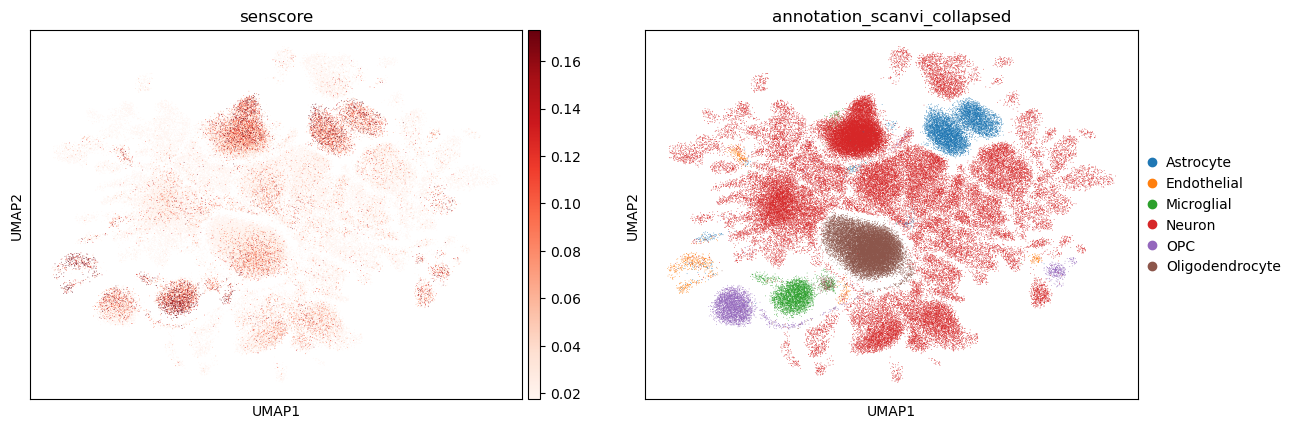

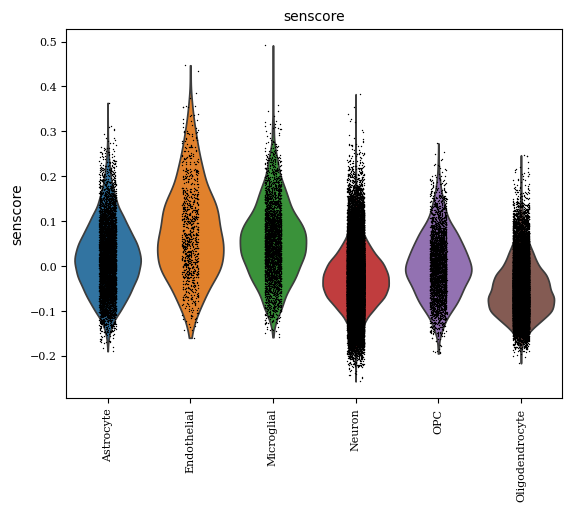

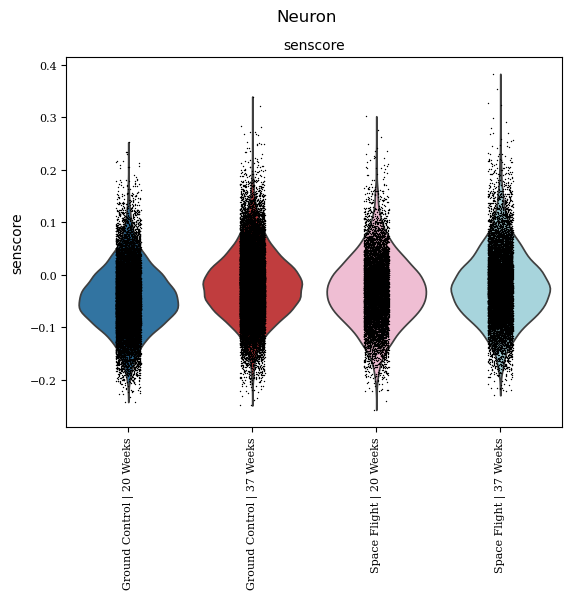

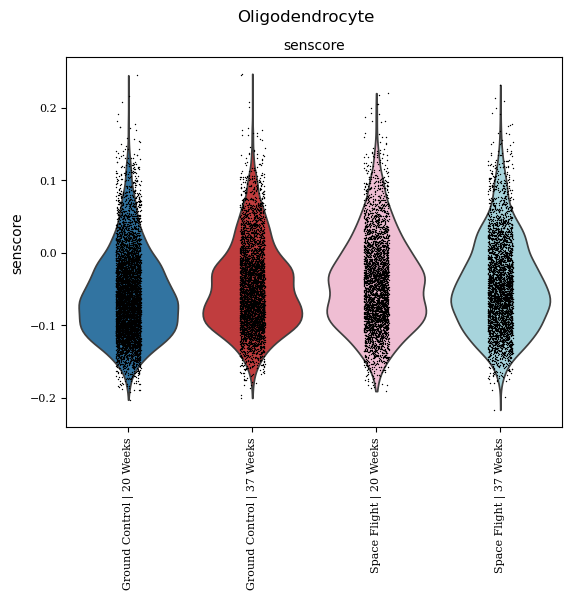

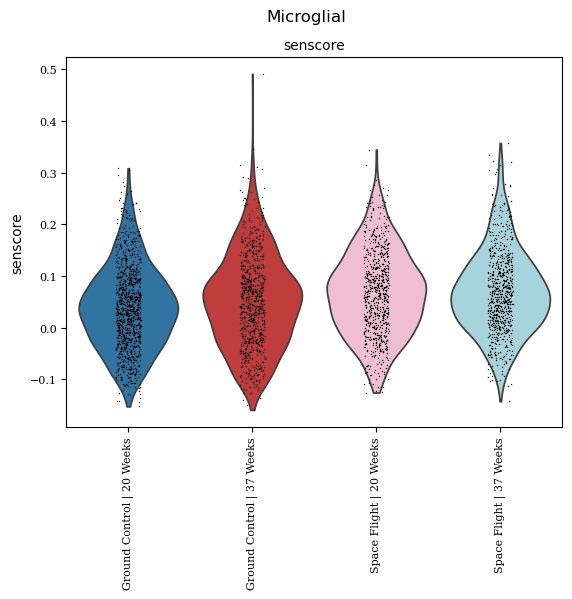

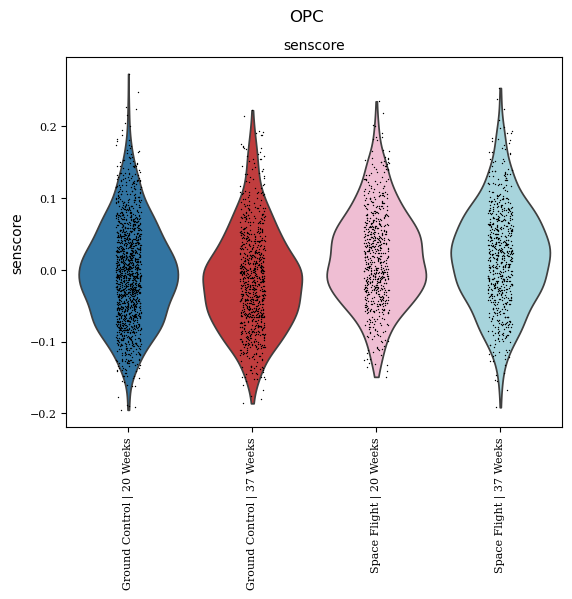

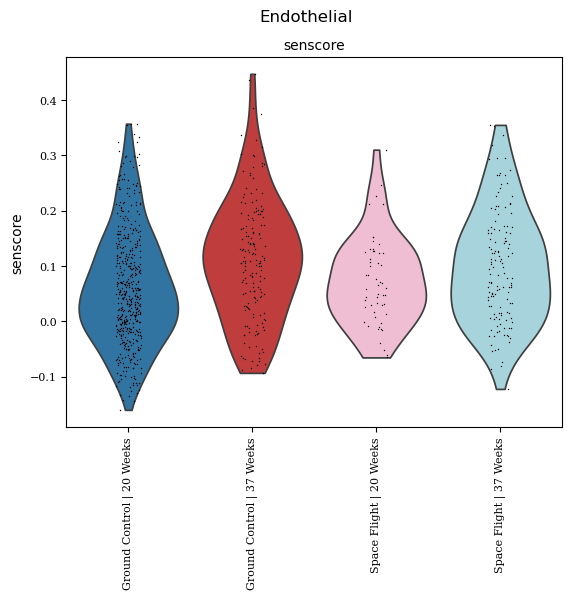

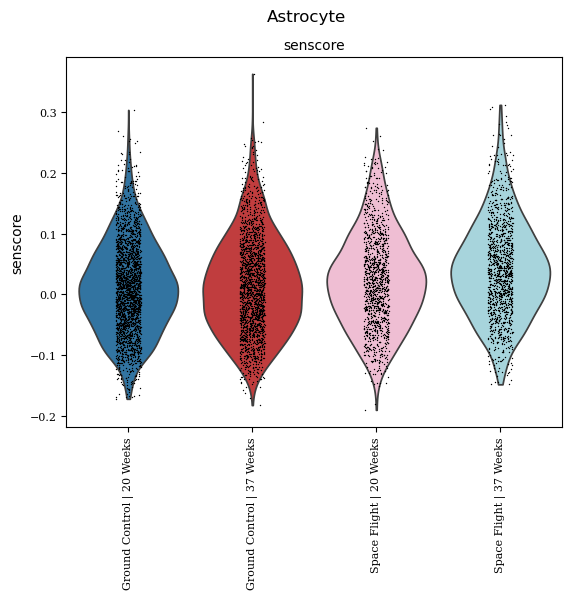

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

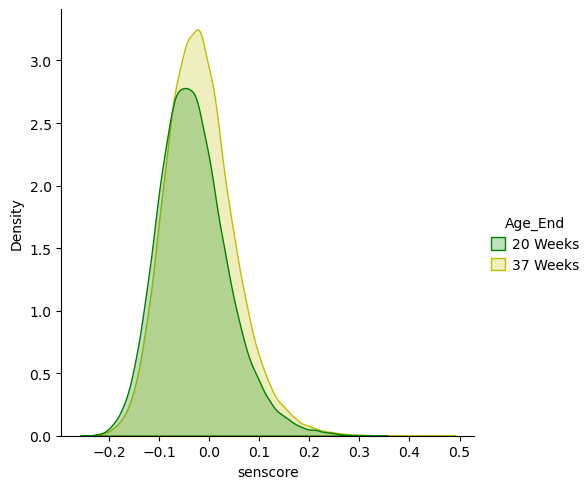

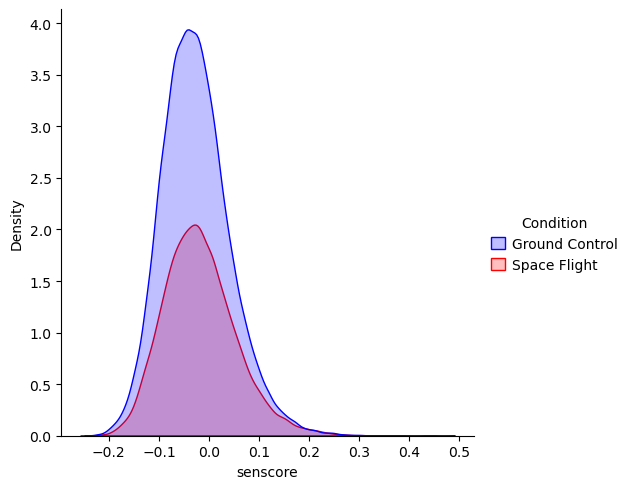

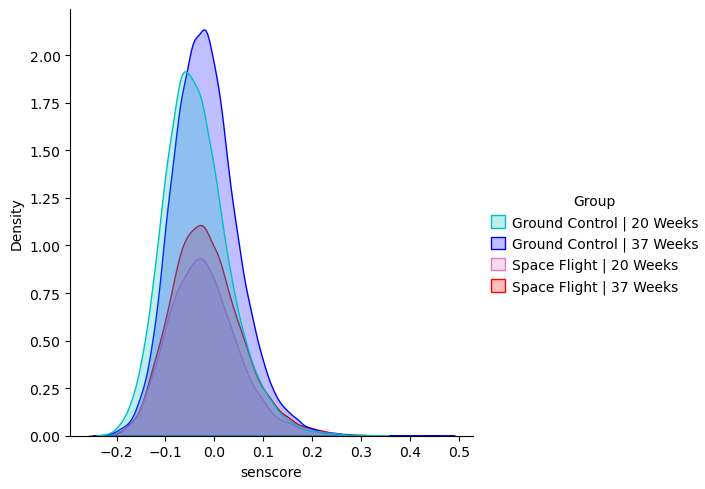

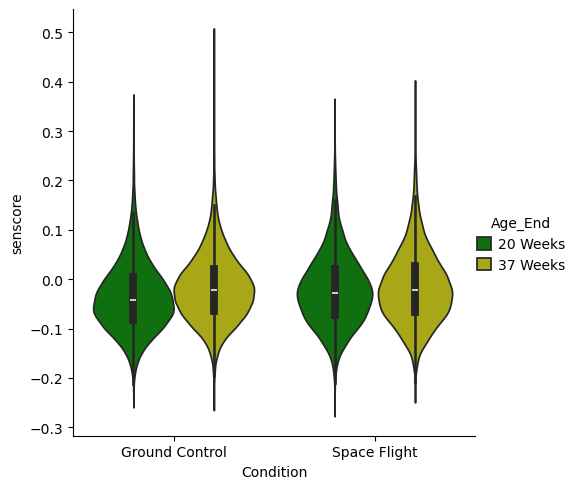

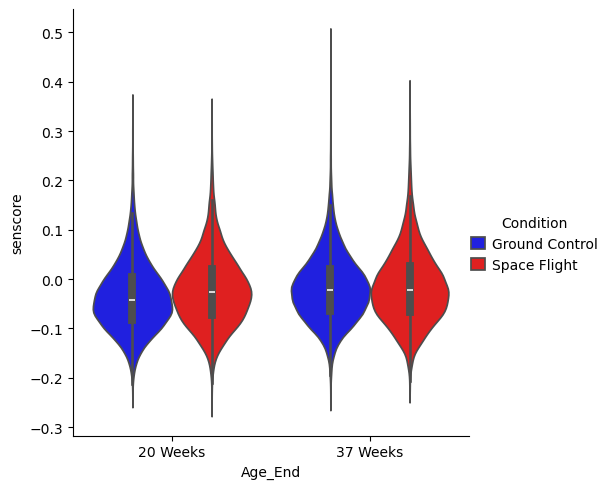

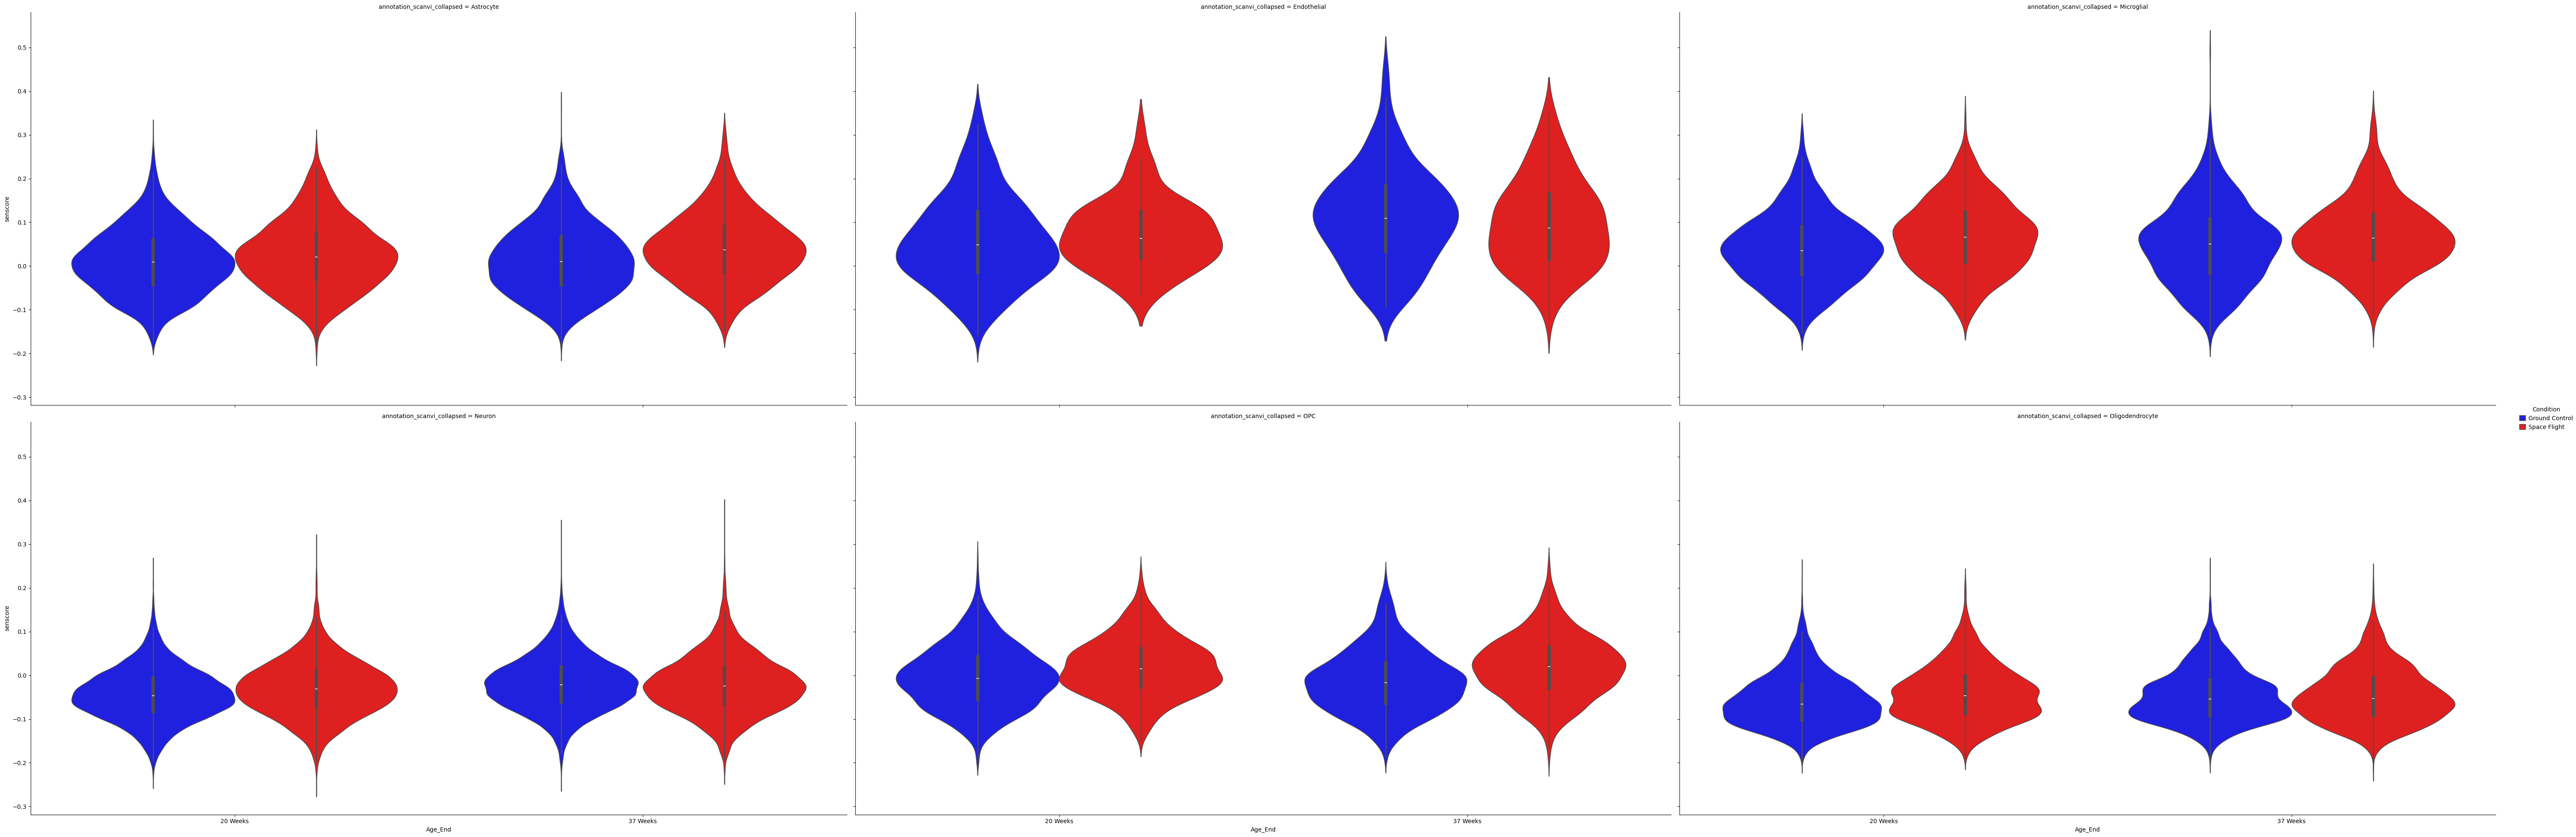

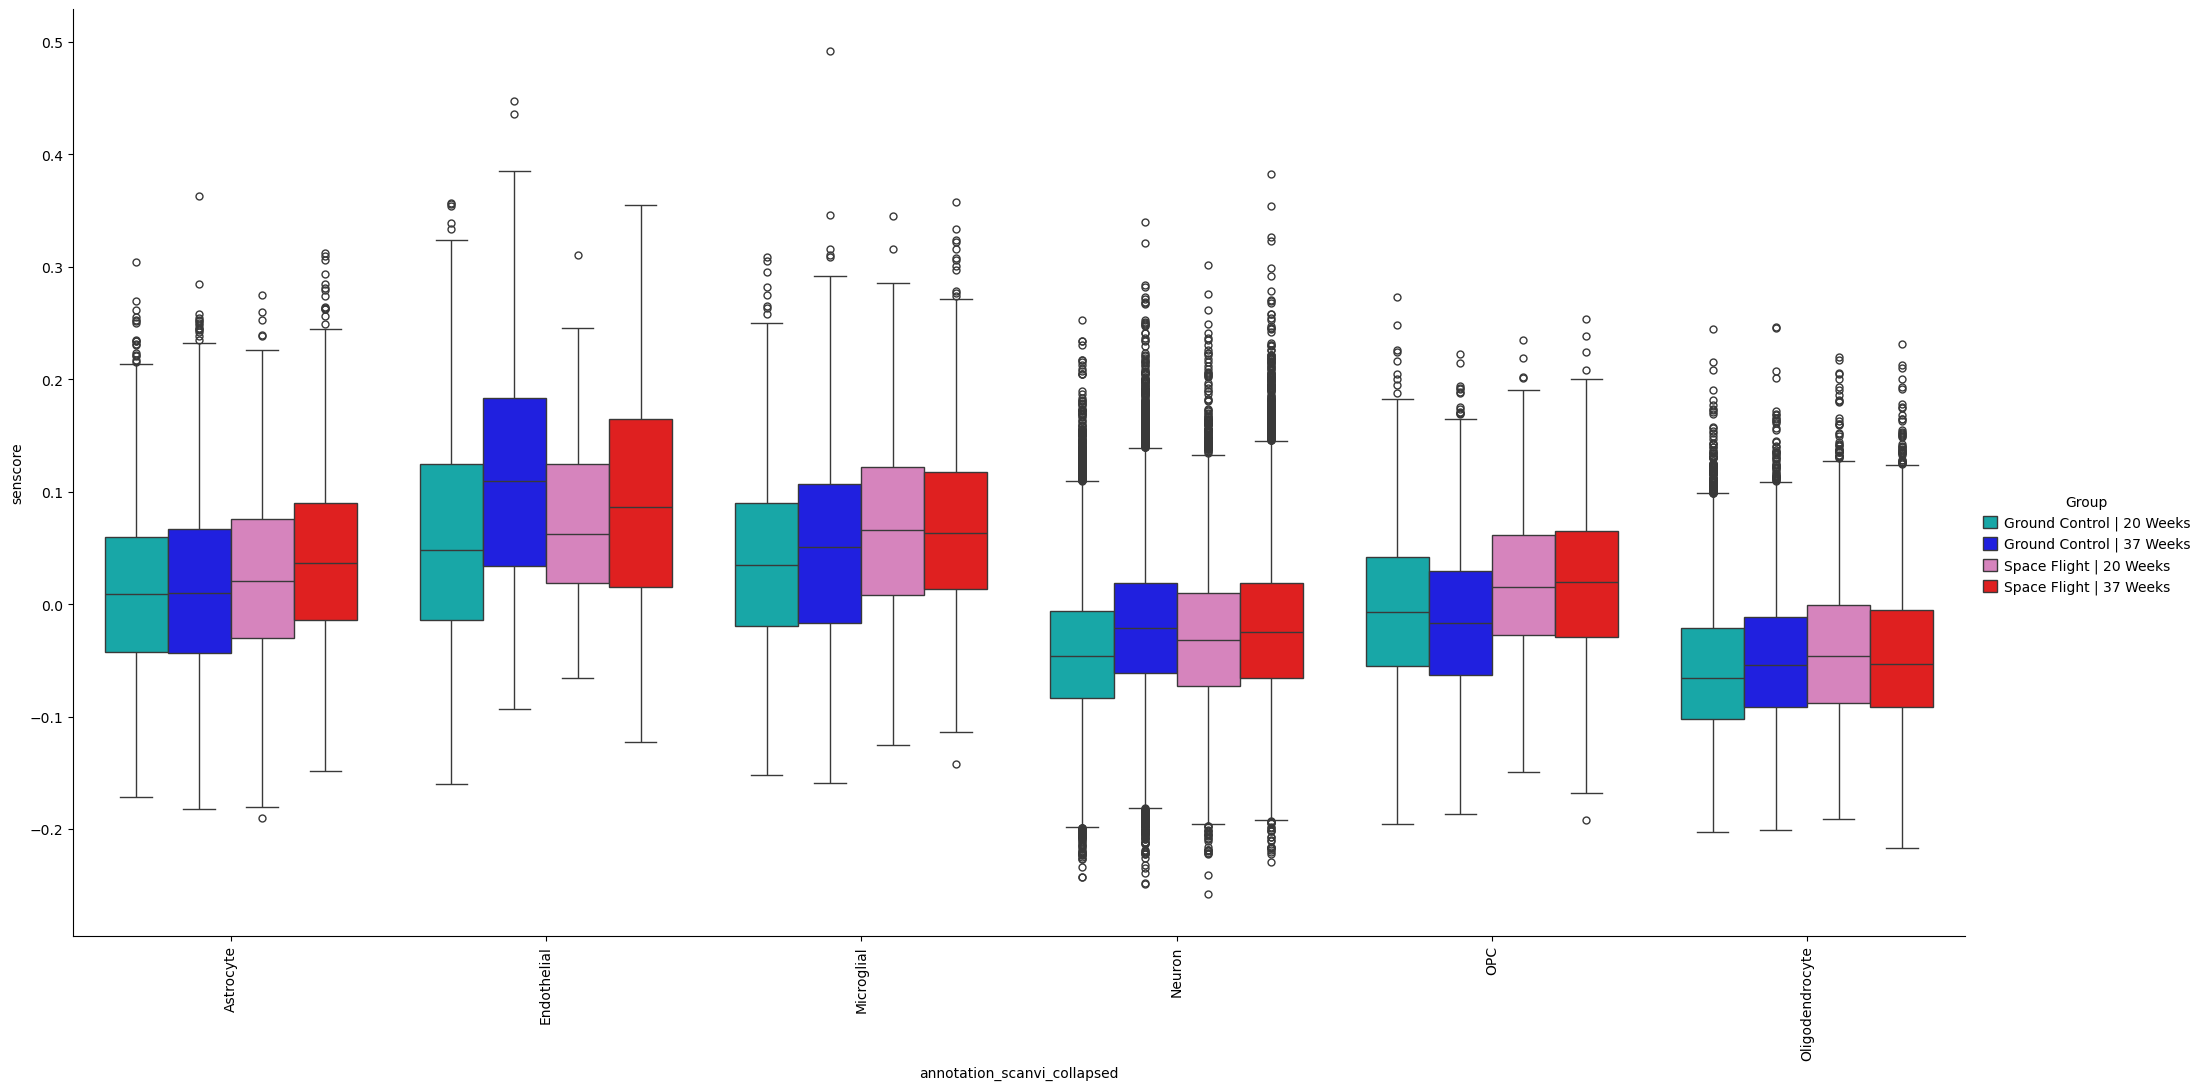

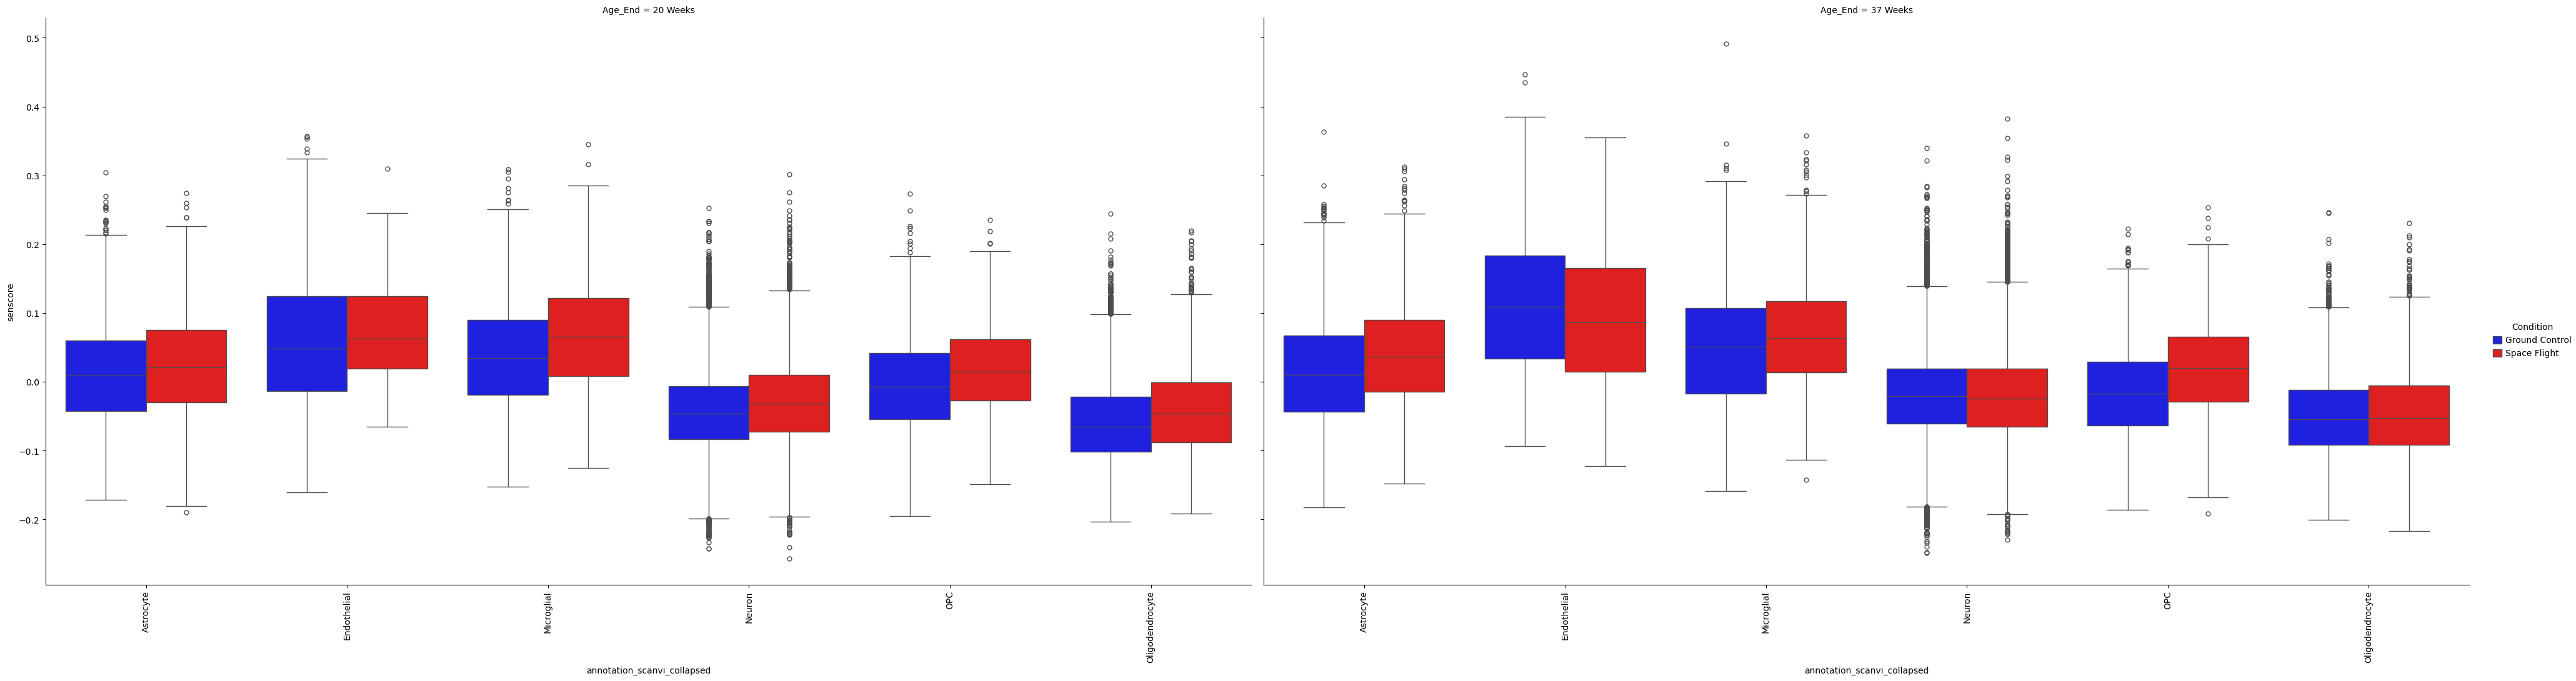

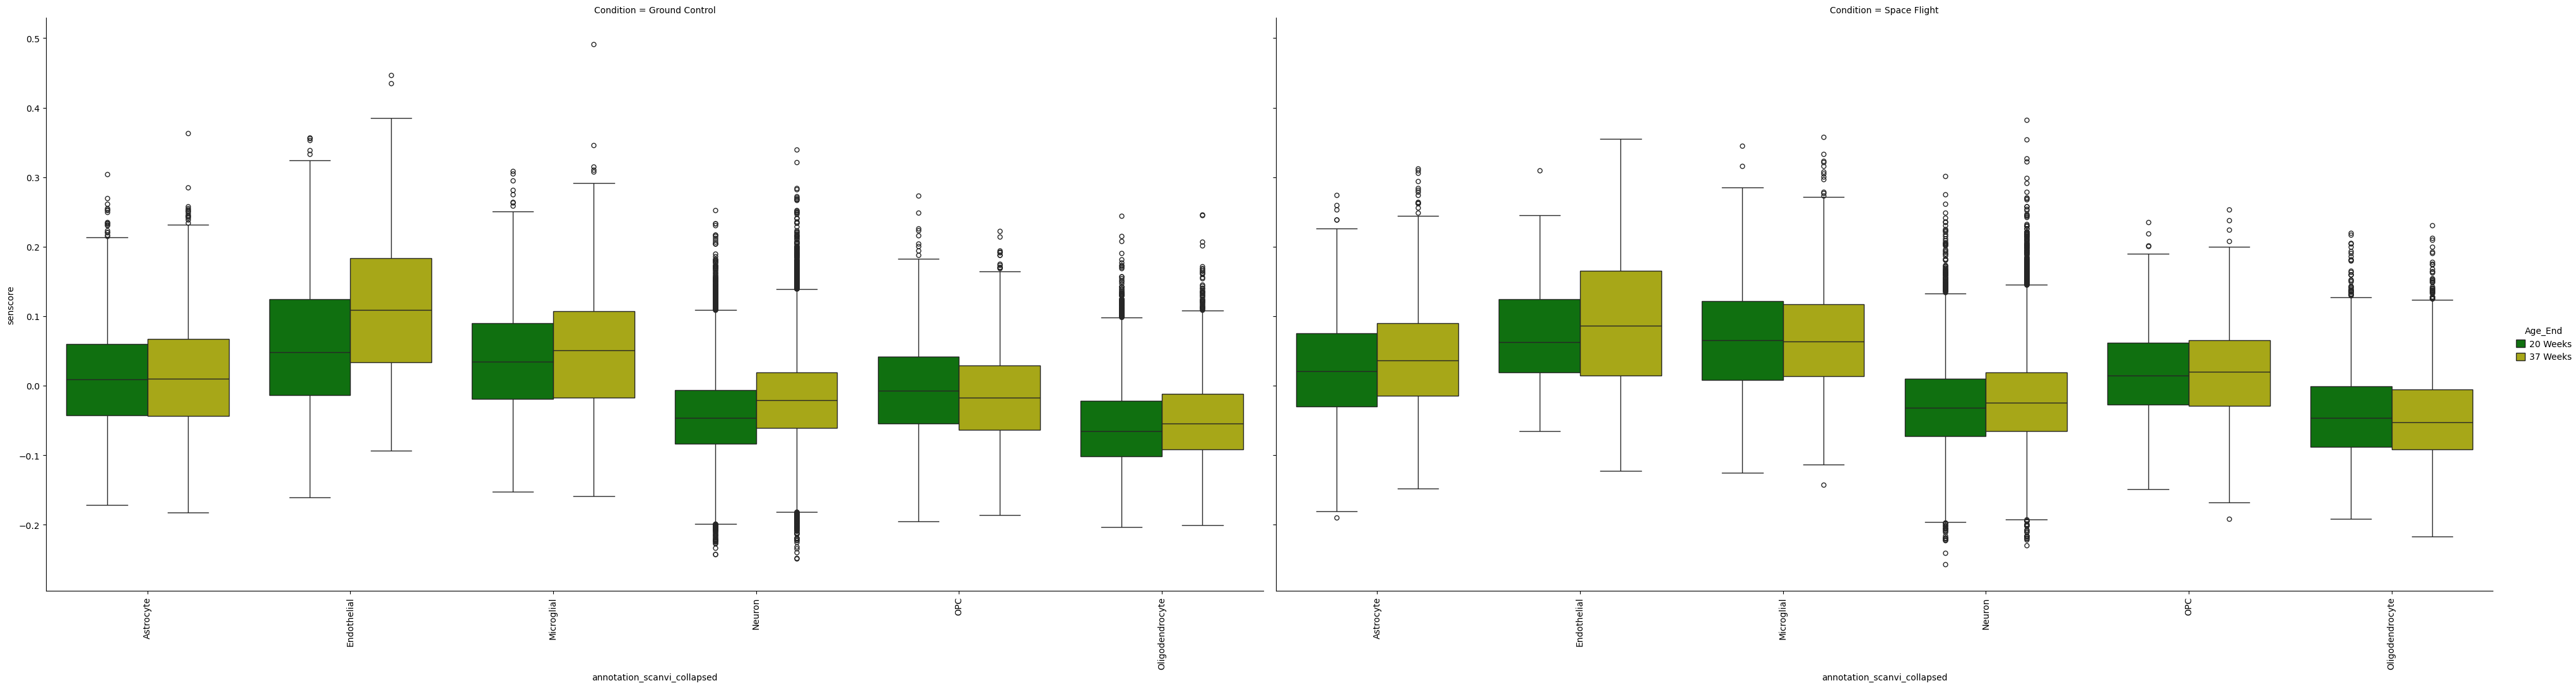

In [13]:
# UMAP with Senescence Scores
bnds = self.rna.obs["senscore"].describe(percentiles=[0.75, 0.99])
_ = self.plot(kind="umap", color=["senscore", col_celltype], umap=dict(
    palette=None, color_map="Reds", vmin=bnds["75%"], vmax=bnds["99%"]))

# Violin Plot of Senescence Scores
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              col_celltype=col_celltype, rotation=90)
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              by_group=col_celltype, col_wrap=1,
              col_celltype=col_batch, rotation=90)

# KDEs
fig_sen_kde = {}
for x in [col_age, col_condition, col_batch]:
    fig_sen_kde[x] = sns.displot(self.rna.obs, hue=x, x="senscore",
                                 palette=palette[x], kind="kde",
                                 cut=0, common_norm=True, fill=True)

# Overall (All Cell Types)
fig_sen_overall = sns.catplot(self.rna.obs, x=col_condition,
                              hue=col_age, y="senscore",
                              palette=palette[col_age],
                              kind="violin")
fig_sen_overall_2 = sns.catplot(self.rna.obs, x=col_age, hue=col_condition,
                                palette=palette[col_condition],
                                y="senscore", kind="violin")

# By Cell Type
fig_sen_rc = sns.catplot(self.rna.obs, col=col_celltype, y="senscore",
                         palette=palette[col_condition],
                         hue=col_condition, x=col_age, kind="violin",
                         height=10, aspect=2, col_wrap=3)
fig_sen = sns.catplot(self.rna.obs, x=col_celltype, y="senscore",
                      palette=palette[col_batch],
                      hue=col_batch, kind="box", height=10, aspect=2)
for a in fig_sen.axes.flatten():
    a.tick_params(axis="x", labelrotation=90)
fig_sen_2 = sns.catplot(self.rna.obs, x=col_celltype, y="senscore",
                        col=col_age, hue=col_condition,
                        palette=palette[col_condition],
                        kind="box", height=10, aspect=2)
for a in fig_sen_2.axes.flatten():
    a.tick_params(axis="x", labelrotation=90)
fig_sen_3 = sns.catplot(self.rna.obs, x=col_celltype, y="senscore",
                        col=col_condition, hue=col_age,
                        palette=palette[col_age],
                        kind="box", height=10, aspect=2)
for a in fig_sen_3.axes.flatten():
    a.tick_params(axis="x", labelrotation=90)

## Burden 

Group by sample and cell type and get percentage of senescent cells

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  



                 min  25%  50%  75%   max
Condition                               
Ground Control  0.0  0.4  1.0  2.0   6.2
Space Flight    0.0  0.9  1.8  2.3  11.1


           min  25%  50%  75%   max
Age_End                           
20 Weeks  0.0  0.5  1.2  2.0   5.0
37 Weeks  0.0  0.5  1.6  3.2  11.1


                          min  25%  50%  75%   max
Condition      Age_End                           
Ground Control 20 Weeks  0.0  0.4  0.8  1.7   5.0
               37 Weeks  0.0  0.4  1.5  3.2   6.2
Space Flight   20 Weeks  0.0  0.8  1.6  2.1   3.3
               37 Weeks  0.0  0.9  1.9  2.9  11.1


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


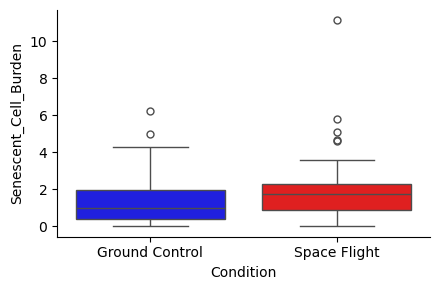

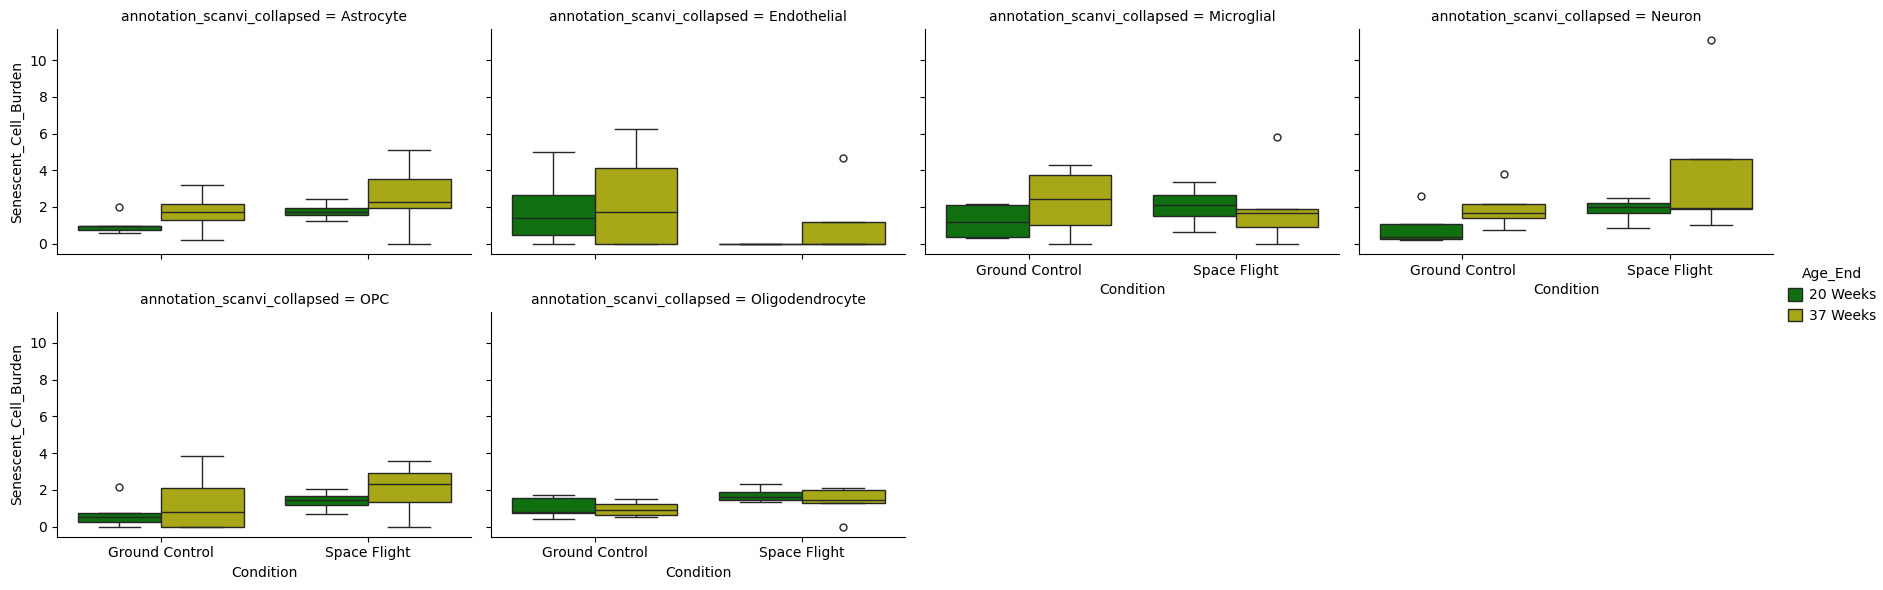

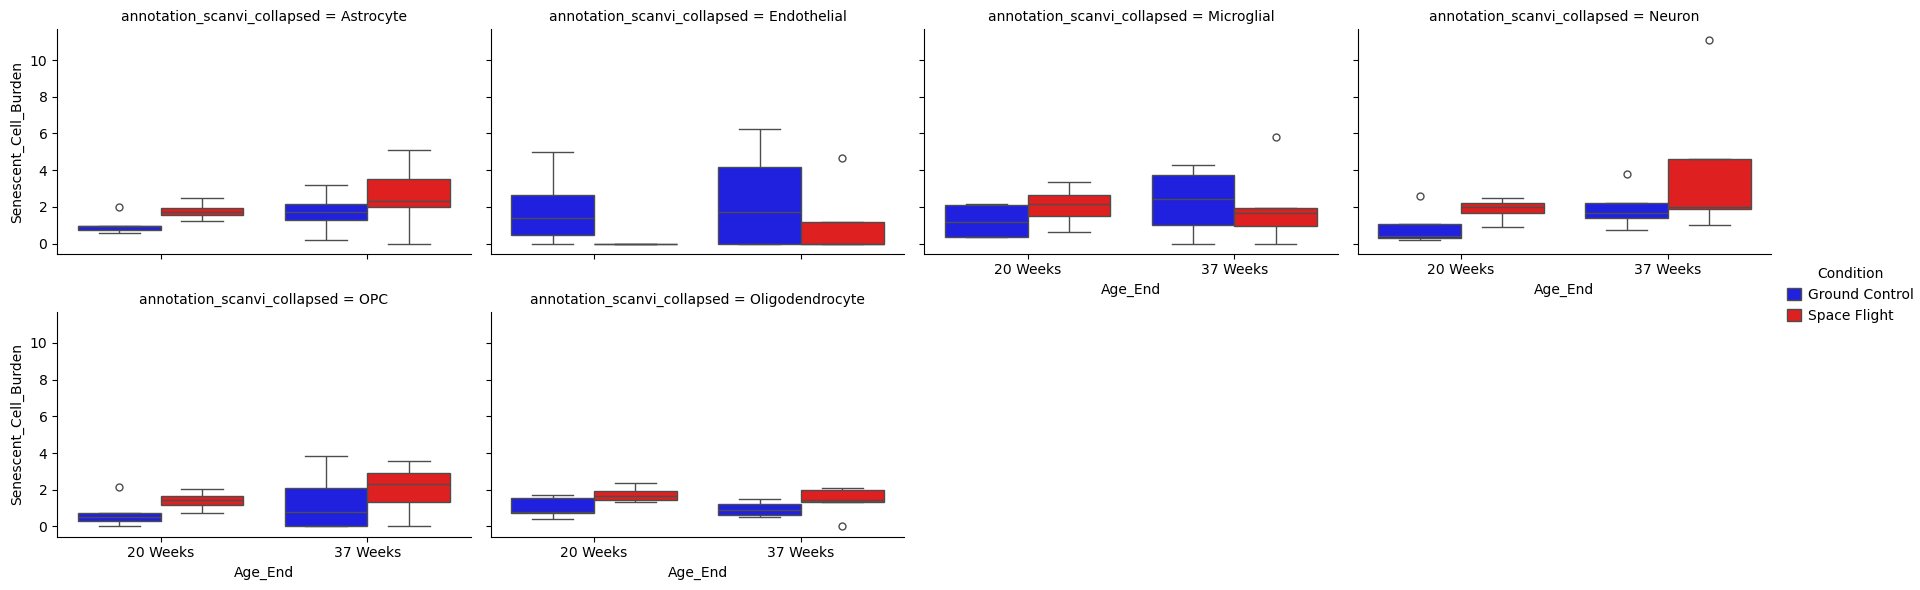

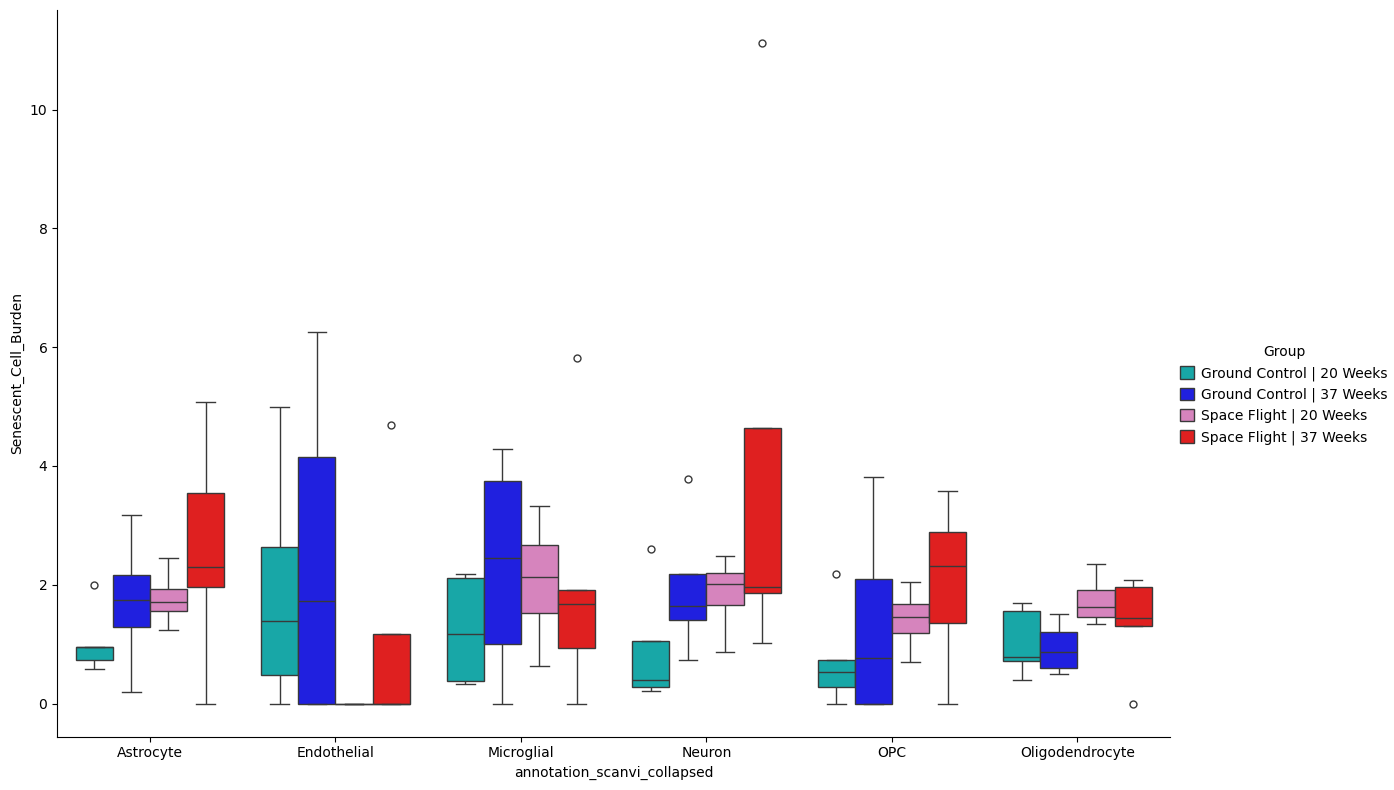

In [14]:
grps = [col_sample, col_celltype, col_age, col_condition, col_batch]
dff = self.rna.obs[grps + ["Senescent_Cell"]].groupby(grps).apply(
    lambda x: x["Senescent_Cell"].mean(), include_groups=False
    ).to_frame("Senescent_Cell_Burden") * 100
# kws_plot = dict(kind="violin", split=False, , common_norm=True)
kws_plot = dict(kind="box", errorbar=("ci", 95))

sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            palette=palette[col_condition],
            hue=col_condition, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            col=col_celltype, col_wrap=4,
            palette=palette[col_age],
            hue=col_age, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", hue=col_condition, **kws_plot,
            col=col_celltype, col_wrap=4,
            palette=palette[col_condition],
            x=col_age, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_celltype, **kws_plot,
            palette=palette[col_batch],
            hue=col_batch, data=dff, height=8, aspect=1.5)
for x in [col_condition, col_age, [col_condition, col_age]]:
    print("\n\n", round(dff["Senescent_Cell_Burden"].groupby(x).describe()[[
        "min", "25%", "50%", "75%", "max"]], 1))

# Analyze

## Regressions & ANOVAs & MEMs

In [15]:
r_dff = polars.DataFrame(dff.reset_index())  # pymer-compatible aggregated df
r_rna = polars.DataFrame(self.rna.obs.rename({
    col_celltype: "CT_"}, axis=1).copy())  # pymer-compatible cell-level df
lvls = ["key_control", "key_treatment"]
factors = {col_condition: [keys[col_condition][i] for i in lvls],
           col_age: [keys[col_age][i] for i in lvls]}

### Scores

##### Cell Type Random Effects

In [ ]:
# # Age + Condition
# model_ca_mlm = lmer(f"senscore ~ {col_condition} + {col_age} +"
#                     f"(1 | {col_sample})", data=r_rna)  # set up model
# model_ca_mlm.set_factors(factors)
# model_ca_mlm.set_transforms({"senscore": "zscore"})
# model_ca_mlm.anova(summary=True).show()

# # Age * Condition
# model_ca_mlm_i = lmer(
#     f"senscore ~ {col_condition} * {col_age} + "
#     f"(1 | {col_sample})", data=r_rna)  # set up model
# model_ca_mlm_i.set_factors(factors)
# model_ca_mlm_i.set_transforms({"senscore": "zscore"})
# model_ca_mlm_i.anova(summary=True).show()

# # Age * Condition (Condition as Random Effect)
# model_ca_mlm_ii = lmer(
#     f"senscore ~ {col_condition} * {col_age} + "
#     f"(1 | {col_sample}) + (1 + {col_condition} | CT_)",
#     data=r_rna)  # set up model
# model_ca_mlm_ii.set_factors(factors)
# model_ca_mlm_ii.set_transforms({"senscore": "zscore"})
# model_ca_mlm_ii.anova(summary=True).show()

# Age * Condition (Age and Condition as Random Effect)
model_ca_mlm_iii = lmer(
    f"senscore ~ {col_condition} * {col_age} + (1 | {col_sample})"
    f" + (1 + {col_condition} + {col_age} | CT_)",
    data=r_rna)  # set up model
model_ca_mlm_iii.set_factors(factors)
model_ca_mlm_iii.set_transforms({"senscore": "zscore"})
model_ca_mlm_iii.anova(summary=True).show()

# Model Comparison
# compare(model_ca_mlm, model_ca_mlm_i, model_ca_mlm_i,
#         model_ca_mlm_ii, model_ca_mlm_iii).show()

# GLM Version of Results
# model_ca_mlm.summary().show()
# model_ca_mlm_i.summary().show()
# model_ca_mlm_ii.summary().show()
model_ca_mlm_iii.summary().show()

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 103274' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 103274)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 103274' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 103274)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Condition 
 1.000 
 inf 
 5.960 
 5.960 
 0.01463 
 * 
 
 
 Age_End 
 1.000 
 inf 
 2.150 
 2.150 
 0.1426 
 
 
 
 Condition:Age_End 
 1.000 
 inf 
 0.349 
 0.349 
 0.5549 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Condition*Age_End+(1|sample)+(1+Condition+Age_End|CT_)) 
 
 
 Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -137950 
AIC: 275925 | BIC: 276040 
Residual error: 0.919 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.159 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.636 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 ConditionSpace Flight 
 0.148 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 Age_End37 Weeks 
 0.256 
 
 
 
 
 
 
 
 
 
 CT_-cor 
 (Intercept) 
 0.042 
 
 
 
 
 
 
 
 
 
 CT_-cor 
 (Intercept) 
 0.564 
 
 
 
 
 
 
 
 
 
 CT_-cor 
 ConditionSpace Flight 
 −0.793 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.919 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.330 
 0.269 
 −0.336 
 0.995 
 1.224 
 5.769 
 0.2687 
 
 
 
 
 ConditionSpace Flight 
 0.283 
 0.123 
 0.023 
 0.542 
 2.290 
 17.931 
 0.03436 
 * 
 
 
 
 Age_End37 Weeks 
 0.235 
 0.150 
 −0.087 
 0.557 
 1.565 
 14.053 
 0.1399 
 
 
 
 
 ConditionSpace Flight:Age_End37 Weeks 
 −0.089 
 0.152 
 −0.415 
 0.236 
 −0.590 
 13.918 
 0.5644 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

#### Cell Type as Moderator

In [32]:
# Age + Condition * Cell Type
model_cac_mlm_i2 = lmer(
    f"senscore ~  Aged + Spaceflight * CT_ + "
    f"(1 | {col_sample})", data=r_rna)  # set up model
model_cac_mlm_i2.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2.anova(summary=True).show()

# Age * Condition * Cell Type
model_cac_mlm_i2b = lmer(
    f"senscore ~  Aged * Spaceflight + Spaceflight * CT_ + "
    f"(1 | {col_sample})", data=r_rna)  # set up model
model_cac_mlm_i2b.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2b.anova(summary=True).show()

# Age * Condition * Cell Type
model_cac_mlm_i3 = lmer(
    f"senscore ~  Aged * Spaceflight * CT_ + "
    f"(1 | {col_sample})", data=r_rna)  # set up model
model_cac_mlm_i3.set_transforms({"senscore": "zscore"})
model_cac_mlm_i3.anova(summary=True).show()

# GLM Version of Results
model_cac_mlm_i2.summary().show()
model_cac_mlm_i2b.summary().show()
model_cac_mlm_i3.summary().show()

# Model Comparison
compare(model_cac_mlm_i2, model_cac_mlm_i2b, model_cac_mlm_i3).show()

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 5.640 
 5.640 
 0.01755 
 * 
 
 
 Spaceflight 
 1.000 
 inf 
 11.454 
 11.454 
 <.001 
 *** 
 
 
 annotation_scanvi_collapsed 
 5.000 
 inf 
 2,746.320 
 13,731.600 
 
 *** 
 
 
 Spaceflight:annotation_scanvi_collapsed 
 5.000 
 inf 
 29.008 
 145.040 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 5.415 
 5.415 
 0.01996 
 * 
 
 
 Spaceflight 
 1.000 
 inf 
 11.021 
 11.021 
 <.001 
 *** 
 
 
 annotation_scanvi_collapsed 
 5.000 
 inf 
 2,746.334 
 13,731.670 
 
 *** 
 
 
 Aged:Spaceflight 
 1.000 
 inf 
 0.408 
 0.408 
 0.5228 
 
 
 
 Spaceflight:annotation_scanvi_collapsed 
 5.000 
 inf 
 28.996 
 144.980 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 5.981 
 5.981 
 0.01446 
 * 
 
 
 Spaceflight 
 1.000 
 inf 
 9.339 
 9.339 
 0.002243 
 ** 
 
 
 annotation_scanvi_collapsed 
 5.000 
 inf 
 2,669.438 
 13,347.190 
 
 *** 
 
 
 Aged:Spaceflight 
 1.000 
 inf 
 0.130 
 0.130 
 0.7185 
 
 
 
 Aged:annotation_scanvi_collapsed 
 5.000 
 inf 
 37.304 
 186.520 
 <.001 
 *** 
 
 
 Spaceflight:annotation_scanvi_collapsed 
 5.000 
 inf 
 34.950 
 174.750 
 <.001 
 *** 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsed 
 5.000 
 inf 
 18.125 
 90.625 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Aged+Spaceflight*annotation_scanvi_collapsed+(1|sample)) 
 
 
 Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -138067 
AIC: 276164 | BIC: 276307 
Residual error: 0.921 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.157 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.921 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.439 
 0.064 
 0.304 
 0.574 
 6.898 
 16.211 
 <.001 
 *** 
 
 
 
 Aged 
 0.178 
 0.075 
 0.018 
 0.338 
 2.375 
 14.933 
 0.03139 
 * 
 
 
 
 Spaceflight 
 0.309 
 0.078 
 0.145 
 0.473 
 3.954 
 17.619 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedEndothelial 
 0.886 
 0.038 
 0.812 
 0.960 
 23.426 
 103,248.906 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.450 
 0.025 
 0.400 
 0.499 
 17.750 
 103,246.539 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedNeuron 
 −0.675 
 0.014 
 −0.703 
 −0.647 
 −47.191 
 103,253.259 
 
 *** 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.292 
 0.024 
 −0.338 
 −0.245 
 −12.372 
 103,249.458 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.921 
 0.016 
 −0.952 
 −0.889 
 −56.980 
 103,248.648 
 
 *** 
 
 
 
 Spaceflight:annotation_scanvi_collapsedEndothelial 
 −0.105 
 0.079 
 −0.260 
 0.050 
 −1.326 
 103,251.597 
 0.185 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedMicroglial 
 0.054 
 0.039 
 −0.023 
 0.131 
 1.382 
 103,246.538 
 0.1669 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedNeuron 
 −0.177 
 0.024 
 −0.224 
 −0.130 
 −7.342 
 103,255.169 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOPC 
 0.078 
 0.039 
 0.000 
 0.155 
 1.971 
 103,249.550 
 0.04874 
 * 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOligodendrocyte 
 −0.154 
 0.027 
 −0.206 
 −0.102 
 −5.786 
 103,248.885 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Aged*Spaceflight+Spaceflight*annotation_scanvi_collapsed+(1|sample)) 
 
 
 Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -138068 
AIC: 276168 | BIC: 276320 
Residual error: 0.921 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.161 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.921 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.417 
 0.073 
 0.261 
 0.573 
 5.700 
 14.781 
 <.001 
 *** 
 
 
 
 Aged 
 0.227 
 0.108 
 −0.005 
 0.459 
 2.099 
 13.868 
 0.05458 
 . 
 
 
 
 Spaceflight 
 0.358 
 0.110 
 0.123 
 0.593 
 3.243 
 15.072 
 0.00543 
 ** 
 
 
 
 annotation_scanvi_collapsedEndothelial 
 0.886 
 0.038 
 0.812 
 0.960 
 23.427 
 103,248.573 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.450 
 0.025 
 0.400 
 0.499 
 17.750 
 103,246.502 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedNeuron 
 −0.675 
 0.014 
 −0.703 
 −0.647 
 −47.192 
 103,252.374 
 
 *** 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.292 
 0.024 
 −0.338 
 −0.245 
 −12.372 
 103,249.147 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.921 
 0.016 
 −0.952 
 −0.889 
 −56.979 
 103,248.519 
 
 *** 
 
 
 
 Aged:Spaceflight 
 −0.098 
 0.153 
 −0.426 
 0.230 
 −0.639 
 13.920 
 0.5331 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedEndothelial 
 −0.105 
 0.079 
 −0.260 
 0.050 
 −1.325 
 103,251.272 
 0.1851 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedMicroglial 
 0.054 
 0.039 
 −0.023 
 0.131 
 1.382 
 103,246.493 
 0.167 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedNeuron 
 −0.177 
 0.024 
 −0.224 
 −0.130 
 −7.340 
 103,253.333 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOPC 
 0.078 
 0.039 
 0.000 
 0.155 
 1.971 
 103,249.395 
 0.04876 
 * 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOligodendrocyte 
 −0.154 
 0.027 
 −0.206 
 −0.102 
 −5.787 
 103,248.734 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Aged*Spaceflight*annotation_scanvi_collapsed+(1|sample)) 
 
 
 Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -137917 
AIC: 275887 | BIC: 276135 
Residual error: 0.919 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.160 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.919 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.501 
 0.074 
 0.345 
 0.658 
 6.807 
 15.524 
 <.001 
 *** 
 
 
 
 Aged 
 0.037 
 0.111 
 −0.198 
 0.271 
 0.332 
 15.559 
 0.7445 
 
 
 
 
 Spaceflight 
 0.183 
 0.112 
 −0.054 
 0.419 
 1.636 
 16.243 
 0.1211 
 
 
 
 
 annotation_scanvi_collapsedEndothelial 
 0.651 
 0.045 
 0.564 
 0.739 
 14.573 
 103,239.106 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.385 
 0.034 
 0.320 
 0.451 
 11.492 
 103,236.384 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedNeuron 
 −0.794 
 0.019 
 −0.831 
 −0.756 
 −41.346 
 103,237.111 
 
 *** 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.248 
 0.030 
 −0.307 
 −0.189 
 −8.212 
 103,240.534 
 <.001 
 *** 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.957 
 0.021 
 −0.999 
 −0.915 
 −44.915 
 103,237.945 
 
 *** 
 
 
 
 Aged:Spaceflight 
 0.270 
 0.158 
 −0.064 
 0.605 
 1.709 
 16.359 
 0.1064 
 
 
 
 
 Aged:annotation_scanvi_collapsedEndothelial 
 0.768 
 0.085 
 0.602 
 0.935 
 9.035 
 103,239.001 
 <.001 
 *** 
 
 
 
 Aged:annotation_scanvi_collapsedMicroglial 
 0.146 
 0.051 
 0.046 
 0.246 
 2.859 
 103,236.545 
 0.004246 
 ** 
 
 
 
 Aged:annotation_scanvi_collapsedNeuron 
 0.257 
 0.029 
 0.200 
 0.313 
 8.925 
 103,242.983 
 <.001 
 *** 
 
 
 
 Aged:annotation_scanvi_collapsedOPC 
 −0.158 
 0.048 
 −0.253 
 −0.063 
 −3.270 
 103,238.157 
 0.001078 
 ** 
 
 
 
 Aged:annotation_scanvi_collapsedOligodendrocyte 
 0.073 
 0.033 
 0.009 
 0.137 
 2.235 
 103,238.959 
 0.02542 
 * 
 
 
 
 Spaceflight:annotation_scanvi_collapsedEndothelial 
 0.037 
 0.135 
 −0.229 
 0.302 
 0.272 
 103,238.411 
 0.7855 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedMicroglial 
 0.239 
 0.054 
 0.133 
 0.345 
 4.419 
 103,236.398 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_scanvi_collapsedNeuron 
 0.016 
 0.034 
 −0.051 
 0.082 
 0.463 
 103,237.130 
 0.6436 
 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOPC 
 0.167 
 0.054 
 0.061 
 0.273 
 3.098 
 103,237.478 
 0.001951 
 ** 
 
 
 
 Spaceflight:annotation_scanvi_collapsedOligodendrocyte 
 0.035 
 0.037 
 −0.037 
 0.107 
 0.946 
 103,239.194 
 0.3443 
 
 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsedEndothelial 
 −0.690 
 0.175 
 −1.032 
 −0.347 
 −3.946 
 103,239.781 
 <.001 
 *** 
 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsedMicroglial 
 −0.383 
 0.079 
 −0.537 
 −0.229 
 −4.868 
 103,236.505 
 <.001 
 *** 
 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsedNeuron 
 −0.406 
 0.048 
 −0.500 
 −0.311 
 −8.407 
 103,243.233 
 <.001 
 *** 
 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsedOPC 
 −0.105 
 0.079 
 −0.260 
 0.051 
 −1.319 
 103,239.000 
 0.1871 
 
 
 
 
 Aged:Spaceflight:annotation_scanvi_collapsedOligodendrocyte 
 −0.375 
 0.053 
 −0.480 
 −0.270 
 −7.022 
 103,238.919 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lmer(senscore~Aged+Spaceflight annotation_scanvi_collapsed+(1|sample)) 
Model 2: lmer(senscore~Aged Spaceflight+Spaceflight annotation_scanvi_collapsed+(1|sample)) 
Model 3: lmer(senscore~Aged Spaceflight*annotation_scanvi_collapsed+(1|sample)) 
 
 
 
 AIC 
 BIC 
 logLik 
 npar 
 -2*log(L) 
 Chisq 
 Df 
 Pr(>Chisq) 
 
 
 
 
 
 1.00 
 276164.7 
 276307.9 
 −138067.4 
 15.00 
 276.06K 
 
 
 
 
 
 
 2.00 
 276168.3 
 276321 
 −138068.1 
 16.00 
 276.06K 
 0.52 
 1.00 
 0.47 
 
 
 
 3.00 
 275887.1 
 276135.3 
 −137917.5 
 26.00 
 275.72K 
 345.22 
 10.00 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Binary Snc/Not

Multilevel Logistic Regression

#### Cell Type Random Effects

In [38]:
glmmod = {}
# for x in ["1", f"1 + {col_condition}", f"1 + {col_condition} + {col_age}"]:
#     fff = str(f"Senescent_Cell ~ {col_age} * {col_condition}"
#               f" + (1 | {col_sample}) + ({x} | CT_)")
for x in ["1", f"1 + Spaceflight", f"1 + Spaceflight + Aged"]:
    sep = "|" if x == "1" else "||"
    fff = str(f"Senescent_Cell ~ Aged * Spaceflight"
              f" + (1 | {col_sample}) + ({x} {sep} CT_)")
    glmmod[x] = glmer(fff, data=r_rna, family="binomial")
    # glmmod[x].set_factors(factors)
    glmmod[x].fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
    # print(glmmod[x].emmeans(col_condition))
    # print(glmmod[x].emmeans(col_age))
    glmmod[x].summary().show()
    # print(glmmod[x].ranef["CT_"])
compare(*[glmmod[x] for x in glmmod])

# Plot
# grid = sns.FacetGrid(self.rna.obs, col=col_age, hue=col_condition)
# grid.map(sns.countplot, "Senescent_Cell", order=[False, True])
# grid.add_legend()
# grid.set_xlabels("")
# grid.set_xticklabels(["Not SnC", "Snc"])
# sns.despine()
# fig = plt.figure(figsize=(10, 2))
# g_s = fig.add_gridspec(1, 2, width_ratios=[1, 3])
# left, right = fig.add_subplot(g_s[0]), fig.add_subplot(g_s[1])
# left = sns.kdeplot(x="resid", data=glmmod.data, ax=left)
# left.set(xlabel="Residuals", title="Error Distribution")
# right.stem(glmmod.data["cooksd"], basefmt=" ", label="Cook's Distance")
# right.set(xlabel="Row Number", ylabel="Cook's Distance",
#           title="Influential Observations",
#           xticks=range(glmmod.data.height))
# sns.despine()

Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1|CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9686 
AIC: 19384 | BIC: 19441 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.567 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.159 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.008 
 0.004 
 0.015 
 0.003 
 −14.011 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 2.015 
 0.688 
 5.895 
 1.104 
 1.279 
 inf 
 0.201 
 
 
 
 
 Spaceflight 
 2.211 
 0.818 
 5.976 
 1.122 
 1.564 
 inf 
 0.1177 
 
 
 
 
 Aged:Spaceflight 
 0.839 
 0.179 
 3.925 
 0.660 
 −0.223 
 inf 
 0.8232 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9686 
AIC: 19386 | BIC: 19453 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.567 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.159 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.008 
 0.005 
 0.012 
 0.002 
 −19.452 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 2.015 
 1.085 
 3.742 
 0.636 
 2.218 
 inf 
 0.02658 
 * 
 
 
 
 Spaceflight 
 2.211 
 1.116 
 4.381 
 0.771 
 2.275 
 inf 
 0.02291 
 * 
 
 
 
 Aged:Spaceflight 
 0.839 
 0.371 
 1.898 
 0.349 
 −0.422 
 inf 
 0.6728 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight+Aged||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9675 
AIC: 19367 | BIC: 19443 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.565 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.2-sd 
 Aged 
 0.275 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.008 
 0.005 
 0.013 
 0.002 
 −20.199 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.787 
 0.869 
 3.675 
 0.657 
 1.578 
 inf 
 0.1145 
 
 
 
 
 Spaceflight 
 2.196 
 1.117 
 4.319 
 0.758 
 2.281 
 inf 
 0.02256 
 * 
 
 
 
 Aged:Spaceflight 
 0.848 
 0.343 
 2.099 
 0.392 
 −0.357 
 inf 
 0.7215 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

GT(_tbl_data=shape: (3, 10)
┌──────────────┬──────────────┬──────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC          ┆ BIC          ┆ logLik       ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---          ┆ ---          ┆ ---          ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64          ┆ f64          ┆ f64          ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞══════════════╪══════════════╪══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 19384.189288 ┆ 19441.460134 ┆ -9686.094644 ┆ 6    ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 19386.18929  ┆ 19453.005276 ┆ -9686.094645 ┆ 7    ┆ … ┆ 1.0 ┆ 1.0        ┆       ┆ 2   │
│ 19367.569623 ┆ 19443.93075  ┆ -9675.784811 ┆ 8    ┆ … ┆ 1.0 ┆ <.001      ┆ ***   ┆ 3   │
└──────────────┴──────────────┴──────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7f32047912c0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f320c0d25d0>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1|CT_))   \nModel 2: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight||CT_))   \nModel 3: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight+Aged||CT_))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f3204790eb0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f320c0d0f50>, <great_tables._gt_data.FormatInfo object at 0x7f320c0d3290>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7f320c0d2090>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, 

#### Cell Type as Moderator

In [39]:
# 2-Way Interaction
fff = str(f"Senescent_Cell ~ Aged + Spaceflight * CT_ + "
          "(1 | sample)")
glmmod_ct2 = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2.summary().show()

# 2 2-Way Interactions
fff = str(f"Senescent_Cell ~  Aged * Spaceflight + Spaceflight * CT_"
          f" + (1 | {col_sample})")
glmmod_ct2b = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2b.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2b.anova(summary=True).show()
glmmod_ct2b.summary().show()

# 3-Way Interaction
fff = str(f"Senescent_Cell ~  Aged * Spaceflight * CT_"
          f" + (1 | {col_sample})")
model_allix = glmer(fff, data=r_rna, family="binomial")
model_allix.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
model_allix.anova(summary=True).show()
model_allix.summary().show()
res_allix_fixed = pd.DataFrame(model_allix.result_fit[[
    "term", "estimate", "p_value"]], columns=[
        "Term", "OR", "P"]).set_index("Term")
res_allix_fixed.loc[:, "Log-Odds"] = np.log(
    res_allix_fixed.OR.astype(float))
res_allix_fixed.loc[:, "Significance"] = res_allix_fixed.P.apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if (
        x < 0.05) else "")
print(res_allix_fixed)

# Model Comparison
compare(glmmod_ct2, glmmod_ct2b, model_allix)

Formula: glmer(Senescent_Cell~Aged+Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9678 
AIC: 19385 | BIC: 19518 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.564 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.008 
 0.005 
 0.012 
 0.002 
 −19.911 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.844 
 1.107 
 3.070 
 0.480 
 2.352 
 inf 
 0.01867 
 * 
 
 
 
 Spaceflight 
 2.545 
 1.372 
 4.719 
 0.802 
 2.964 
 inf 
 0.003037 
 ** 
 
 
 
 CT_Endothelial 
 1.474 
 0.802 
 2.708 
 0.457 
 1.250 
 inf 
 0.2113 
 
 
 
 
 CT_Microglial 
 1.245 
 0.811 
 1.911 
 0.272 
 1.004 
 inf 
 0.3155 
 
 
 
 
 CT_Neuron 
 1.219 
 0.953 
 1.558 
 0.153 
 1.579 
 inf 
 0.1142 
 
 
 
 
 CT_OPC 
 0.773 
 0.497 
 1.202 
 0.174 
 −1.143 
 inf 
 0.253 
 
 
 
 
 CT_Oligodendrocyte 
 0.820 
 0.610 
 1.104 
 0.124 
 −1.308 
 inf 
 0.1907 
 
 
 
 
 Spaceflight:CT_Endothelial 
 0.359 
 0.091 
 1.416 
 0.251 
 −1.463 
 inf 
 0.1434 
 
 
 
 
 Spaceflight:CT_Microglial 
 0.706 
 0.384 
 1.299 
 0.220 
 −1.118 
 inf 
 0.2637 
 
 
 
 
 Spaceflight:CT_Neuron 
 0.781 
 0.548 
 1.114 
 0.141 
 −1.364 
 inf 
 0.1725 
 
 
 
 
 Spaceflight:CT_OPC 
 0.878 
 0.466 
 1.655 
 0.284 
 −0.402 
 inf 
 0.6879 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.813 
 0.535 
 1.235 
 0.174 
 −0.971 
 inf 
 0.3316 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 5.378 
 5.378 
 0.02039 
 * 
 
 
 Spaceflight 
 1.000 
 inf 
 4.301 
 4.301 
 0.03808 
 * 
 
 
 CT_ 
 5.000 
 inf 
 6.731 
 33.655 
 <.001 
 *** 
 
 
 Aged:Spaceflight 
 1.000 
 inf 
 0.110 
 0.110 
 0.7399 
 
 
 
 Spaceflight:CT_ 
 5.000 
 inf 
 0.862 
 4.310 
 0.5054 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Aged*Spaceflight+Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9678 
AIC: 19387 | BIC: 19530 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.563 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.007 
 0.004 
 0.012 
 0.002 
 −18.198 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 2.010 
 0.995 
 4.060 
 0.721 
 1.947 
 inf 
 0.05157 
 . 
 
 
 
 Spaceflight 
 2.773 
 1.247 
 6.169 
 1.131 
 2.500 
 inf 
 0.01241 
 * 
 
 
 
 CT_Endothelial 
 1.474 
 0.849 
 2.561 
 0.415 
 1.378 
 inf 
 0.1682 
 
 
 
 
 CT_Microglial 
 1.245 
 0.832 
 1.862 
 0.256 
 1.066 
 inf 
 0.2863 
 
 
 
 
 CT_Neuron 
 1.219 
 0.960 
 1.546 
 0.148 
 1.628 
 inf 
 0.1036 
 
 
 
 
 CT_OPC 
 0.773 
 0.505 
 1.182 
 0.168 
 −1.187 
 inf 
 0.2351 
 
 
 
 
 CT_Oligodendrocyte 
 0.820 
 0.615 
 1.095 
 0.121 
 −1.344 
 inf 
 0.1788 
 
 
 
 
 Aged:Spaceflight 
 0.843 
 0.307 
 2.314 
 0.434 
 −0.332 
 inf 
 0.7399 
 
 
 
 
 Spaceflight:CT_Endothelial 
 0.359 
 0.108 
 1.195 
 0.220 
 −1.669 
 inf 
 0.09505 
 . 
 
 
 
 Spaceflight:CT_Microglial 
 0.707 
 0.399 
 1.252 
 0.206 
 −1.190 
 inf 
 0.234 
 
 
 
 
 Spaceflight:CT_Neuron 
 0.782 
 0.553 
 1.104 
 0.138 
 −1.400 
 inf 
 0.1616 
 
 
 
 
 Spaceflight:CT_OPC 
 0.878 
 0.475 
 1.624 
 0.275 
 −0.414 
 inf 
 0.6788 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.813 
 0.539 
 1.226 
 0.170 
 −0.989 
 inf 
 0.3225 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 0.018 
 0.018 
 0.8941 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.000 
 0.000 
 0.9899 
 
 
 
 CT_ 
 5.000 
 inf 
 5.372 
 26.860 
 <.001 
 *** 
 
 
 Aged:Spaceflight 
 1.000 
 inf 
 0.005 
 0.005 
 0.9463 
 
 
 
 Aged:CT_ 
 5.000 
 inf 
 4.709 
 23.545 
 <.001 
 *** 
 
 
 Spaceflight:CT_ 
 5.000 
 inf 
 0.225 
 1.125 
 0.9517 
 
 
 
 Aged:Spaceflight:CT_ 
 5.000 
 inf 
 1.298 
 6.490 
 0.2616 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Aged*Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -9661 
AIC: 19373 | BIC: 19612 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.564 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.008 
 0.005 
 0.016 
 0.003 
 −14.872 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.558 
 0.627 
 3.867 
 0.723 
 0.955 
 inf 
 0.3394 
 
 
 
 
 Spaceflight 
 2.097 
 0.821 
 5.356 
 1.003 
 1.548 
 inf 
 0.1217 
 
 
 
 
 CT_Endothelial 
 0.886 
 0.363 
 2.164 
 0.404 
 −0.266 
 inf 
 0.79 
 
 
 
 
 CT_Microglial 
 0.959 
 0.473 
 1.944 
 0.346 
 −0.116 
 inf 
 0.9077 
 
 
 
 
 CT_Neuron 
 0.922 
 0.615 
 1.384 
 0.191 
 −0.391 
 inf 
 0.696 
 
 
 
 
 CT_OPC 
 0.808 
 0.427 
 1.528 
 0.263 
 −0.657 
 inf 
 0.5111 
 
 
 
 
 CT_Oligodendrocyte 
 1.052 
 0.670 
 1.653 
 0.242 
 0.221 
 inf 
 0.8254 
 
 
 
 
 Aged:Spaceflight 
 1.346 
 0.372 
 4.876 
 0.884 
 0.453 
 inf 
 0.6507 
 
 
 
 
 Aged:CT_Endothelial 
 3.136 
 0.887 
 11.084 
 2.020 
 1.774 
 inf 
 0.07607 
 . 
 
 
 
 Aged:CT_Microglial 
 1.561 
 0.624 
 3.908 
 0.731 
 0.952 
 inf 
 0.3413 
 
 
 
 
 Aged:CT_Neuron 
 1.553 
 0.903 
 2.671 
 0.430 
 1.591 
 inf 
 0.1116 
 
 
 
 
 Aged:CT_OPC 
 0.821 
 0.308 
 2.189 
 0.411 
 −0.394 
 inf 
 0.6936 
 
 
 
 
 Aged:CT_Oligodendrocyte 
 0.581 
 0.305 
 1.106 
 0.191 
 −1.653 
 inf 
 0.09825 
 . 
 
 
 
 Spaceflight:CT_Endothelial 
 0.000 
 0.000 
 111,405,869,631,547,604,087,818,516,773,174,609,728,473,284,365,593,369,837,211,609,575,012,794,270,753,167,976,268,750,705,917,952.000 
 0.010 
 −0.078 
 inf 
 0.9376 
 
 
 
 
 Spaceflight:CT_Microglial 
 1.219 
 0.466 
 3.185 
 0.597 
 0.403 
 inf 
 0.6867 
 
 
 
 
 Spaceflight:CT_Neuron 
 1.119 
 0.612 
 2.046 
 0.345 
 0.364 
 inf 
 0.7159 
 
 
 
 
 Spaceflight:CT_OPC 
 0.971 
 0.354 
 2.664 
 0.500 
 −0.056 
 inf 
 0.955 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.871 
 0.448 
 1.696 
 0.296 
 −0.406 
 inf 
 0.685 
 
 
 
 
 Aged:Spaceflight:CT_Endothelial 
 2,592.647 
 0.000 
 3,470,525,015,620,308,636,691,787,938,331,072,880,123,331,428,842,502,710,563,748,259,550,357,545,493,638,604,971,004,467,844,966,489,522,176.000 
 311,064.284 
 0.066 
 inf 
 0.9478 
 
 
 
 
 Aged:Spaceflight:CT_Microglial 
 0.394 
 0.112 
 1.389 
 0.253 
 −1.448 
 inf 
 0.1476 
 
 
 
 
 Aged:Spaceflight:CT_Neuron 
 0.561 
 0.258 
 1.221 
 0.222 
 −1.457 
 inf 
 0.1451 
 
 
 
 
 Aged:Spaceflight:CT_OPC 
 0.965 
 0.240 
 3.886 
 0.686 
 −0.050 
 inf 
 0.9604 
 
 
 
 
 Aged:Spaceflight:CT_Oligodendrocyte 
 0.985 
 0.399 
 2.431 
 0.454 
 −0.033 
 inf 
 0.9737 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

                                              OR         P  Log-Odds Significance
Term                                                                             
(Intercept)                             0.008471       0.0 -4.771158          ***
Aged                                    1.557754  0.339353  0.443245             
Spaceflight                             2.096864   0.12174  0.740443             
CT_Endothelial                          0.885702  0.790006 -0.121375             
CT_Microglial                           0.959074  0.907739 -0.041787             
CT_Neuron                               0.922298  0.696048 -0.080886             
CT_OPC                                  0.807503  0.511099 -0.213809             
CT_Oligodendrocyte                      1.052152  0.825401  0.050837             
Aged:Spaceflight                        1.346216  0.650713  0.297298             
Aged:CT_Endothelial                     3.135627  0.076072  1.142829             
Aged:CT_Microgli

GT(_tbl_data=shape: (3, 10)
┌──────────────┬──────────────┬──────────────┬──────┬───┬──────┬────────────┬───────┬─────┐
│ AIC          ┆ BIC          ┆ logLik       ┆ npar ┆ … ┆ Df   ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---          ┆ ---          ┆ ---          ┆ ---  ┆   ┆ ---  ┆ ---        ┆ ---   ┆ --- │
│ f64          ┆ f64          ┆ f64          ┆ i64  ┆   ┆ f64  ┆ str        ┆ str   ┆ i64 │
╞══════════════╪══════════════╪══════════════╪══════╪═══╪══════╪════════════╪═══════╪═════╡
│ 19385.273773 ┆ 19518.905746 ┆ -9678.636886 ┆ 14   ┆ … ┆ 0.0  ┆            ┆       ┆ 1   │
│ 19387.175901 ┆ 19530.353015 ┆ -9678.58795  ┆ 15   ┆ … ┆ 1.0  ┆ 0.754      ┆       ┆ 2   │
│ 19373.79051  ┆ 19612.419033 ┆ -9661.895255 ┆ 25   ┆ … ┆ 10.0 ┆ <.001      ┆ ***   ┆ 3   │
└──────────────┴──────────────┴──────────────┴──────┴───┴──────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7f320c0b2ee0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f320c0a6cf0>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Aged+Spaceflight*CT_+(1|sample))   \nModel 2: glmer(Senescent_Cell~Aged*Spaceflight+Spaceflight*CT_+(1|sample))   \nModel 3: glmer(Senescent_Cell~Aged*Spaceflight*CT_+(1|sample))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f320c0b0190>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f320c0a6b10>, <great_tables._gt_data.FormatInfo object at 0x7f320c0a5670>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7f320c0a4fb0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type

### Burden (Percent SnC)

ANOVA: Percent SnCs across (a) Condition x Age and (b) Condition x Age x Cell Type

In [36]:
# Age + Condition
model_1 = lm(
    f"Senescent_Cell_Burden ~ {col_condition} + {col_age}", data=r_dff)
model_1.set_factors(factors)
model_1.anova(summary=True).show()
model_1.summary().show()

# Age + Condition +  Cell Type
model_2 = lm(
    f"Senescent_Cell_Burden ~ {col_condition} + {col_age} + {col_celltype}",
    data=r_dff)
model_2.set_factors(factors)
model_2.anova(summary=True).show()
model_2.summary().show()

# Age + Condition * Cell Type
model_3 = lm(
    f"Senescent_Cell_Burden ~ {col_age} + {col_condition} * {col_celltype}",
    data=r_dff)
model_3.set_factors(factors)
model_3.anova(summary=True).show()

# # Age * Condition * Cell Type
# model_4 = lm(
#     f"Senescent_Cell_Burden ~ {col_age} * {col_condition} * {col_celltype}",
#     data=r_dff)
# model_4.set_factors(factors)
# model_4.anova(summary=True).show()
# model_4.summary().show()

# Compare
# compare(model_1, model_2, model_3, model_4).show()
for x in [model_1, model_2, model_3]:
    x.summary().show()
compare(model_1, model_2, model_3).show()

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Condition 
 1 
 104 
 1.634 
 0.204 
 
 
 
 Age_End 
 1 
 104 
 5.018 
 0.02722 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End) 
 
 
 Number of observations: 107 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.0657 
R-squared-adj: 0.0478 
 F(2, 104) = 3.659, p = 0.0291 
Log-likelihood: -202 
AIC: 412 | BIC: 422 
Residual error: 1.623 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 1.111 
 0.262 
 0.592 
 1.630 
 4.246 
 104 
 <.001 
 *** 
 
 
 ConditionSpace Flight 
 0.403 
 0.316 
 −0.222 
 1.029 
 1.278 
 104 
 0.204 
 
 
 
 Age_End37 Weeks 
 0.707 
 0.316 
 0.081 
 1.333 
 2.240 
 104 
 0.02722 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Condition 
 1 
 99 
 1.598 
 0.2092 
 
 
 
 Age_End 
 1 
 99 
 4.947 
 0.0284 
 * 
 
 
 annotation_scanvi_collapsed 
 5 
 99 
 0.943 
 0.4571 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End+annotation_scanvi_collapsed) 
 
 
 Number of observations: 107 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.1082 
R-squared-adj: 0.0451 
 F(7, 99) = 1.716, p = 0.1139 
Log-likelihood: -199 
AIC: 417 | BIC: 441 
Residual error: 1.626 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 1.230 
 0.438 
 0.362 
 2.099 
 2.810 
 99 
 0.005968 
 ** 
 
 
 ConditionSpace Flight 
 0.400 
 0.316 
 −0.228 
 1.027 
 1.264 
 99 
 0.2092 
 
 
 
 Age_End37 Weeks 
 0.703 
 0.316 
 0.076 
 1.330 
 2.224 
 99 
 0.0284 
 * 
 
 
 annotation_scanvi_collapsedEndothelial 
 −0.344 
 0.550 
 −1.435 
 0.747 
 −0.626 
 99 
 0.5331 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.103 
 0.542 
 −0.973 
 1.178 
 0.189 
 99 
 0.8502 
 
 
 
 annotation_scanvi_collapsedNeuron 
 0.462 
 0.542 
 −0.614 
 1.537 
 0.852 
 99 
 0.3963 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.402 
 0.542 
 −1.477 
 0.674 
 −0.741 
 99 
 0.4603 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.524 
 0.542 
 −1.599 
 0.551 
 −0.967 
 99 
 0.336 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Age_End 
 1 
 94 
 4.934 
 0.02873 
 * 
 
 
 Condition 
 1 
 94 
 1.532 
 0.2189 
 
 
 
 annotation_scanvi_collapsed 
 5 
 94 
 1.030 
 0.4049 
 
 
 
 Condition:annotation_scanvi_collapsed 
 5 
 94 
 1.987 
 0.08766 
 . 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End) 
 
 
 Number of observations: 107 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.0657 
R-squared-adj: 0.0478 
 F(2, 104) = 3.659, p = 0.0291 
Log-likelihood: -202 
AIC: 412 | BIC: 422 
Residual error: 1.623 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 1.111 
 0.262 
 0.592 
 1.630 
 4.246 
 104 
 <.001 
 *** 
 
 
 ConditionSpace Flight 
 0.403 
 0.316 
 −0.222 
 1.029 
 1.278 
 104 
 0.204 
 
 
 
 Age_End37 Weeks 
 0.707 
 0.316 
 0.081 
 1.333 
 2.240 
 104 
 0.02722 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End+annotation_scanvi_collapsed) 
 
 
 Number of observations: 107 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.1082 
R-squared-adj: 0.0451 
 F(7, 99) = 1.716, p = 0.1139 
Log-likelihood: -199 
AIC: 417 | BIC: 441 
Residual error: 1.626 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 1.230 
 0.438 
 0.362 
 2.099 
 2.810 
 99 
 0.005968 
 ** 
 
 
 ConditionSpace Flight 
 0.400 
 0.316 
 −0.228 
 1.027 
 1.264 
 99 
 0.2092 
 
 
 
 Age_End37 Weeks 
 0.703 
 0.316 
 0.076 
 1.330 
 2.224 
 99 
 0.0284 
 * 
 
 
 annotation_scanvi_collapsedEndothelial 
 −0.344 
 0.550 
 −1.435 
 0.747 
 −0.626 
 99 
 0.5331 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.103 
 0.542 
 −0.973 
 1.178 
 0.189 
 99 
 0.8502 
 
 
 
 annotation_scanvi_collapsedNeuron 
 0.462 
 0.542 
 −0.614 
 1.537 
 0.852 
 99 
 0.3963 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.402 
 0.542 
 −1.477 
 0.674 
 −0.741 
 99 
 0.4603 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.524 
 0.542 
 −1.599 
 0.551 
 −0.967 
 99 
 0.336 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Age_End+Condition*annotation_scanvi_collapsed) 
 
 
 Number of observations: 107 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.1934 
R-squared-adj: 0.0905 
 F(12, 94) = 1.879, p = 0.0468 
Log-likelihood: -194 
AIC: 416 | BIC: 453 
Residual error: 1.587 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 1.036 
 0.546 
 −0.048 
 2.121 
 1.897 
 94 
 0.0609 
 . 
 
 
 Age_End37 Weeks 
 0.685 
 0.309 
 0.073 
 1.298 
 2.221 
 94 
 0.02873 
 * 
 
 
 ConditionSpace Flight 
 0.805 
 0.749 
 −0.682 
 2.291 
 1.075 
 94 
 0.2851 
 
 
 
 annotation_scanvi_collapsedEndothelial 
 0.792 
 0.748 
 −0.693 
 2.277 
 1.059 
 94 
 0.2922 
 
 
 
 annotation_scanvi_collapsedMicroglial 
 0.366 
 0.748 
 −1.120 
 1.851 
 0.489 
 94 
 0.6262 
 
 
 
 annotation_scanvi_collapsedNeuron 
 0.033 
 0.748 
 −1.452 
 1.518 
 0.044 
 94 
 0.9652 
 
 
 
 annotation_scanvi_collapsedOPC 
 −0.334 
 0.748 
 −1.819 
 1.151 
 −0.447 
 94 
 0.6562 
 
 
 
 annotation_scanvi_collapsedOligodendrocyte 
 −0.352 
 0.748 
 −1.837 
 1.133 
 −0.470 
 94 
 0.6391 
 
 
 
 ConditionSpace Flight:annotation_scanvi_collapsedEndothelial 
 −2.390 
 1.074 
 −4.523 
 −0.257 
 −2.225 
 94 
 0.02847 
 * 
 
 
 ConditionSpace Flight:annotation_scanvi_collapsedMicroglial 
 −0.526 
 1.058 
 −2.626 
 1.574 
 −0.497 
 94 
 0.6202 
 
 
 
 ConditionSpace Flight:annotation_scanvi_collapsedNeuron 
 0.858 
 1.058 
 −1.242 
 2.958 
 0.811 
 94 
 0.4194 
 
 
 
 ConditionSpace Flight:annotation_scanvi_collapsedOPC 
 −0.135 
 1.058 
 −2.236 
 1.965 
 −0.128 
 94 
 0.8984 
 
 
 
 ConditionSpace Flight:annotation_scanvi_collapsedOligodendrocyte 
 −0.344 
 1.058 
 −2.444 
 1.756 
 −0.325 
 94 
 0.7457 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lm(Senescent_Cell_Burden~Condition+Age_End) 
Model 2: lm(Senescent_Cell_Burden~Condition+Age_End+annotation_scanvi_collapsed) 
Model 3: lm(Senescent_Cell_Burden~Age_End+Condition*annotation_scanvi_collapsed) 
 
 
 
 AIC 
 BIC 
 logLik 
 Res_Df 
 RSS 
 Df 
 Sum of Sq 
 F 
 Pr(>F) 
 
 
 
 
 
 1.00 
 412.3 
 423 
 −202.2 
 104.00 
 274.10 
 
 
 
 
 
 
 
 2.00 
 417.3 
 441.4 
 −199.7 
 99.00 
 261.64 
 5.00 
 12.46 
 0.99 
 0.428 
 
 
 
 3.00 
 416.6 
 454 
 −194.3 
 94.00 
 236.64 
 5.00 
 25.01 
 1.99 
 0.0877 
 . 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Just Age as Predictor

In [ ]:
# model_cac_mlm_i3_a = lmer(
#     f"senscore ~  {col_age} * {col_celltype} + (1 | {col_sample})",
#     data=r_rna)  # set up model
# model_cac_mlm_i3_a.set_factors(factors)
# model_cac_mlm_i3_a.set_transforms({"senscore": "zscore"})
# model_cac_mlm_i3_a.fit()
# model_cac_mlm_i3_a.summary().show()

# fff = str(f"Senescent_Cell ~ Aged * {col_celltype} + "
#           "(1 | sample)")
# glmmod_ct2a = glmer(fff, data=r_rna, family="binomial")
# glmmod_ct2a.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
# glmmod_ct2a.summary().show()

### Lower SnC Threshold

In [17]:
# Column for Lower Threshold Classification
chp = f"Senescent_Cell_{use_metric}_{p_h}"  # column name

# Cell Type Random Effects
fff = str(f"{chp} ~ Aged * Spaceflight"
          f" + (1 | {col_sample}) + (1 + Spaceflight + Aged || CT_)")
glmmod_lenient_thresh = glmer(fff, data=r_rna, family="binomial")
glmmod_lenient_thresh.fit(exponentiate=True, ncpus=ncpus)  # => odds
glmmod_lenient_thresh.summary().show()

# Cell Type as Moderator
fff = str(f"{chp} ~ Aged * Spaceflight * CT_ + (1 | {col_sample})")
glmmod_lenient_thresh_ct = glmer(fff, data=r_rna, family="binomial")
glmmod_lenient_thresh_ct.fit(exponentiate=True, ncpus=ncpus)  # => odds
glmmod_lenient_thresh_ct.summary().show()

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell_senmayo_3~Aged*Spaceflight+(1|sample)+(1+Spaceflight+Aged||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -20377 
AIC: 40771 | BIC: 40847 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.472 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.076 
 
 
 
 
 
 
 
 
 
 CT_.2-sd 
 Aged 
 0.206 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.027 
 0.019 
 0.039 
 0.005 
 −19.267 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.624 
 0.919 
 2.870 
 0.472 
 1.668 
 inf 
 0.09525 
 . 
 
 
 
 Spaceflight 
 1.966 
 1.112 
 3.474 
 0.571 
 2.326 
 inf 
 0.02003 
 * 
 
 
 
 Aged:Spaceflight 
 0.775 
 0.375 
 1.603 
 0.287 
 −0.688 
 inf 
 0.4917 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.002085284

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.002085284



Formula: glmer(Senescent_Cell_senmayo_3~Aged*Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -20360 
AIC: 40770 | BIC: 41008 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.472 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.027 
 0.017 
 0.044 
 0.007 
 −14.918 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.400 
 0.697 
 2.811 
 0.498 
 0.946 
 inf 
 0.344 
 
 
 
 
 Spaceflight 
 2.027 
 1.001 
 4.107 
 0.730 
 1.961 
 inf 
 0.04984 
 * 
 
 
 
 CT_Endothelial 
 0.858 
 0.496 
 1.486 
 0.240 
 −0.546 
 inf 
 0.5853 
 
 
 
 
 CT_Microglial 
 0.965 
 0.634 
 1.467 
 0.206 
 −0.168 
 inf 
 0.8664 
 
 
 
 
 CT_Neuron 
 0.953 
 0.750 
 1.211 
 0.117 
 −0.395 
 inf 
 0.693 
 
 
 
 
 CT_OPC 
 0.857 
 0.588 
 1.249 
 0.165 
 −0.804 
 inf 
 0.4217 
 
 
 
 
 CT_Oligodendrocyte 
 1.073 
 0.822 
 1.401 
 0.146 
 0.522 
 inf 
 0.602 
 
 
 
 
 Aged:Spaceflight 
 1.149 
 0.427 
 3.088 
 0.580 
 0.274 
 inf 
 0.7837 
 
 
 
 
 Aged:CT_Endothelial 
 2.331 
 1.011 
 5.375 
 0.994 
 1.986 
 inf 
 0.04708 
 * 
 
 
 
 Aged:CT_Microglial 
 1.144 
 0.638 
 2.048 
 0.340 
 0.451 
 inf 
 0.6518 
 
 
 
 
 Aged:CT_Neuron 
 1.609 
 1.157 
 2.238 
 0.271 
 2.827 
 inf 
 0.004693 
 ** 
 
 
 
 Aged:CT_OPC 
 0.925 
 0.520 
 1.649 
 0.273 
 −0.263 
 inf 
 0.7926 
 
 
 
 
 Aged:CT_Oligodendrocyte 
 0.779 
 0.532 
 1.141 
 0.151 
 −1.284 
 inf 
 0.1993 
 
 
 
 
 Spaceflight:CT_Endothelial 
 0.398 
 0.050 
 3.145 
 0.420 
 −0.874 
 inf 
 0.382 
 
 
 
 
 Spaceflight:CT_Microglial 
 0.954 
 0.531 
 1.714 
 0.285 
 −0.158 
 inf 
 0.8747 
 
 
 
 
 Spaceflight:CT_Neuron 
 0.956 
 0.669 
 1.366 
 0.174 
 −0.248 
 inf 
 0.8045 
 
 
 
 
 Spaceflight:CT_OPC 
 1.157 
 0.655 
 2.043 
 0.336 
 0.503 
 inf 
 0.6153 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.839 
 0.567 
 1.242 
 0.168 
 −0.877 
 inf 
 0.3807 
 
 
 
 
 Aged:Spaceflight:CT_Endothelial 
 0.755 
 0.076 
 7.555 
 0.888 
 −0.239 
 inf 
 0.8113 
 
 
 
 
 Aged:Spaceflight:CT_Microglial 
 0.735 
 0.329 
 1.640 
 0.301 
 −0.753 
 inf 
 0.4516 
 
 
 
 
 Aged:Spaceflight:CT_Neuron 
 0.609 
 0.378 
 0.983 
 0.149 
 −2.031 
 inf 
 0.04229 
 * 
 
 
 
 Aged:Spaceflight:CT_OPC 
 0.693 
 0.304 
 1.580 
 0.291 
 −0.872 
 inf 
 0.3834 
 
 
 
 
 Aged:Spaceflight:CT_Oligodendrocyte 
 0.894 
 0.519 
 1.541 
 0.248 
 −0.403 
 inf 
 0.6872 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

## Perturbation Distance

Output()



Overall Distance




Output()

Output()

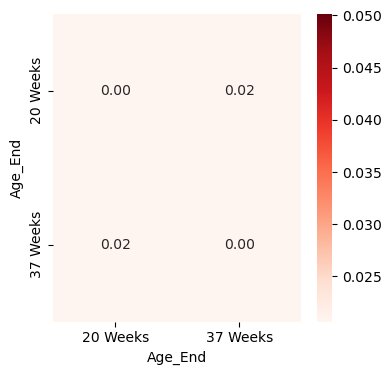

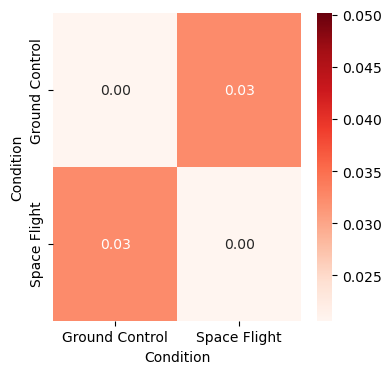

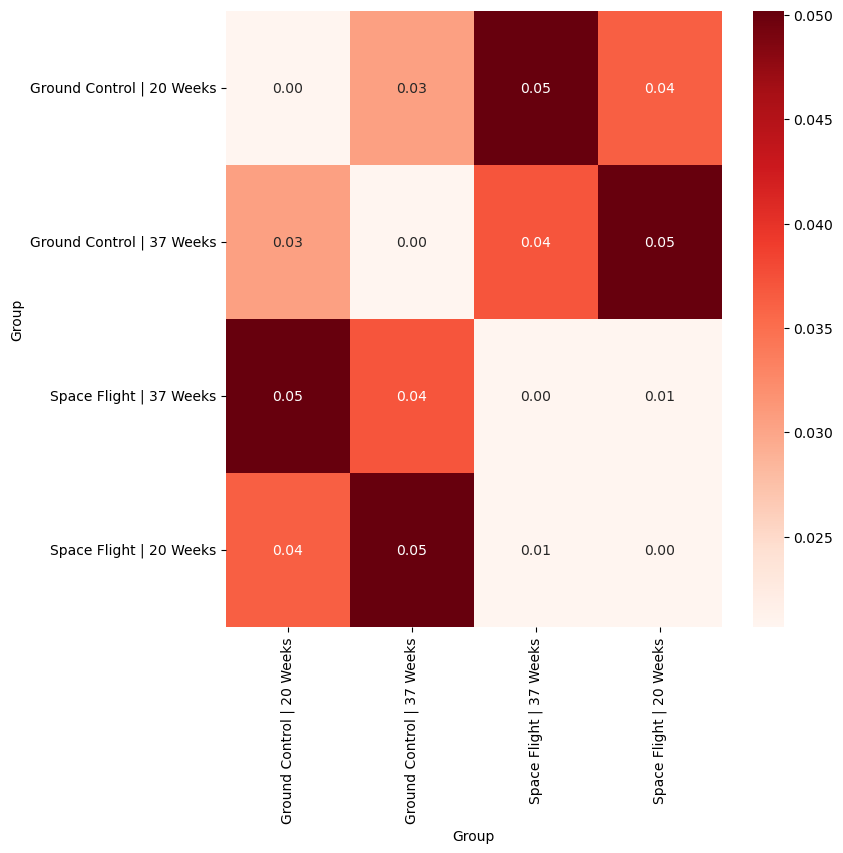



Just Senescence Genes




Output()

Output()

Output()

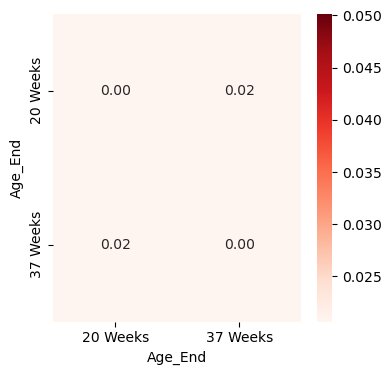

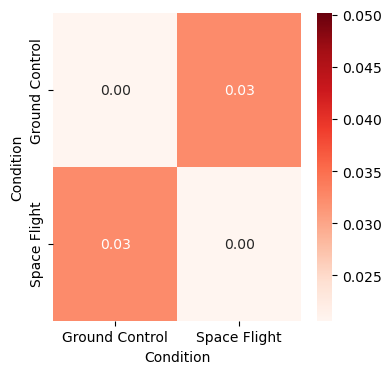

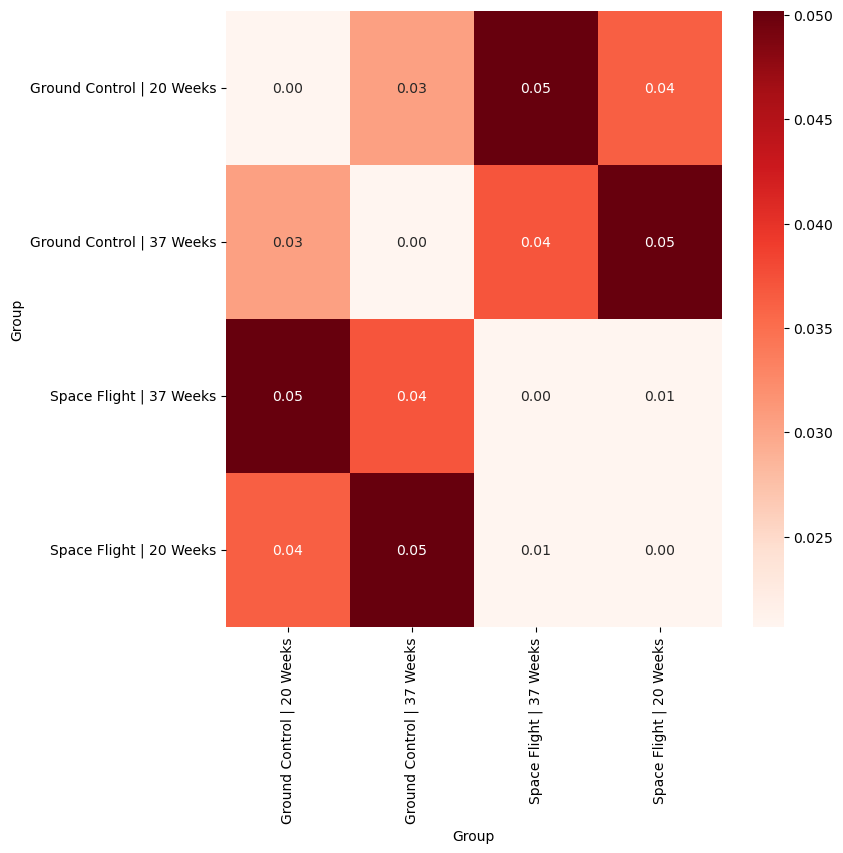

In [19]:
print(f"\n\n{'=' * 80}\nOverall Distance\n{'=' * 80}\n\n")
df_distance, figs_distance = scflow.ax.analyze_perturbation_distance(
    self.rna, col_condition=[col_age, col_condition, col_batch])

print(f"\n\n{'=' * 80}\nJust Senescence Genes\n{'=' * 80}\n\n")
df_distance_snc, figs_distance_snc = scflow.ax.analyze_perturbation_distance(
    self.rna[:, genes], col_condition=[
        col_age, col_condition, col_batch])

## Composition Analysis

### Cell Type

In [ ]:
# print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
# out_ctc = scflow.ax.analyze_composition(
#     self.rna, col_celltype, col_batch, col_sample=col_sample,
#     palette=palette[col_batch],
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[
#         col_batch]["key_control"]] + keys[col_batch]["key_treatment"])
# plt.show()

# print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
# out_ctc_sf = scflow.ax.analyze_composition(
#     self.rna[self.rna.obs[col_age] != keys[col_age]["key_control"]],
#     col_celltype, col_condition, col_sample=col_sample,
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[col_condition][
#         "key_control"]] + [keys[col_condition]["key_treatment"]])

### Senescent Cells

#### Tree-Aggregated

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|█| 12000/12000 [01:54<00:00, 104.99it/s, 31 steps of size 1.63e-01


                                          Compositional Analysis summary                                           
┌──────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────┐
│ Name                             │ Value                                                                        │
├──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────┤
│ Data                             │ Data: 18 samples, 12 cell types                                              │
│ Reference cell type              │ Neuron                                                                       │
│ Formula                          │ Condition                                                                    │
│ Reference index                  │ [3, 0]                                                                       │
│ MCMC Sampling                    │ Sampled 10000 chain states (2000 burnin samples)                             │
│ Acceptance rate                  │ 93.3%                                                                        │
└──────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                          2.299        2.014   2.588  0.155      410.043                               │
│ Endothelial                       -0.027       -0.487   0.458  0.250       40.055                               │
│ Microglial                         1.605        1.310   1.895  0.158      204.847                               │
│ Neuron                             4.495        4.265   4.739  0.127     3685.868                               │
│ OPC                                1.646        1.337   1.938  0.160      213.420                               │
│ Oligodendrocyte                    3.227        2.967   3.476  0.137     1037.180                               │
│ SnC Astrocyte                     -0.818       -1.263  -0.349  0.247       18.161                               │
│ SnC Endothelial                   -1.451       -1.914  -0.973  0.255        9.643                               │
│ SnC Microglial                    -1.078       -1.549  -0.628  0.248       14.003                               │
│ SnC Neuron                         0.492        0.117   0.853  0.196       67.307                               │
│ SnC OPC                           -1.221       -1.705  -0.767  0.250       12.137                               │
│ SnC Oligodendrocyte               -0.485       -0.906  -0.036  0.234       25.337                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Effect  Expected Sample  log2-fold change                                   │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte            0.000       410.043           0.000                                         │
│                Endothelial          0.000        40.055           0.000                                         │
│                Microglial           0.000       204.847           0.000                                         │
│                Neuron               0.000      3685.868           0.000                                         │
│                OPC                  0.000       213.420           0.000                                         │
│                Oligodendrocyte      0.000      1037.180           0.000                                         │
│                SnC Astrocyte        0.000        18.161           0.000                                         │
│                SnC Endothelial      0.000         9.643           0.000                                         │
│                SnC Microglial       0.000        14.003           0.000                                         │
│                SnC Neuron           0.000        67.307           0.000                                         │
│                SnC OPC              0.000        12.137           0.000                                         │
│                SnC Oligodendrocyte  0.000        25.337           0.000                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Median  HDI 3%  HDI 97%   SD                                                │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte            0.043   -0.185  0.226   0.108                                               │
│                Endothelial          0.012   -0.477  0.220   0.200                                               │
│                Microglial           0.069   -0.072  0.275   0.091                                               │
│                Neuron               0.000    0.000  0.000   0.000                                               │
│                OPC                  0.083   -0.096  0.279   0.098                                               │
│                Oligodendrocyte      0.105   -0.041  0.254   0.079                                               │
│                SnC Astrocyte        0.212   -0.074  0.551   0.167                                               │
│                SnC Endothelial      0.136   -0.130  0.435   0.148                                               │
│                SnC Microglial       0.144   -0.082  0.461   0.144                                               │
│                SnC Neuron           0.186   -0.054  0.528   0.162                                               │
│                SnC OPC              0.214   -0.100  0.542   0.171                                               │
│                SnC Oligodendrocyte  0.218   -0.076  0.550   0.167                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Condition[T.Space Flight]_node                                                                        │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Median  HDI 3%  HDI 97%  SD   Delta  Is credible                          │
│ Node                                                                                                            │
│ False                     0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ True                      0.00         0.08   -0.06    0.30   0.10  0.12      False                             │
│ Macroglia                 0.00         0.04   -0.08    0.14   0.06  0.12      False                             │
│ Neuron                    0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ Microglial                0.00         0.07   -0.07    0.28   0.09  0.12      False                             │
│ Endothelial               0.00         0.01   -0.48    0.22   0.20  0.12      False                             │
│ SnC Macroglia             0.00         0.06   -0.10    0.24   0.09  0.12      False                             │
│ SnC Neuron                0.00         0.08   -0.10    0.39   0.14  0.12      False                             │
│ SnC Endothelial           0.00         0.05   -0.15    0.26   0.11  0.12      False                             │
│ SnC Microglial            0.00         0.05   -0.14    0.27   0.10  0.12      False                             │
│ Oligodendrocyte           0.00         0.07   -0.04    0.21   0.07  0.12      False                             │
│ OPC                       0.00         0.05   -0.12    0.20   0.08  0.12      False                             │
│ Astrocyte                 0.00         0.02   -0.21    0.16   0.10  0.12      False                             │
│ SnC OPC                   0.00         0.05   -0.14    0.27   0.10  0.12      False                             │
│ SnC Oligodendrocyte       0.00         0.05   -0.12    0.26   0.10  0.12      False                             │
│ SnC Astrocyte             0.00         0.05   -0.14    0.26   0.10  0.12      False                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

Wrote file: /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/tree_effect.png
• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|█| 11000/11000 [02:00<00:00, 91.42it/s, 31 steps of size 1.18e-01.


                                          Compositional Analysis summary                                           
┌──────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────┐
│ Name                             │ Value                                                                        │
├──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────┤
│ Data                             │ Data: 18 samples, 12 cell types                                              │
│ Reference cell type              │ Neuron                                                                       │
│ Formula                          │ Condition + Age_End + Condition * Age_End                                    │
│ Reference index                  │ [3, 0]                                                                       │
│ MCMC Sampling                    │ Sampled 10000 chain states (1000 burnin samples)                             │
│ Acceptance rate                  │ 94.0%                                                                        │
└──────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                          2.613        2.322   2.929  0.161      460.187                               │
│ Endothelial                        0.131       -0.362   0.646  0.268       38.461                               │
│ Microglial                         1.780        1.458   2.106  0.172      200.063                               │
│ Neuron                             4.642        4.393   4.875  0.129     3500.401                               │
│ OPC                                1.953        1.615   2.257  0.170      237.848                               │
│ Oligodendrocyte                    3.549        3.272   3.815  0.145     1173.367                               │
│ SnC Astrocyte                     -0.753       -1.218  -0.271  0.255       15.889                               │
│ SnC Endothelial                   -1.423       -1.919  -0.898  0.270        8.131                               │
│ SnC Microglial                    -1.034       -1.526  -0.555  0.259       11.997                               │
│ SnC Neuron                         0.554        0.176   0.932  0.201       58.711                               │
│ SnC OPC                           -1.177       -1.670  -0.672  0.268       10.398                               │
│ SnC Oligodendrocyte               -0.403       -0.861   0.068  0.249       22.548                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       Effect  Expected Sample  log2-fold change                 │
│ Covariate                        Cell Type                                                                      │
│ T.Space Flight                   Astrocyte             0.000      460.187            0.000                      │
│                                  Endothelial           0.000       38.461            0.000                      │
│                                  Microglial            0.000      200.063            0.000                      │
│                                  Neuron                0.000     3500.401            0.000                      │
│                                  OPC                   0.000      237.848            0.000                      │
│                                  Oligodendrocyte       0.000     1173.367            0.000                      │
│                                  SnC Astrocyte         0.000       15.889            0.000                      │
│                                  SnC Endothelial       0.000        8.131            0.000                      │
│                                  SnC Microglial        0.000       11.997            0.000                      │
│                                  SnC Neuron            0.000       58.711            0.000                      │
│                                  SnC OPC               0.000       10.398            0.000                      │
│                                  SnC Oligodendrocyte   0.000       22.548            0.000                      │
│ Age_EndT.37 Weeks                Astrocyte            -0.328      364.769           -0.335                      │
│                                  Endothelial           0.000       42.320            0.138                      │
│                                  Microglial            0.000      220.140            0.138                      │
│                                  Neuron                0.000     3851.679            0.138                      │
│                                  OPC                  -0.328      188.531           -0.335                      │
│                                  Oligodendrocyte      -0.328      930.074           -0.335                      │
│                                  SnC Astrocyte         0.000       17.484            0.138                      │
│                                  SnC Endothelial       0.000        8.947            0.138                      │
│                                  SnC Microglial        0.000       13.201            0.138                      │
│                                  SnC Neuron            0.000       64.603            0.138                      │
│                                  SnC OPC               0.000       11.442            0.138                      │
│                                  SnC Oligodendrocyte   0.000       24.810            0.138                      │
│ T.Space Flight:Age_EndT.37 Weeks Astrocyte             0.000      460.187            0.000                      │
│                                  Endothelial           0.000       38.461            0.000                      │
│                                  Microglial            0.000      200.063            0.000                      │
│                                  Neuron                0.000     3500.401            0.000                      │
│                                  OPC                   0.000      237.848            0.000                      │
│                                  Oligodendrocyte      

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       Median  HDI 3%  HDI 97%   SD                              │
│ Covariate                        Cell Type                                                                      │
│ T.Space Flight                   Astrocyte             0.012  -0.189   0.169  0.092                             │
│                                  Endothelial          -0.025  -0.555   0.131  0.208                             │
│                                  Microglial            0.032  -0.080   0.286  0.097                             │
│                                  Neuron                0.000   0.000   0.000  0.000                             │
│                                  OPC                   0.037  -0.127   0.214  0.088                             │
│                                  Oligodendrocyte       0.076  -0.051   0.246  0.079                             │
│                                  SnC Astrocyte         0.116  -0.152   0.462  0.162                             │
│                                  SnC Endothelial       0.071  -0.178   0.400  0.146                             │
│                                  SnC Microglial        0.078  -0.141   0.411  0.146                             │
│                                  SnC Neuron            0.123  -0.094   0.502  0.167                             │
│                                  SnC OPC               0.119  -0.151   0.473  0.166                             │
│                                  SnC Oligodendrocyte   0.121  -0.155   0.460  0.162                             │
│ Age_EndT.37 Weeks                Astrocyte            -0.321  -0.533  -0.071  0.121                             │
│                                  Endothelial           0.002  -0.300   0.170  0.129                             │
│                                  Microglial           -0.017  -0.319   0.104  0.119                             │
│                                  Neuron                0.000   0.000   0.000  0.000                             │
│                                  OPC                  -0.319  -0.546  -0.049  0.130                             │
│                                  Oligodendrocyte      -0.348  -0.542  -0.158  0.102                             │
│                                  SnC Astrocyte         0.040  -0.263   0.313  0.147                             │
│                                  SnC Endothelial       0.038  -0.206   0.278  0.124                             │
│                                  SnC Microglial        0.036  -0.206   0.273  0.122                             │
│                                  SnC Neuron            0.078  -0.135   0.420  0.152                             │
│                                  SnC OPC               0.041  -0.261   0.322  0.147                             │
│                                  SnC Oligodendrocyte   0.030  -0.277   0.318  0.151                             │
│ T.Space Flight:Age_EndT.37 Weeks Astrocyte             0.011  -0.224   0.177  0.103                             │
│                                  Endothelial           0.003  -0.305   0.162  0.129                             │
│                                  Microglial            0.012  -0.164   0.168  0.081                             │
│                                  Neuron                0.000   0.000   0.000  0.000                             │
│                                  OPC                   0.031  -0.188   0.225  0.104                             │
│                                  Oligodendrocyte      

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Age_End[T.37 Weeks]_node                                                                              │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Median  HDI 3%  HDI 97%  SD   Delta  Is credible                          │
│ Node                                                                                                            │
│ False                     0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ True                      0.00         0.02   -0.11    0.19   0.07  0.15      False                             │
│ Macroglia                -0.33        -0.33   -0.55   -0.08   0.12  0.15       True                             │
│ Neuron                    0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ Microglial                0.00        -0.02   -0.32    0.10   0.12  0.15      False                             │
│ Endothelial               0.00         0.00   -0.30    0.17   0.13  0.15      False                             │
│ SnC Macroglia             0.00         0.01   -0.21    0.16   0.09  0.15      False                             │
│ SnC Neuron                0.00         0.04   -0.10    0.40   0.14  0.15      False                             │
│ SnC Endothelial           0.00         0.01   -0.18    0.21   0.10  0.15      False                             │
│ SnC Microglial            0.00         0.01   -0.20    0.19   0.10  0.15      False                             │
│ Oligodendrocyte           0.00         0.00   -0.22    0.12   0.09  0.15      False                             │
│ OPC                       0.00         0.01   -0.16    0.15   0.08  0.15      False                             │
│ Astrocyte                 0.00         0.01   -0.16    0.15   0.07  0.15      False                             │
│ SnC OPC                   0.00         0.01   -0.19    0.22   0.10  0.15      False                             │
│ SnC Oligodendrocyte       0.00         0.01   -0.22    0.19   0.11  0.15      False                             │
│ SnC Astrocyte             0.00         0.01   -0.19    0.21   0.10  0.15      False                             │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Condition[T.Space Flight]:Age_End[T.37 Weeks]_node                                                    │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Median  HDI 3%  HDI 97%  SD   Delta  Is credible                          │
│ Node                                                                                                            │
│ False                     0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ True                      0.00         0.03   -0.10    0.24   0.09  0.15      False                             │
│ Macroglia                 0.00         0.01   -0.14    0.13   0.07  0.15      False                             │
│ Neuron                    0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ Microglial                0.00         0.01   -0.16    0.17   0.08  0.15      False                             │
│ Endothelial               0.00         0.00   -0.30    0.16   0.13  0.15      False                             │
│ SnC Macroglia             0.00         0.01   -0.16   

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pertpy/tools/_coda/_base_coda.py:1990: PerformanceWarning: indexing past lexsort depth may impact performance.
  node_effs = data.uns["scCODA_params"]["node_df"].loc[(covariate + "_node",),].copy()
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pertpy/tools/_coda/_base_coda.py:2000: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaf_effs = eff_df.loc[(covariate,),].copy()
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pertpy/tools/_coda/_base_coda.py:1990: PerformanceWarning: indexing past lexsort depth may impact performance.
  node_effs = data.uns["scCODA_params"]["node_df"].loc[(covariate + "_node",),].copy()
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pertpy/tools/_coda/_base_coda.py:2000: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaf_effs = eff_df.loc[(covariate,),].copy()
/home/easlinger/miniconda3/e

Wrote file: /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/tree_effect.png
Wrote file: /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/tree_effect.png
Wrote file: /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/tree_effect.png


<Figure size 0x300 with 0 Axes>

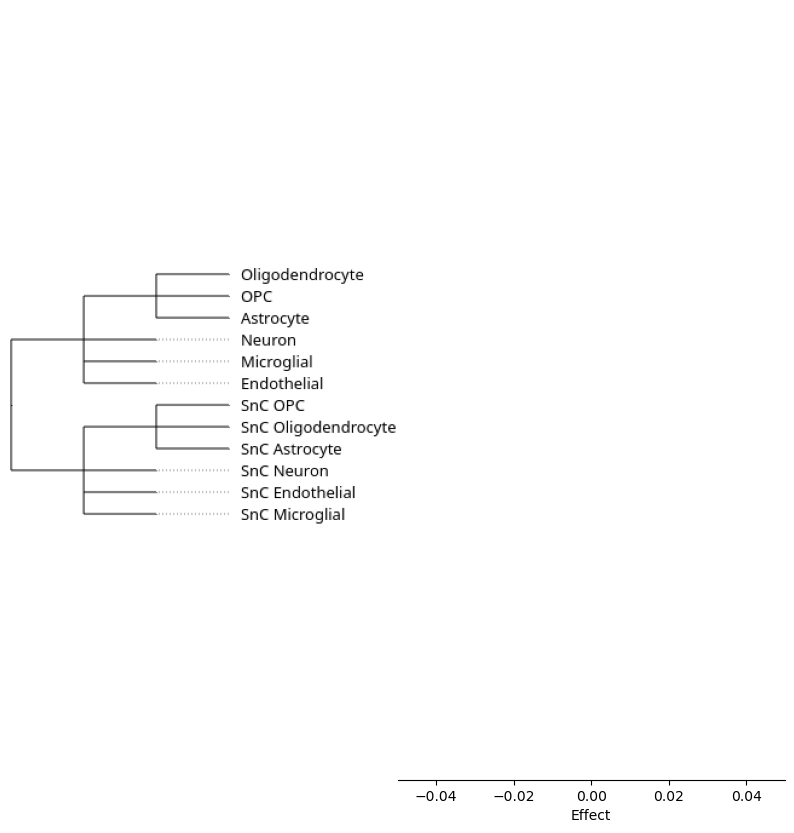

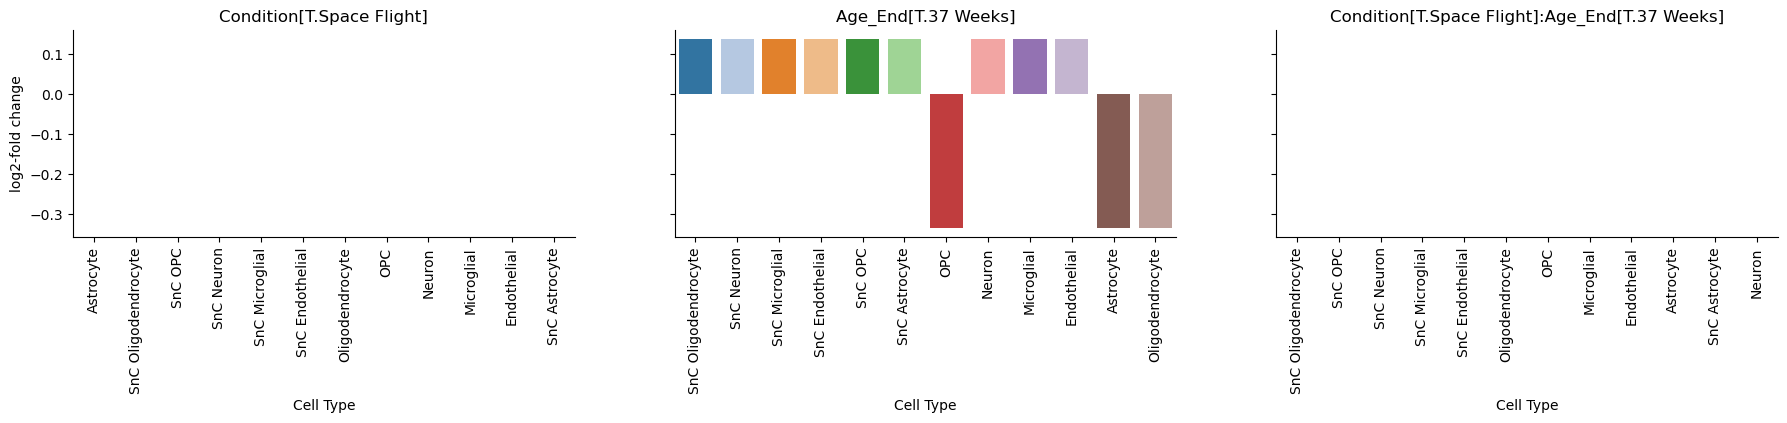

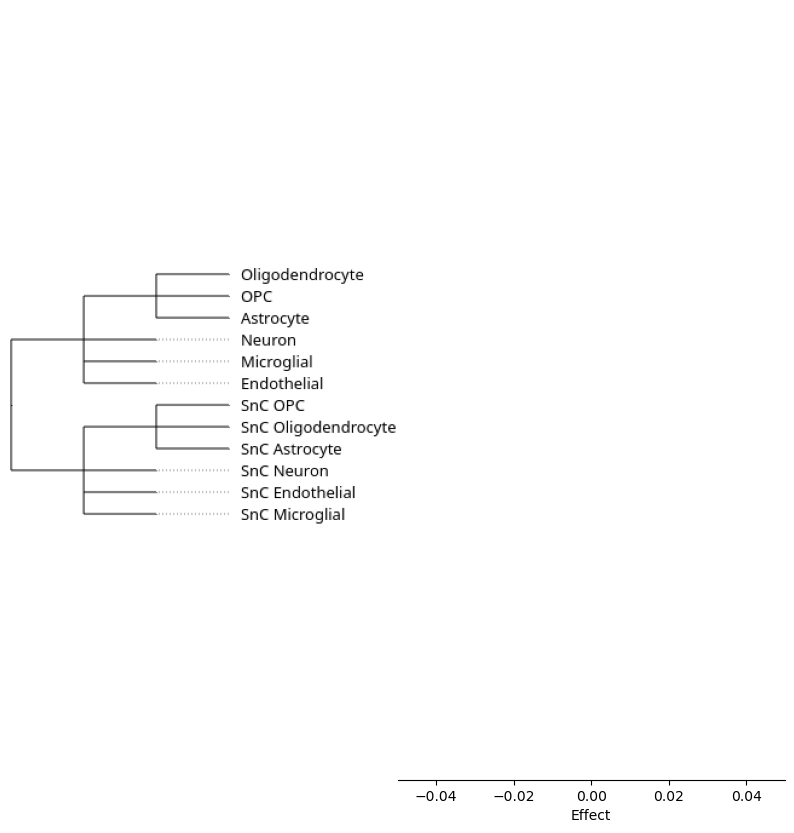

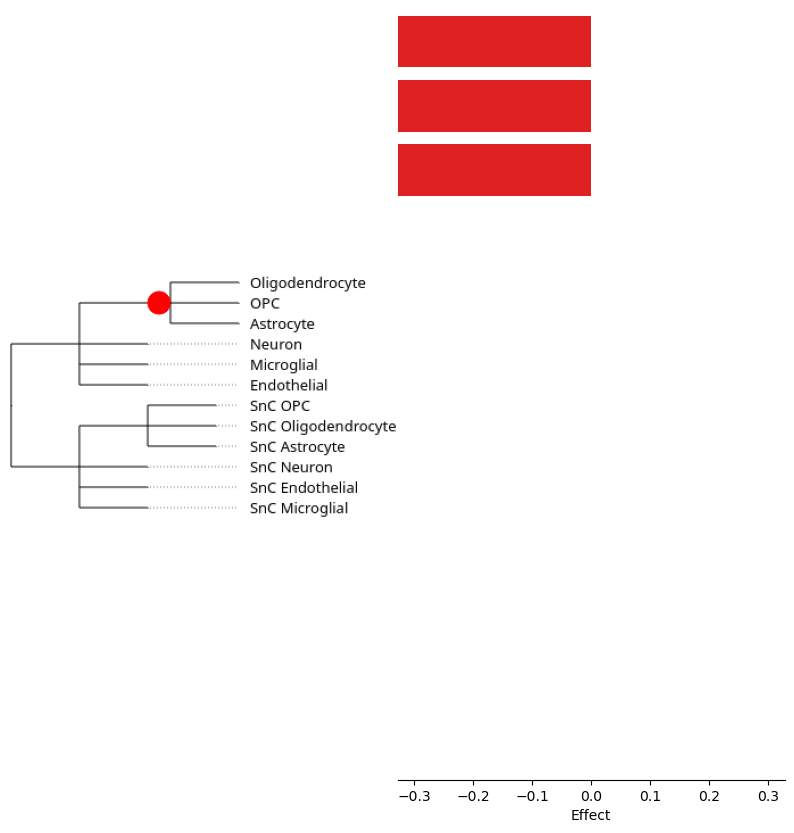

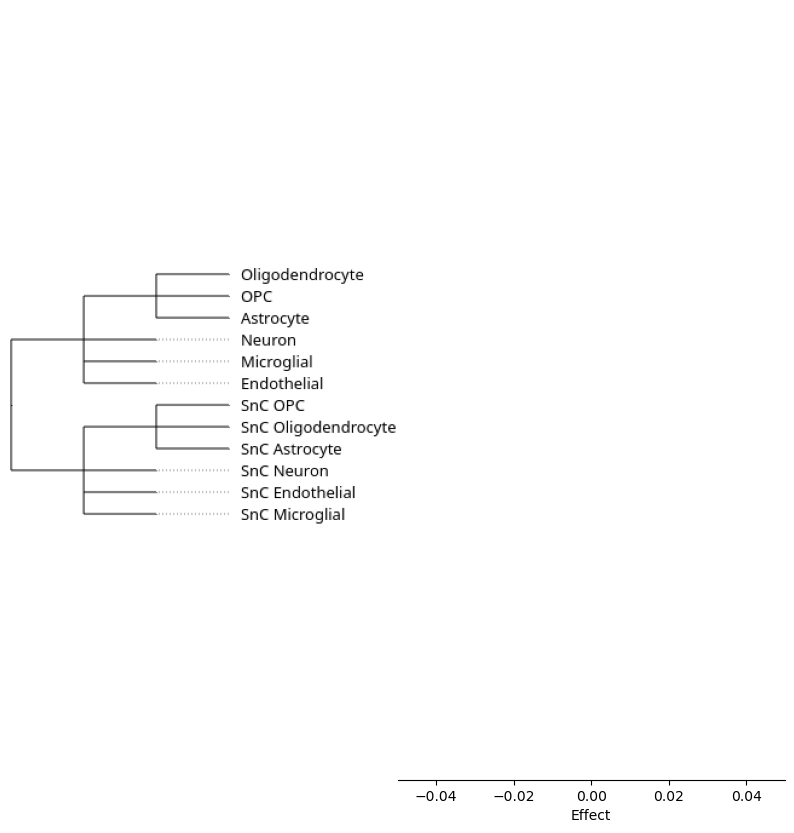

In [178]:
# Setup
# col_celltype_hierarchy = [
#     f"{col_celltype}_hierarchical", "SnC_hierarchy"]
col_celltype_hierarchy = [
    "Senescent_Cell", f"{col_celltype}_hierarchical", "SnC_hierarchy",
    "Senescent_Cell_Label_by_Type"]
# col_celltype_hierarchy = [
#     "Senescent_Cell_Label", f"SnC_hierarchy",
#     "Senescent_Cell_Label_by_Type"]
ref_celltype = self.rna.obs[col_celltype_hierarchy[-1]].value_counts(
    ).index.values[0]
form_c = " + ".join([col_condition, col_age]) + " + " + " * ".join([
    col_condition, col_age])

# By SF vs. GC (No Age)
_ = scflow.ax.analyze_composition_tree(
    self.rna, col_celltype_hierarchy[-1], col_condition,
    col_sample=col_sample, formula=None, seed=0, est_fdr=0.2,
    reference_cell_type=ref_celltype, num_warmup=2000,
    col_celltype_hierarchy=col_celltype_hierarchy)

# By SF & Age
_ = scflow.ax.analyze_composition_tree(
    self.rna, col_celltype_hierarchy[-1], [col_condition, col_age],
    formula=form_c, col_sample=col_sample, seed=0,
    reference_cell_type=ref_celltype, est_fdr=0.2,
    col_celltype_hierarchy=col_celltype_hierarchy)

#### `scCoda`

##### Just by Condition (By Cell Type)

In [ ]:
# for x in self.rna.obs[col_celltype].unique():
#     r_s, num_samples, num_warmup = 0, 10000, 2000  # defaults
#     if "annotation_scanvi" in col_celltype:  # avoid bad acceptance rates
#         r_s = 16 if x  == "OPC" else 8675309 if x in [
#             "Microglial"] else r_s  # different random seed
#         if x == "Endothelial":
#             r_s, num_samples, num_warmups = 7654321, 14000, 2000
#     print(f"Seed = {r_s}; {num_samples} samples; {num_samples} warmup")
#     out = scflow.ax.analyze_composition(
#         self.rna[self.rna.obs[col_celltype] == x],
#         "Senescent_Cell_Label_by_Type", col_condition,
#         col_sample=col_sample, formula=None, key_modality="coda",
#         full_hmc=False, palette=palette[col_condition], seed=r_s,
#         num_samples=10000, num_warmup=2000,
#         reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
#         level_order=[keys[col_condition]["key_control"], keys[
#             col_condition]["key_treatment"]])
#     f_sccoda_out = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc.pkl"
#     if overwrite is True or os.path.exists(f_sccoda_out) is False:
#         with open(f_sccoda_out, "wb") as f:
#             pickle.dump(out[0], f)
#         # out[1].write_h5mu(
#         #     f"outputs/sccoda_data_{col_celltype}_{x}_sfgc.h5mu")
#     plt.show()
#     del out

##### By Condition & Age



By Cell Type (by Group)


• Zero counts encountered in data! Added a pseudocount of 0.5.


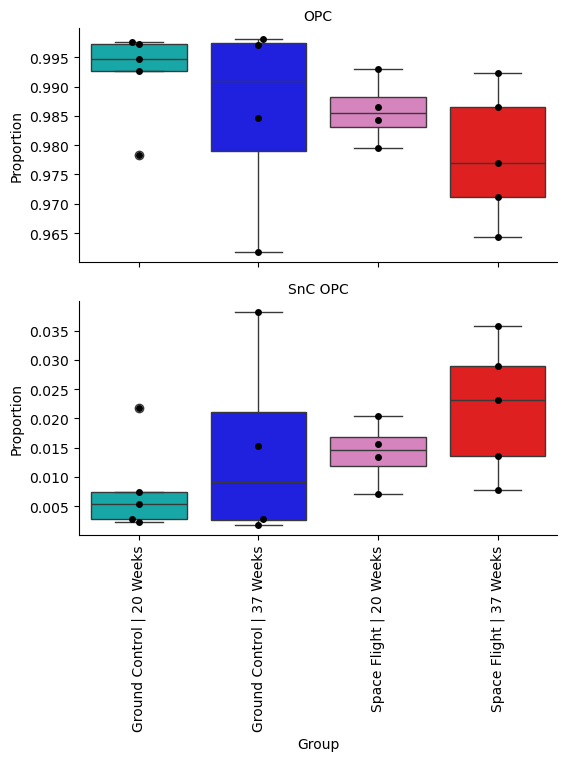

sample: 100%|█| 12000/12000 [41:24<00:00,  4.83it/s, 1023 steps of size 2.22e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ OPC                                                                     │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 81.0%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ OPC                               33.349       33.349  33.349  0.000     199.333                                │
│ SnC OPC                            2.026        2.026   2.026  0.000       0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks OPC             0.000          199.333              0.000                      │
│                                  SnC OPC         0.000            0.000              0.000                      │
│ GroupT.Space Flight | 20 Weeks   OPC             0.000          199.333              0.000                      │
│                                  SnC OPC        -0.001            0.000             -0.002                      │
│ GroupT.Space Flight | 37 Weeks   OPC             0.000            0.000           -124.658                      │
│                                  SnC OPC       117.730          199.333             45.190                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             HDI 3%  HDI 97%   SD   Inclusion probability                        │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC       NaN     NaN  0.000         0.000                                 │
│ GroupT.Space Flight | 20 Weeks   OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC    -0.001  -0.001  0.000         1.000                                 │
│ GroupT.Space Flight | 37 Weeks   OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC   117.691 117.691  0.000         1.000                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                     
OPC                                                                                                           
SnC OPC                                                                     *                                *




• Zero counts encountered in data! Added a pseudocount of 0.5.


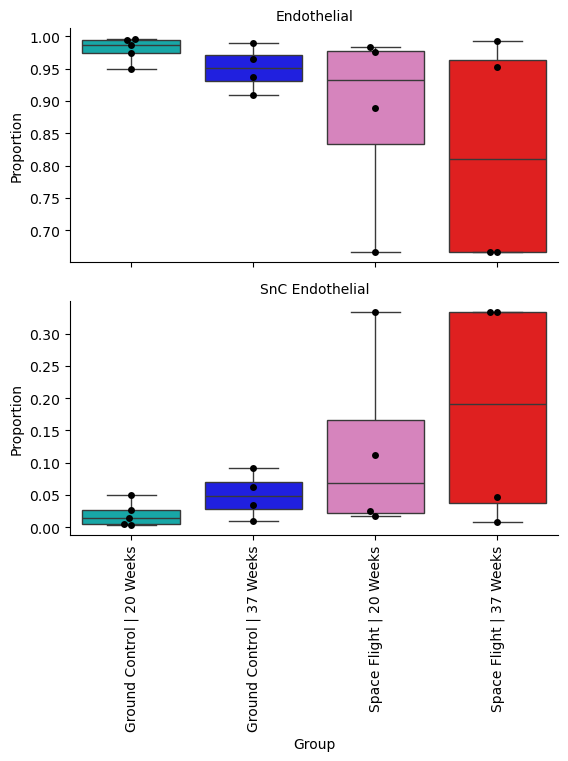

sample: 100%|█| 12000/12000 [38:40<00:00,  5.17it/s, 1023 steps of size 1.56e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 17 samples, 2 cell types                                          │
│ Reference cell type                   │ Endothelial                                                             │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 90.1%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Endothelial                       35.456       35.456  35.456  0.000      51.588                                │
│ SnC Endothelial                    3.752        3.752   3.752  0.000       0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                   Final Parameter  Expected Sample  log2-fold change            │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Endothelial           0.000           51.588             0.000                 │
│                                  SnC Endothelial       0.000            0.000             0.000                 │
│ GroupT.Space Flight | 20 Weeks   Endothelial           0.000           51.588             0.000                 │
│                                  SnC Endothelial       0.000            0.000             0.000                 │
│ GroupT.Space Flight | 37 Weeks   Endothelial           0.000            0.000           -26.114                 │
│                                  SnC Endothelial      49.805           51.588            45.739                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                   HDI 3%  HDI 97%   SD   Inclusion probability                  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial     NaN     NaN  0.000         0.000                           │
│ GroupT.Space Flight | 20 Weeks   Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial     NaN     NaN  0.000         0.000                           │
│ GroupT.Space Flight | 37 Weeks   Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial  49.805  49.805  0.000         1.000                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate       Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                           
Endothelial                                                                                                         
SnC Endothelial                                                                                                    *




• Zero counts encountered in data! Added a pseudocount of 0.5.


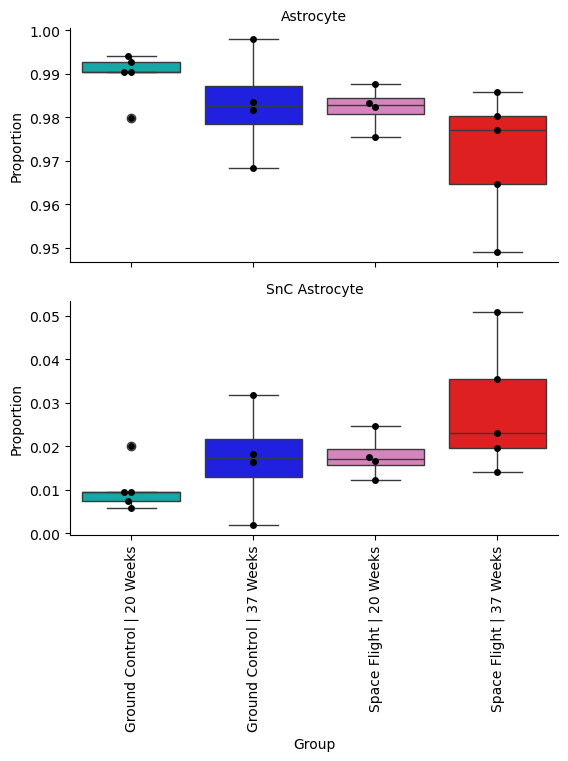

sample: 100%|█| 12000/12000 [03:41<00:00, 54.10it/s, 63 steps of size 4.11e-02.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Astrocyte                                                               │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.835                                                                   │
│ Spike-and-slab threshold              │ 0.835                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 79.5%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                         5.890        4.245   7.672   0.972     389.978                                │
│ SnC Astrocyte                     1.724        0.285   3.450   0.904       6.050                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                 Final Parameter  Expected Sample  log2-fold change              │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Astrocyte          0.000           389.978             0.000                   │
│                                  SnC Astrocyte      0.000             6.050             0.000                   │
│ GroupT.Space Flight | 20 Weeks   Astrocyte          0.000           389.978             0.000                   │
│                                  SnC Astrocyte      0.000             6.050             0.000                   │
│ GroupT.Space Flight | 37 Weeks   Astrocyte          0.000           384.531            -0.020                   │
│                                  SnC Astrocyte      0.656            11.497             0.926                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                 HDI 3%  HDI 97%   SD   Inclusion probability                    │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.493  0.575   0.163         0.363                             │
│ GroupT.Space Flight | 20 Weeks   Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.342  0.699   0.198         0.433                             │
│ GroupT.Space Flight | 37 Weeks   Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.014  1.212   0.394         0.835                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate     Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                         
Astrocyte                                                                                                         
SnC Astrocyte                                                                                                    *








By Cell Type (by Group)




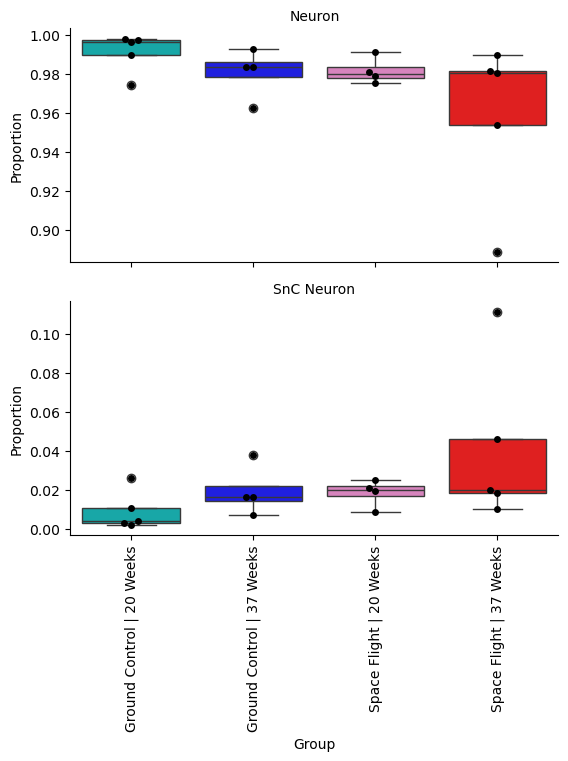

sample: 100%|█| 12000/12000 [03:25<00:00, 58.30it/s, 1 steps of size 4.16e-02. 


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Neuron                                                                  │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 76.0%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Neuron                            3.979         3.222  4.725   0.395     3787.418                               │
│ SnC Neuron                        0.124        -0.500  0.727   0.322       80.193                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              Final Parameter  Expected Sample  log2-fold change                 │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Neuron          0.000           3787.418           0.000                       │
│                                  SnC Neuron      0.000             80.193           0.000                       │
│ GroupT.Space Flight | 20 Weeks   Neuron          0.000           3787.418           0.000                       │
│                                  SnC Neuron      0.000             80.193           0.000                       │
│ GroupT.Space Flight | 37 Weeks   Neuron          0.000           3787.418           0.000                       │
│                                  SnC Neuron      0.000             80.193           0.000                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              HDI 3%  HDI 97%   SD    Inclusion probability                      │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Neuron       0.000   0.000   0.000         0.000                               │
│                                  SnC Neuron  -0.481   0.762   0.190         0.444                               │
│ GroupT.Space Flight | 20 Weeks   Neuron       0.000   0.000   0.000         0.000                               │
│                                  SnC Neuron  -0.525   0.737   0.198         0.358                               │
│ GroupT.Space Flight | 37 Weeks   Neuron       0.000   0.000   0.000         0.000                               │
│                                  SnC Neuron  -0.041  48.593  14.704         0.607                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate  Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                      
Neuron                                                                                                         
SnC Neuron                                                                                                     




• Zero counts encountered in data! Added a pseudocount of 0.5.


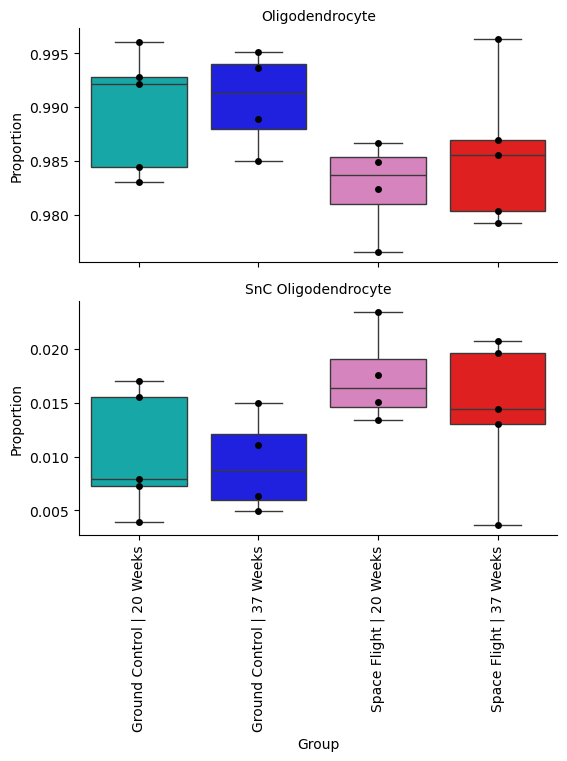

sample: 100%|█| 12000/12000 [03:46<00:00, 53.03it/s, 63 steps of size 4.15e-02.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Oligodendrocyte                                                         │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 76.2%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Oligodendrocyte                   6.802        5.160   8.430   0.976     1026.945                               │
│ SnC Oligodendrocyte               2.400        0.809   3.940   0.937       12.583                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       Final Parameter  Expected Sample  log2-fold change        │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Oligodendrocyte          0.000           1026.945           0.000              │
│                                  SnC Oligodendrocyte      0.000             12.583           0.000              │
│ GroupT.Space Flight | 20 Weeks   Oligodendrocyte          0.000           1026.945           0.000              │
│                                  SnC Oligodendrocyte      0.000             12.583           0.000              │
│ GroupT.Space Flight | 37 Weeks   Oligodendrocyte          0.000           1026.945           0.000              │
│                                  SnC Oligodendrocyte      0.000             12.583           0.000              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       HDI 3%  HDI 97%   SD   Inclusion probability              │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Oligodendrocyte       0.000  0.000   0.000         0.000                       │
│                                  SnC Oligodendrocyte  -0.689  0.175   0.178         0.395                       │
│ GroupT.Space Flight | 20 Weeks   Oligodendrocyte       0.000  0.000   0.000         0.000                       │
│                                  SnC Oligodendrocyte  -0.073  0.776   0.249         0.591                       │
│ GroupT.Space Flight | 37 Weeks   Oligodendrocyte       0.000  0.000   0.000         0.000                       │
│                                  SnC Oligodendrocyte  -0.108  0.739   0.226         0.539                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate           Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                               
Oligodendrocyte                                                                                                         
SnC Oligodendrocyte                                                                                                     




• Zero counts encountered in data! Added a pseudocount of 0.5.


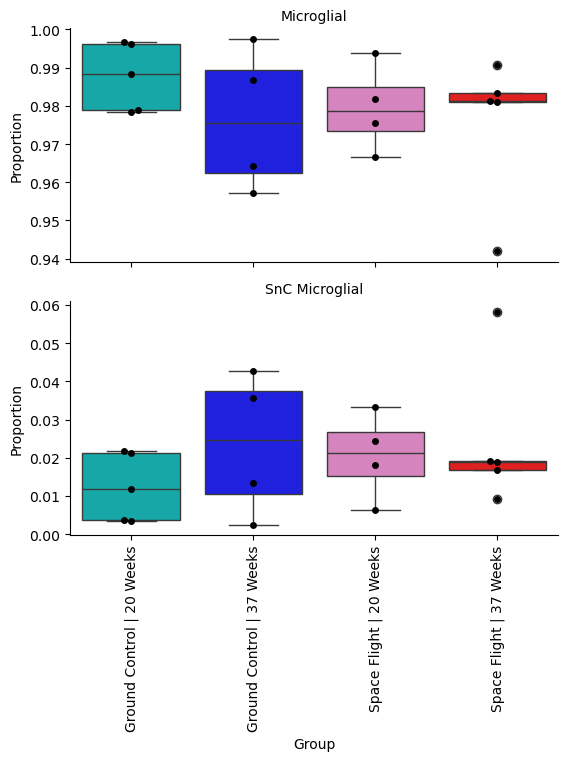

sample: 100%|█| 12000/12000 [33:55<00:00,  5.90it/s, 1023 steps of size 1.85e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Microglial                                                              │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 87.2%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Microglial                        35.771       35.771  35.771  0.000     186.722                                │
│ SnC Microglial                     2.377        2.377   2.377  0.000       0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  Final Parameter  Expected Sample  log2-fold change             │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Microglial           0.000            0.000           -67.961                  │
│                                  SnC Microglial      80.501          186.722            48.177                  │
│ GroupT.Space Flight | 20 Weeks   Microglial           0.000          186.722             0.000                  │
│                                  SnC Microglial       0.000            0.000             0.000                  │
│ GroupT.Space Flight | 37 Weeks   Microglial           0.000          186.722             0.000                  │
│                                  SnC Microglial       0.030            0.000             0.044                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  HDI 3%  HDI 97%   SD   Inclusion probability                   │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Microglial       0.000   0.000  0.000         0.000                            │
│                                  SnC Microglial  80.501  80.501  0.000         1.000                            │
│ GroupT.Space Flight | 20 Weeks   Microglial       0.000   0.000  0.000         0.000                            │
│                                  SnC Microglial     NaN     NaN  0.000         0.000                            │
│ GroupT.Space Flight | 37 Weeks   Microglial       0.000   0.000  0.000         0.000                            │
│                                  SnC Microglial   0.030   0.030  0.000         1.000                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate      Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                          
Microglial                                                                                                         
SnC Microglial                                  *                                                                 *




• Zero counts encountered in data! Added a pseudocount of 0.5.


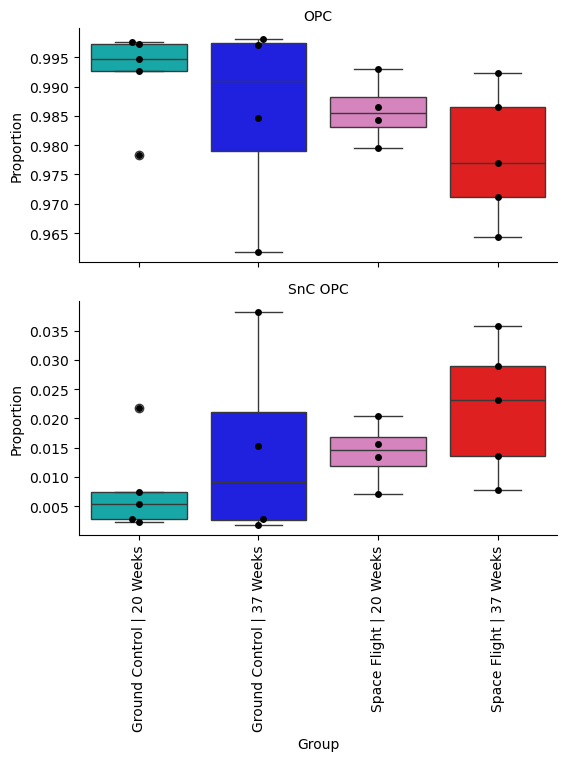

sample: 100%|█| 12000/12000 [37:43<00:00,  5.30it/s, 1023 steps of size 2.22e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ OPC                                                                     │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 81.0%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ OPC                               33.349       33.349  33.349  0.000     199.333                                │
│ SnC OPC                            2.026        2.026   2.026  0.000       0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks OPC             0.000          199.333              0.000                      │
│                                  SnC OPC         0.000            0.000              0.000                      │
│ GroupT.Space Flight | 20 Weeks   OPC             0.000          199.333              0.000                      │
│                                  SnC OPC        -0.001            0.000             -0.002                      │
│ GroupT.Space Flight | 37 Weeks   OPC             0.000            0.000           -124.658                      │
│                                  SnC OPC       117.730          199.333             45.190                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             HDI 3%  HDI 97%   SD   Inclusion probability                        │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC       NaN     NaN  0.000         0.000                                 │
│ GroupT.Space Flight | 20 Weeks   OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC    -0.001  -0.001  0.000         1.000                                 │
│ GroupT.Space Flight | 37 Weeks   OPC         0.000   0.000  0.000         0.000                                 │
│                                  SnC OPC   117.691 117.691  0.000         1.000                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                     
OPC                                                                                                           
SnC OPC                                                                     *                                *




• Zero counts encountered in data! Added a pseudocount of 0.5.


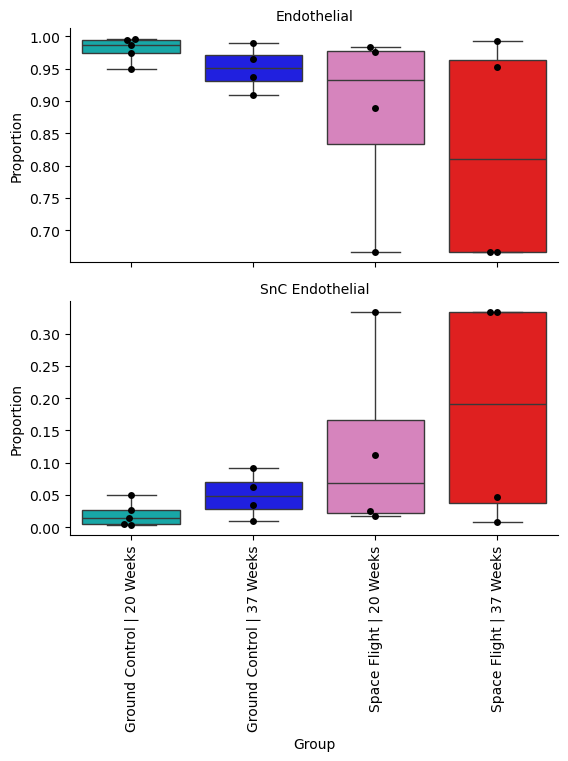

sample: 100%|█| 12000/12000 [38:58<00:00,  5.13it/s, 1023 steps of size 1.56e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 17 samples, 2 cell types                                          │
│ Reference cell type                   │ Endothelial                                                             │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 90.1%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Endothelial                       35.456       35.456  35.456  0.000      51.588                                │
│ SnC Endothelial                    3.752        3.752   3.752  0.000       0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                   Final Parameter  Expected Sample  log2-fold change            │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Endothelial           0.000           51.588             0.000                 │
│                                  SnC Endothelial       0.000            0.000             0.000                 │
│ GroupT.Space Flight | 20 Weeks   Endothelial           0.000           51.588             0.000                 │
│                                  SnC Endothelial       0.000            0.000             0.000                 │
│ GroupT.Space Flight | 37 Weeks   Endothelial           0.000            0.000           -26.114                 │
│                                  SnC Endothelial      49.805           51.588            45.739                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                   HDI 3%  HDI 97%   SD   Inclusion probability                  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial     NaN     NaN  0.000         0.000                           │
│ GroupT.Space Flight | 20 Weeks   Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial     NaN     NaN  0.000         0.000                           │
│ GroupT.Space Flight | 37 Weeks   Endothelial       0.000   0.000  0.000         0.000                           │
│                                  SnC Endothelial  49.805  49.805  0.000         1.000                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate       Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                           
Endothelial                                                                                                         
SnC Endothelial                                                                                                    *




• Zero counts encountered in data! Added a pseudocount of 0.5.


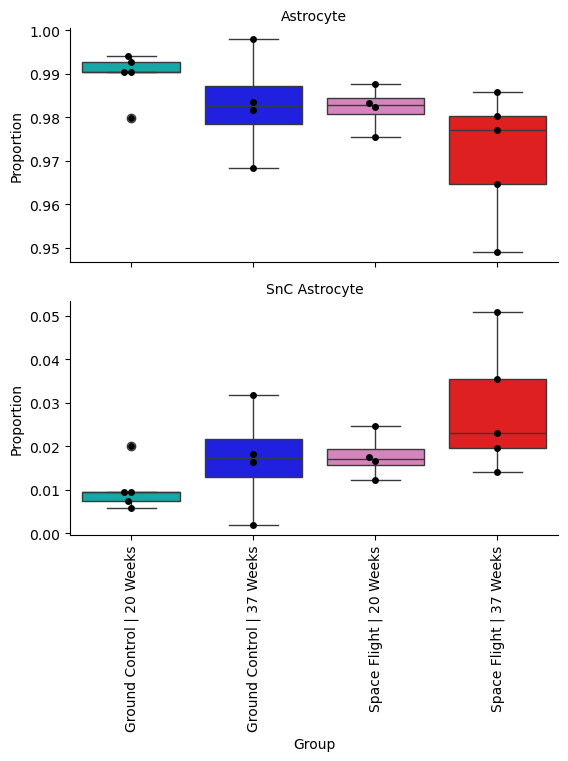

sample: 100%|█| 12000/12000 [03:40<00:00, 54.50it/s, 63 steps of size 4.11e-02.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Astrocyte                                                               │
│ Formula                               │ Group                                                                   │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.835                                                                   │
│ Spike-and-slab threshold              │ 0.835                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 79.5%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                         5.890        4.245   7.672   0.972     389.978                                │
│ SnC Astrocyte                     1.724        0.285   3.450   0.904       6.050                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                 Final Parameter  Expected Sample  log2-fold change              │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Astrocyte          0.000           389.978             0.000                   │
│                                  SnC Astrocyte      0.000             6.050             0.000                   │
│ GroupT.Space Flight | 20 Weeks   Astrocyte          0.000           389.978             0.000                   │
│                                  SnC Astrocyte      0.000             6.050             0.000                   │
│ GroupT.Space Flight | 37 Weeks   Astrocyte          0.000           384.531            -0.020                   │
│                                  SnC Astrocyte      0.656            11.497             0.926                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                 HDI 3%  HDI 97%   SD   Inclusion probability                    │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 37 Weeks Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.493  0.575   0.163         0.363                             │
│ GroupT.Space Flight | 20 Weeks   Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.342  0.699   0.198         0.433                             │
│ GroupT.Space Flight | 37 Weeks   Astrocyte       0.000  0.000   0.000         0.000                             │
│                                  SnC Astrocyte  -0.014  1.212   0.394         0.835                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate     Group[T.Ground Control | 37 Weeks] Group[T.Space Flight | 20 Weeks] Group[T.Space Flight | 37 Weeks]
Cell Type                                                                                                         
Astrocyte                                                                                                         
SnC Astrocyte                                                                                                    *






In [182]:
print(f"\n\n{'=' * 80}\nBy Cell Type (by Group)\n{'=' * 80}\n\n")
for x in self.rna.obs[col_celltype].unique():
    r_s = 1618
    if "annotation_scanvi" in col_celltype:
        r_s = 32145 if x in ["Neuron"] else 16 if x in [
            "Microglia", "OPC"] else r_s
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        "Senescent_Cell_Label_by_Type", col_batch, col_sample=col_sample,
        formula=None, key_modality="coda", full_hmc=False,
        palette=palette[col_batch], seed=r_s,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_batch]["key_control"]] + keys[
            col_batch]["key_treatment"])
    f_sccoda_out = f"outputs/sccoda_results_{col_celltype}_{x}.pkl"
    if overwrite is True or os.path.exists(f_sccoda_out) is False:
        with open(f_sccoda_out, "wb") as f:
            pickle.dump(out[0], f)
        # out[1].write_h5mu(f"outputs/sccoda_data_{col_celltype}_{x}.h5mu")
    plt.show()
    del out

# Reload
# out_ctc_ct = {}
# for x in self.rna.obs[col_celltype].unique():
#     with open(f"outputs/sccoda_results_{col_celltype}_{x}.pkl", "rb") as f:
#         tmp = pickle.load(f)
#     out_ctc_ct[x] = [tmp, mudata.read(
#         f"outputs/sccoda_data_{col_celltype}_{x}.h5mu")]
#     del tmp

##### Lower SnC Threshold

Cross-Tabs of Cell Counts in SnC Classifications with Top 1% Threshold versus Top 3%
Senescent_Cell_Label_by_Type  Senescent_Cell_Label_by_Type_senmayo_3
Astrocyte                     Astrocyte                                  6807
                              SnC Astrocyte                               200
Endothelial                   Endothelial                                 836
                              SnC Endothelial                              21
Microglial                    Microglial                                 3210
                              SnC Microglial                               87
Neuron                        Neuron                                    65616
                              SnC Neuron                                 2431
OPC                           OPC                                        3445
                              SnC OPC                                      93
Oligodendrocyte               Oligodendrocyte                     

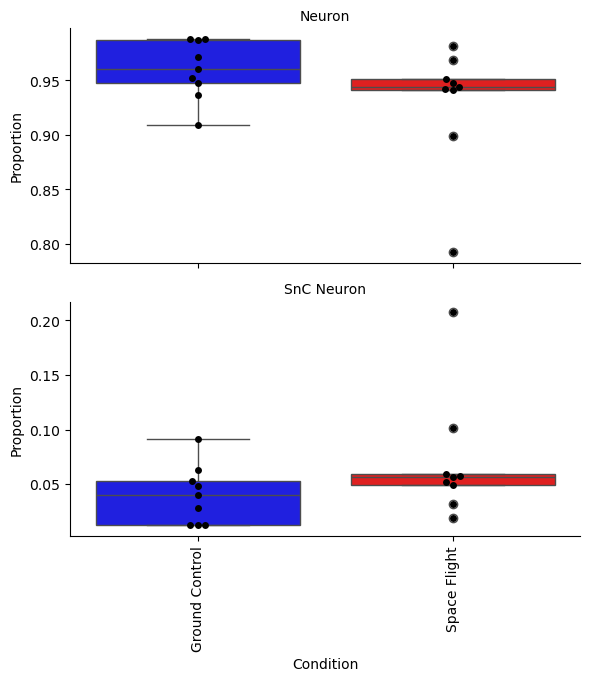

sample: 100%|█| 12000/12000 [34:25<00:00,  5.81it/s, 1023 steps of size 1.22e-1


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Neuron                                                                  │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 92.9%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                 │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ Neuron                                      37.299       37.299  37.299  0.000     3867.611                     │
│ SnC Neuron                                   0.055        0.055   0.055  0.000        0.000                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            Final Parameter  Expected Sample  log2-fold change                                   │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Neuron           0.000             0.000          -102.417                                       │
│                SnC Neuron     108.234          3867.611            53.732                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            HDI 3%  HDI 97%   SD   Inclusion probability                                         │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Neuron       0.000   0.000  0.000         0.000                                                  │
│                SnC Neuron 108.226 108.226  0.000         1.000                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate  Condition[T.Space Flight]
Cell Type                           
Neuron                              
SnC Neuron                         *






... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical


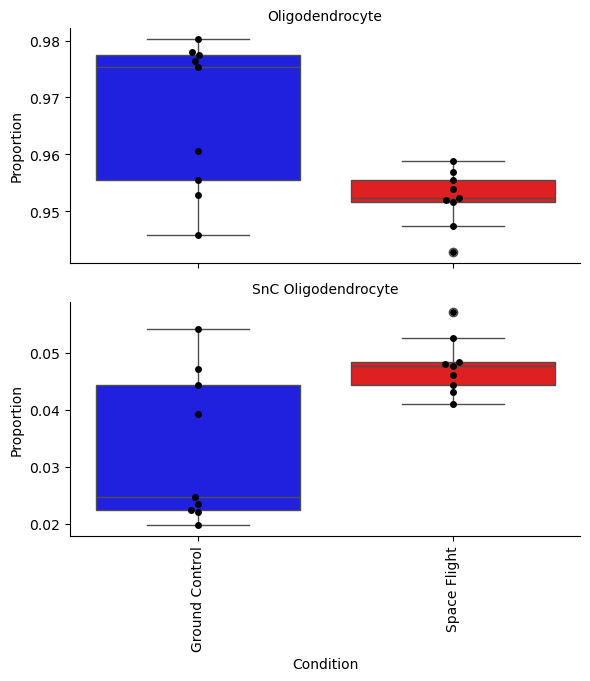

sample: 100%|█| 12000/12000 [01:33<00:00, 128.05it/s, 1 steps of size 6.01e-02.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Oligodendrocyte                                                         │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.908                                                                   │
│ Spike-and-slab threshold              │ 0.908                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 60.1%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD    Expected Sample                │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ Oligodendrocyte                             15.477       5.216   42.203  15.909     1039.487                    │
│ SnC Oligodendrocyte                          4.195       1.927    9.093   2.737        0.013                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Final Parameter  Expected Sample  log2-fold change                          │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Oligodendrocyte           0.000             0.000          -33.324                               │
│                SnC Oligodendrocyte      34.380          1039.500           16.277                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     HDI 3%  HDI 97%   SD    Inclusion probability                               │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Oligodendrocyte       0.000   0.000   0.000         0.000                                        │
│                SnC Oligodendrocyte  -0.008  39.799  73.660         0.908                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical




==================================================   Credible Effects   ==================================================

 Covariate           Condition[T.Space Flight]
Cell Type                                    
Oligodendrocyte                              
SnC Oligodendrocyte                         *




• Zero counts encountered in data! Added a pseudocount of 0.5.


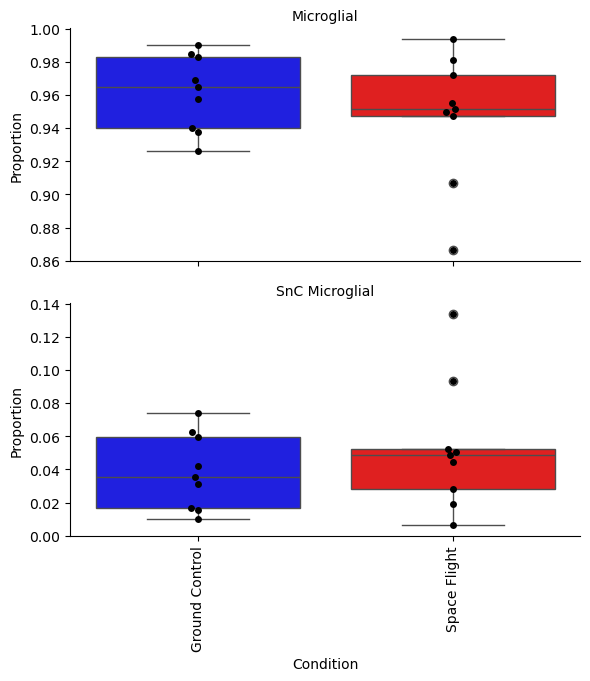

sample: 100%|█| 12000/12000 [00:26<00:00, 449.49it/s, 1 steps of size 1.14e-01.

! Acceptance rate unusually low (0.03040531919314433 < 0.5)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Microglial                                                              │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.979                                                                   │
│ Spike-and-slab threshold              │ 0.979                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 3.0%                                                                    │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                 │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ Microglial                                  4.245        4.251   4.251   0.109     179.269                      │
│ SnC Microglial                              1.061        1.062   1.062   0.090       7.425                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                Final Parameter  Expected Sample  log2-fold change                               │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Microglial           0.000            0.000           -154.907                                   │
│                SnC Microglial     110.598          186.694              4.652                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                HDI 3%  HDI 97%   SD    Inclusion probability                                    │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Microglial       0.000   0.000   0.000         0.000                                             │
│                SnC Microglial 112.415 112.415  21.132         0.979                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical




==================================================   Credible Effects   ==================================================

 Covariate      Condition[T.Space Flight]
Cell Type                               
Microglial                              
SnC Microglial                         *






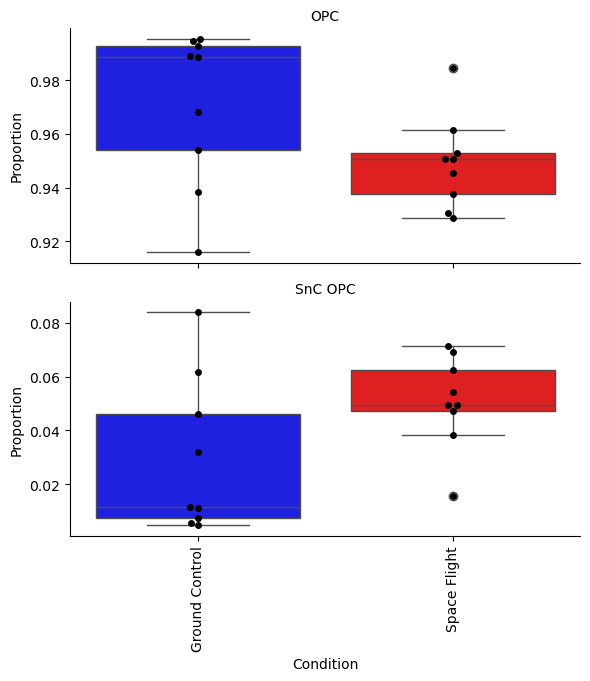

sample: 100%|█| 12000/12000 [28:53<00:00,  6.92it/s, 2 steps of size 2.90e-16. 


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ OPC                                                                     │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 84.5%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                 │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ OPC                                         36.278       36.278  36.278  0.000     199.222                      │
│ SnC OPC                                      2.366        2.366   2.366  0.000       0.000                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample  log2-fold change                                    │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight OPC             0.000            0.000           -69.174                                         │
│                SnC OPC        81.860          199.222            48.925                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           HDI 3%  HDI 97%   SD   Inclusion probability                                          │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight OPC         0.000   0.000  0.000         0.000                                                   │
│                SnC OPC    81.841  81.841  0.000         1.000                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical




==================================================   Credible Effects   ==================================================

 Covariate Condition[T.Space Flight]
Cell Type                          
OPC                                
SnC OPC                           *




• Zero counts encountered in data! Added a pseudocount of 0.5.


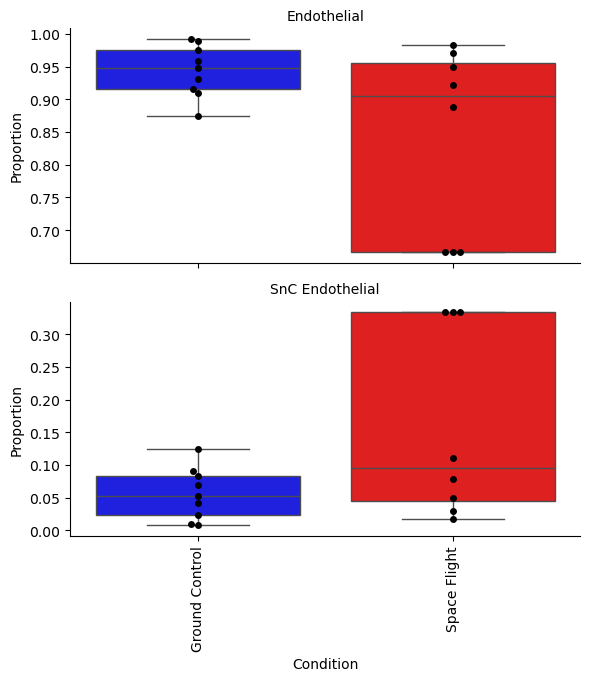

sample: 100%|█| 12000/12000 [36:01<00:00,  5.55it/s, 1023 steps of size 7.84e-1

! Acceptance rate unusually high (0.964199999960805 > 0.95)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 17 samples, 2 cell types                                          │
│ Reference cell type                   │ Endothelial                                                             │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 96.4%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                 │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ Endothelial                                 37.166       37.166  37.166  0.000      51.500                      │
│ SnC Endothelial                              5.894        5.894   5.894  0.000       0.000                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                 Final Parameter  Expected Sample  log2-fold change                              │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Endothelial           0.000            0.000           -257.519                                  │
│                SnC Endothelial     209.771           51.500             45.116                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                 HDI 3%  HDI 97%   SD   Inclusion probability                                    │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Endothelial       0.000   0.000  0.000         0.000                                             │
│                SnC Endothelial 209.771 209.771  0.000         1.000                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical




==================================================   Credible Effects   ==================================================

 Covariate       Condition[T.Space Flight]
Cell Type                                
Endothelial                              
SnC Endothelial                         *




• Zero counts encountered in data! Added a pseudocount of 0.5.


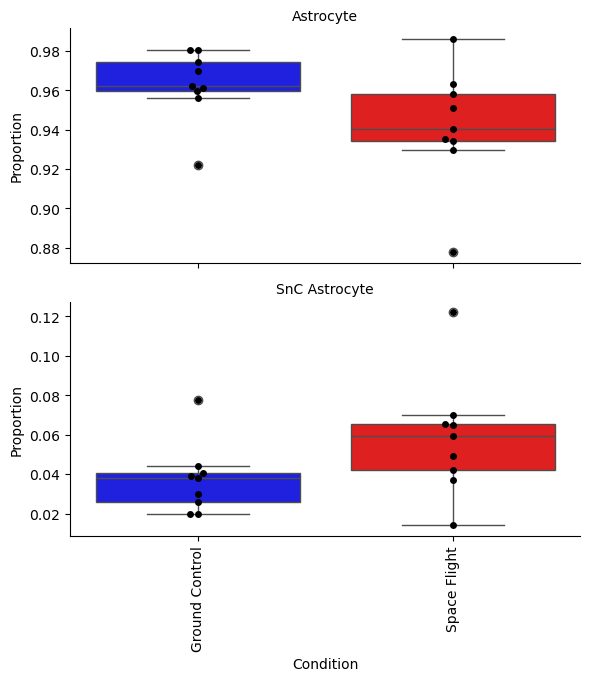

sample: 100%|█| 12000/12000 [00:38<00:00, 308.21it/s, 1 steps of size 6.60e-02.

! Acceptance rate unusually low (0.08084303939918638 < 0.5)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 18 samples, 2 cell types                                          │
│ Reference cell type                   │ Astrocyte                                                               │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.972                                                                   │
│ Spike-and-slab threshold              │ 0.972                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 8.1%                                                                    │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                         Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                 │
│ Senescent_Cell_Label_by_Type_senmayo_3                                                                          │
│ Astrocyte                                   4.831        4.598   5.163   0.190     377.317                      │
│ SnC Astrocyte                               1.827        1.442   1.915   0.164      18.711                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample  log2-fold change                                │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte           0.000            0.000           -87.241                                     │
│                SnC Astrocyte      63.523          396.028             4.404                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               HDI 3%  HDI 97%   SD    Inclusion probability                                     │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte      0.000    0.000   0.000         0.000                                              │
│                SnC Astrocyte  0.656   68.328  20.361         0.973                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

... storing 'rna:scCODA_sample_id' as categorical
... storing 'scCODA_sample_id' as categorical




==================================================   Credible Effects   ==================================================

 Covariate     Condition[T.Space Flight]
Cell Type                              
Astrocyte                              
SnC Astrocyte                         *






In [184]:
chp = f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"  # column name
print("Cross-Tabs of Cell Counts in SnC Classifications "
      f"with Top {percentile}% Threshold versus Top {p_h}%")
print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp]].value_counts(
    ).sort_index(), "\n\n")  # cross-tabs of higher vs. lower SnC threshold
# print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp, col_batch]].groupby(
#     col_batch).value_counts().unstack(0).replace(0, np.nan).dropna(
#         how="all", axis=0).astype(int).sort_index())  # cross-tabs by group
for x in self.rna.obs[col_celltype].unique():
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        chp, col_condition, col_sample=col_sample,
        formula=None, key_modality="coda", full_hmc=False,
        palette=palette[col_condition], seed=1618,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_condition]["key_control"], keys[
            col_condition]["key_treatment"]])
    f_sccoda = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc_{p_h}pct.pkl"
    if overwrite is True or os.path.exists(f_sccoda) is False:
        with open(f_sccoda, "wb") as f:
            pickle.dump(out[0], f)
        out[1].write_h5mu(
            f"outputs/sccoda_data_{col_celltype}_{x}_sfgc_{p_h}pct.h5mu")
    plt.show()
    del out

## Differential Gene Expression

Mainly using `edgeR`

### Pseudo-Bulk & Examine Covariates

In [ ]:
pdata = scflow.tl.create_pseudobulk(
    self.rna, [i for i in [col_sample, col_condition, col_age] if i],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pdata.layers["counts"] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e6)
sc.pp.log1p(pdata)
sc.pp.pca(pdata)
sc.pl.pca(pdata, color=pdata.obs, ncols=1, size=300)

### Overall DEGs by Groups

#### Age

**In older spaceflight mice compared to younger spaceflight mice**
* 9630013a20Rik (CNS myelination and neural tissue regeneration) is downregulated.
* mt-Td is upregulated.

In [ ]:
%matplotlib inline

# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Overall Sample\n\n")

# Ground Control Subset
print(f"\n\n{'=' * 80}\nGround Control Subset\n{'=' * 80}\n\n")
out_edgr_age_gc = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_control"]],
    col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Just Ground Control\n\n")

# Space Flight Subset
print(f"\n\n{'=' * 80}\nSpace Flight Subset\n{'=' * 80}\n\n")
out_edgr_age_sf = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_treatment"]],
    col_age, col_covariate=None, formula=None, **keys[col_age],
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype,
    col_sample=col_sample, fig_title="Age DEGs: Just Space Flight\n\n")

#### Condition

```
out_edgr_con_o[0][(out_edgr_con_o[0].adj_p_value < 0.01) & (
    out_edgr_con_o[0].abs_log_fc > 0.5)].sort_values(
        "abs_log_fc", ascending=False)
```

Among the older mice, *Mir6236* was differentially highly expressed in aged spaceflight mice compared to ground control mice (LFC=1.95, adjusted p=2.61e-13 in the overall sample; LFC=2.11, adjusted p=0.000015 in the aged subset). Suppression of this gene has been linked to neuronal morphogenesis (https://pubs.acs.org/doi/abs/10.1021/acsabm.0c01389) and therefore may represent a candidate intervention target. 

*Il31ra*, which has been linked to neuroinflammation (https://advanced.onlinelibrary.wiley.com/doi/pdfdirect/10.1002/advs.202409086), was also more highly expressed in spaceflight mice compared to ground control mice (LFC=1.52, adjusted p<0.001 in the overall sample; LFC=1.53, adjusted p<0.001 in the aged subset).

*UBA52*, also more highly expressed in spaceflight mice (LFC=1.43, adjusted p<0.001 in the overall sample; LFC=1.45, adjusted p<0.001 in the aged subset), may serve a neuroprotective role: It has been shown underexpressed in PD (https://www.mdpi.com/2073-4409/11/23/3770) and plays a role in neuroautophagy (https://www.tandfonline.com/doi/pdf/10.1080/15548627.2024.2395727). Likewise, *Pomp*, a gene associated with oxidative stress resistance and protein clearance [CITATION] was also more highly expressed in spaceflight mice. In contrast to past observations of downregulation of *Uqcr11* in Alheimer's (https://www.benthamdirect.com/content/journals/car/10.2174/1567205014666170505095921), that gene was differentially highly expressed in spaceflight mice (LFC=1.23 aged subset; LFC=1.44 overall; p<0.001); however, *Cmss1*, which has been associated with Alzheimer's in APOE4 mice (https://pmc.ncbi.nlm.nih.gov/articles/PMC8064208/), was also more highly expressed in spaceflight mice.

Genes involved in oxidative phosphorylation and the electron transport chain, including *Atp5e*, *Ndufa12*, and *Uqcr11* were also more highly expressed in spaceflight mice. *Uqcr11* has shown an anti-apoptotic and oxidative stress alleviation role in mice (https://www.mdpi.com/2073-4425/16/5/526).

*Tpt1* and *Rn7sk* were also upregulated in spaceflight mice. *Tpt1*, which is associated with cancer progression, anti-apoptosis, and cell stress response, has been shown to have a potentially bi-directional relationship with cell cycle control gene and canonical senescence marker *TP53* (https://www.tandfonline.com/doi/pdf/10.4161/cc.25404). *Rn7sk* is associated with cellular senescence (https://onlinelibrary.wiley.com/doi/abs/10.1002/jcp.28119) and Alzheimer's (https://www.nature.com/articles/s41598-024-82490-9.pdf).

---

*Pvalb* overall sample (LFC=1.61, p=1.25e-11)

*Trim17*

*Cck*

*Pam16*

---

*Mitochondrial/electron transport chain genes whose upregulation has been linked to Parkinson's disease (https://pmc.ncbi.nlm.nih.gov/articles/PMC10259399/pdf/AMS-19-3-131629.pdf) and/or adaptive responses to neurodegeneration in Alheimer's mouse models (https://journals.sagepub.com/doi/abs/10.1177/13872877251314847), including *mt-Atp6*, *mt-Co1*, *mt-Cytb* *mt-Nd2*, and *mt-Nd5*, *mt-Nd6...pregulation of *mt-Rnr1*, which also showed higher expression in spaceflight aged mice, has been seen in response to ionizing radiation, possibly reflecting increased mitochonrial biogenesis as an adaptive stress response (https://pmc.ncbi.nlm.nih.gov/articles/PMC5555881)** 

In [ ]:
# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_con = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Overall Sample)\n\n")
out_edgr_con_df = out_edgr_con[0][out_edgr_con[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goe = out_edgr_con_df.variable[:10].to_list()
print(out_edgr_con_df.iloc[:min(100, out_edgr_con_df.shape[0])], "\n\n", goe)
plt.show()

# Just Old
print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
out_edgr_con_o = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]],
    col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Just Aged)\n\n")
plt.show()
out_edgr_con_o_df = out_edgr_con_o[0][out_edgr_con_o[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goes = out_edgr_con_o_df.variable[:10].to_list()
print(out_edgr_con_o_df, "\n\n", goes)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch, layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"), genes=goes)
out_edgr_old_sf_v_gc = out_edgr_con_o_df[0][(
    out_edgr_con_o_df[0].abs_log_fc > 1) & (
        out_edgr_con_o_df[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_old_sf_v_gc = out_edgr_old_sf_v_gc.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
out_edgr_con_compare = out_edgr_con_o_df.set_index("variable")[[
    "log_fc", "adj_p_value"]].join(out_edgr_con_df.set_index("variable")[[
        "log_fc", "adj_p_value"]], how="inner", lsuffix="_Aged_Subset",
                                   rsuffix="_Overall_Sample")
out_edgr_con_compare

#### Age x Condition

Spaceflight effect (main analysis), can visualize at different ages

*Chchd2* (related to oxidative phosphorylation, cell migration, apoptosis inhibition, COX regulation, stress adaptation, Parkinson's, Lewy Body diseases, and cancer) was more highly expressed in spaceflight mice (and demonstrated a bigger young versus old difference in spaceflight mice).
Spaceflight mice also showed higher expression of several ribosomal proteins (*Rps16*, *Rpl31*, *Rpl17*, *Rpl9*, *Rpl15*, *Rps15a*, *Rpl19*, *Rps7*, *Rps23*, *Rpl37*, *Rps3a1*, *Rpl29*, *Rps15*, *Rps14*).

*Ndufa4* was also more highly expressed (implicated in cancer and mitochondrial dysfunction, part of the cytochrome c oxidase complex which drives oxidative phosphorylation, adaptation to hypoxia via downregulation of oxygen consumption and suppression of mitochondrial ROS production https://www.cell.com/cell-metabolism/fulltext/S1550-4131(11)00394-9?mobileUi=0) in spaceflight mice, as were other genes involved in ATP production/the electron transport chain and oxidative phosophorylation, including *Cox7a2*, *Uqcr11*, *Ndufa12*, *Ndufa4*, *Ndufc1*, *Atp5o-1*, *Atp5e*, and *Uqcrh* (which additionally has been implicated in tumor suppression https://aacrjournals.org/cancerres/article/80/16_Supplement/4795/643367).


In [ ]:
# With Single Label for Age x Condition
print(f"\n\n{'=' * 80}\nGroup (Single Factor)\n{'=' * 80}\n\n")
out_edgr_groups = scflow.ax.run_deg_edgr(
    self.rna, col_batch, col_covariate=None, formula=None,
    **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
plt.show()
# _ = self.plot(kind="violin", col_celltype=col_batch,
#               genes=list(out_edgr_groups[0].variable[:25]), layer="scaled",
#               violin=dict(col_wrap=4, hspace=1, rotation=45))
out_edgr_batches = out_edgr_groups[0][(out_edgr_groups[0].abs_log_fc > 1) & (
    out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
        "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])

# With Contrasts (Age & Condition = Separate Factors)
print(f"\n\n{'=' * 80}\nAge * Condition (2-Factor Contrast)\n{'=' * 80}\n\n")
out_edgr_contrasts = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=col_age, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch,
    genes=out_edgr_contrasts[0][out_edgr_contrasts[
        0].adj_p_value < 0.001].sort_values(
            "abs_log_fc", ascending=False).variable[:10], layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"))

# Condition x Age
# Vulnerability of mice who were older at launch to spaceflight stress
out_edgr_contrasts_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=col_condition, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)

#### Senescence Gene Contrasts Results

In [ ]:
# Genes
sen_genes_in_contrasts = list(set(genes).intersection(
    out_edgr_contrasts[0].variable.unique()))  # senescence genes in contrasts
out_edgr_snc = out_edgr_contrasts[0].set_index(
    "variable").loc[sen_genes_in_contrasts]  # contrast results for snc genes
res_snc_contrast = out_edgr_snc[out_edgr_snc.adj_p_value < 0.01]  # p < 0.01
sig_contrast_genes = list(res_snc_contrast.index.values)  # significant genes

# Plots By Groups; Axis by Cell Types
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_celltype,
              by_group=col_batch, **kws)

# Plots By Cell Types; Axis by Groups
# kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)),
#            violin=dict(figsize=(30, 20), col_wrap=4, xlabel=None,
#                        rotation=45, hspace=1, top=0.95))
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_batch,
              by_group=col_celltype, **kws)

# Results
print(f"\n{'=' * 80}\nSignificant Senescence Gene Contrasts\n{'=' * 80}\n")
print(sig_contrast_genes)
res_snc_contrast

### Snc versus Not (Group=Covariate)

In [ ]:
# Group = Covariate
out_edgr_contrasts_snc = scflow.ax.run_deg_edgr(
    self.rna, "Senescent_Cell_Label",
    col_covariate=col_batch, formula=None,
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)

### SnC versus Not SnC (Group=Subset)

In [ ]:
# Aged Subset
subset_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]

# Old Ground Control SnCs
print(f"\n\n{'=' * 80}\nGround Control (Aged)\n{'=' * 80}\n\n")
subset_gc = self.rna.obs[col_condition] == keys[
    col_condition]["key_control"]
out_edgr_contrasts_snc_gc = scflow.ax.run_deg_edgr(
    self.rna[subset_gc & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", top=0.92,
    key_control="Non-Senescent", log2fc_thresh=0, n_top_vars=24,
    xlabel_rotation=45, hspace=0.5, wspace=0.2, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_gc & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_1 = self.rna[subset_gc & subset_old].obs[col_batch].unique()[0]

# Old Spaceflight SnCs
print(f"\n\n{'=' * 80}\nSpaceflight (Aged)\n{'=' * 80}\n\n")
subset_sf = self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]
out_edgr_contrasts_snc_sf = scflow.ax.run_deg_edgr(
    self.rna[subset_sf & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_sf & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_2 = self.rna[subset_sf & subset_old].obs[col_batch].unique()[0]

# Compare
res_snc_gc = out_edgr_contrasts_snc_gc[0][out_edgr_contrasts_snc_gc[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_sf = out_edgr_contrasts_snc_sf[0][out_edgr_contrasts_snc_sf[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_grps = pd.concat([
    res_snc_gc, res_snc_sf], keys=[key_1, key_2], names=[col_condition])
res_snc_grps = res_snc_grps[res_snc_grps.abs_log_fc >= 1]
# top_tx_g_snc = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].sort_values("abs_log_fc", ascending=False).index
# print(res_snc_grps.unstack(0).replace(np.nan, "")[[
#     "log_fc", "adj_p_value"]].loc[top_tx_g_snc])
# just_sf = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_control"]].index)
# just_gc = res_snc_grps.loc[keys[col_condition][
#     "key_control"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_treatment"]].index)
# print(res_snc_grps.loc[:, just_gc, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]], "\n\n")
# res_snc_grps.loc[:, just_sf, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]]
res_snc_grps.unstack(0).replace(np.nan, "")[["log_fc", "adj_p_value"]]

### Group DEGs (SnC=Covariate)

In [ ]:
out_edgr_contrasts_snc_cov = {}
for a in self.rna.obs[col_age].unique():
    print(f"\n\n{'=' * 80}\nAge = {a}\n{'=' * 80}\n\n")
    out_edgr_contrasts_snc_cov[a] = scflow.ax.run_deg_edgr(
        self.rna[self.rna.obs[col_age] == a], col_condition,
        col_covariate="Senescent_Cell_Label",
        **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
        xlabel_rotation=45, hspace=0.5, wspace=0.2, top=0.85,
        legend_loc="upper right", col_celltype=col_celltype,
        col_sample=col_sample)
    plt.show()

### Group DEGs (SnC=Subset)

##### All Groups SnCs

In [ ]:
out_edgr_groups_snc = scflow.ax.run_deg_edgr(
    self.rna[(self.rna.obs["Senescent_Cell_Label"] == "Senescent")],
    col_batch, **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
out_edgr_batches_snc = out_edgr_groups[0][(
    out_edgr_groups[0].abs_log_fc > 1) & (
        out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
plt.show()

##### Just Aged SnCs

In [ ]:
out_edgr_contrasts_sncto, snc_degs_by_condition_age_ct = {}, {}
thresh_p_c, thresh_lfcabs_c = 0.05, 0.5  # thresholds
subs_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]
subs_sf = self.rna.obs[col_condition] == keys[col_condition]["key_treatment"]
# subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (
#     subs_old | subs_sf)
subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (subs_old)
out_edgr_contrasts_sncto["Overall"] = scflow.ax.run_deg_edgr(
        self.rna[subs_ac], col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Overall",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
plt.show()
tmp = out_edgr_contrasts_sncto["Overall"][0]
tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
    tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
snc_degs_by_condition_age_ct["Overall"] = list(
    tmp.sort_values("adj_p_value", ascending=True).variable)
for x in self.rna.obs[col_celltype].unique():
    print(x)
    out_edgr_contrasts_sncto[x] = scflow.ax.run_deg_edgr(
        self.rna[(subs_ac) & (self.rna.obs[col_celltype] == x)],
        col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Senescent {x}",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
    plt.show()
    tmp = out_edgr_contrasts_sncto[x][0]
    tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
        tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
    snc_degs_by_condition_age_ct[x] = list(tmp.sort_values(
            "adj_p_value", ascending=True).variable)
    del tmp
out_edgr_contrasts_snc_all_top = pd.concat([out_edgr_contrasts_sncto[x][
    0].set_index("variable").loc[snc_degs_by_condition_age_ct[
        x]] for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                           names=[col_celltype])
out_edgr_contrasts_snc_all = pd.concat([
    out_edgr_contrasts_sncto[x][0].set_index("variable")
    for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                       names=[col_celltype])
out_edgr_contrasts_snc_all_top

### More Specific Contrasts (`pyDESeq2`)

#### Group

In [ ]:
# pdata =  scflow.tl.create_pseudobulk(
#     self.rna, [col_sample, col_condition, col_age],
#     col_celltype, layer="counts", mode="sum")
# design = f"~{col_condition} + {col_age} + {col_condition} * {col_age}"
# # edgr = pt.tl.EdgeR(pdata, design=design)
# pds2 = pt.tl.PyDESeq2(adata=pdata, design=design)
# pds2.fit()
# key_control, key_treatment = [keys[col_condition][k] for k in [
#     "key_control", "key_treatment"]]
# key_control_cov, key_treatment_cov = [keys[col_age][k] for k in [
#     "key_control", "key_treatment"]]
# sf_old = {col_condition: key_treatment, col_age: key_treatment_cov}
# sf_yng = {col_condition: key_treatment, col_age: key_control_cov}
# gc_old = {col_condition: key_control, col_age: key_treatment_cov}
# gc_yng = {col_condition: key_control, col_age: key_control_cov}

# # Spaceflight-Specific Age DEGs
# spaceflight_specfic_age_degs = (pds2.cond(**sf_old) - pds2.cond(
#     **sf_yng)) - (pds2.cond(**gc_old) - pds2.cond(**gc_yng))
# interaction_res_df = pds2.test_contrasts(spaceflight_specfic_age_degs)
# pds2.plot_volcano(interaction_res_df, log2fc_thresh=0)

# # Age-Specific Spaceflight DEGs
# age_specfic_sf_degs = (pds2.cond(**sf_old) - pds2.cond(**gc_old)) - (
#     pds2.cond(**sf_yng) - pds2.cond(**gc_yng))
# interaction_res_df2 = pds2.test_contrasts(age_specfic_sf_degs)
# pds2.plot_volcano(interaction_res_df2, log2fc_thresh=0)

# # Old vs. Young Spaceflight
# age_sf_ix = pds2.cond(**sf_old) - pds2.cond(**sf_yng)
# interaction_res_df3 = pds2.test_contrasts(age_sf_ix)
# pds2.plot_volcano(interaction_res_df3, log2fc_thresh=0)

# # Old vs. Young GC
# age_gc_ix = pds2.cond(**gc_old) - pds2.cond(**gc_yng)
# interaction_res_df4 = pds2.test_contrasts(age_gc_ix)
# pds2.plot_volcano(interaction_res_df4, log2fc_thresh=0)

# # SF vs. GC Old
# cond_old_ix = pds2.cond(**sf_old) - pds2.cond(**gc_old)
# interaction_res_df5 = pds2.test_contrasts(cond_old_ix)
# pds2.plot_volcano(interaction_res_df5, log2fc_thresh=0)

# # SF vs. GC Young
# cond_yng_ix = pds2.cond(**sf_yng) - pds2.cond(**gc_yng)
# interaction_res_df6 = pds2.test_contrasts(cond_yng_ix)
# pds2.plot_volcano(interaction_res_df6, log2fc_thresh=0)

# # Compare
# thresh_lfc, thresh_p = 1, 0.001
# sf_deg_res_df_old = interaction_res_df5[(
#     interaction_res_df5.adj_p_value < thresh_p) & (
#         interaction_res_df5.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res_df_yng = interaction_res_df6[(
#     interaction_res_df6.adj_p_value < thresh_p) & (
#         interaction_res_df6.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res = pd.concat([sf_deg_res_df_old, sf_deg_res_df_yng],
#                        keys=["Old", "Young"], names=["Age Group"])
# sf_deg_res.loc[:, "log_fc_abs"] = sf_deg_res.log_fc.abs()
# sf_deg_res = sf_deg_res.sort_values("log_fc_abs", ascending=False)[[
#     "log_fc", "adj_p_value"]].unstack(0)
# print("SF DEGs in Both Young & Old: ", sf_deg_res.dropna().index.values)
# print("\n\nSF DEGs in Just Young", list(sf_deg_res_df_yng.index.difference(
#     sf_deg_res_df_old.index)), "\n\n")
# print("SF DEGs in Just Old", list(sf_deg_res_df_old.index.difference(
#     sf_deg_res_df_yng.index)), "\n\n")
# sf_deg_res.replace(np.nan, "")

# # Marker Set Overlap
# print("Both: ", marker_gene_sets.apply(
#     lambda i: set(sf_deg_res.dropna().index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Young: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_yng.index.difference(
#         sf_deg_res_df_old.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Old: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_old.index.difference(
#         sf_deg_res_df_yng.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")

#### SnCs

##### Old

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_old = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_old.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_old.test_contrasts(pds2_snc_old.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_old.cond(
    **sf_sc) - pds2_snc_old.cond(**sf_ns)) - (
        pds2_snc_old.cond(**gc_snc) - pds2_snc_old.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_old.test_contrasts(
    spaceflight_specfic_snc_degs)
print(interaction_res_df_snc_sf[
    interaction_res_df_snc_sf.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

##### Young

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_yng = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_yng.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_yng.test_contrasts(pds2_snc_yng.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_yng.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_yng.cond(
    **sf_sc) - pds2_snc_yng.cond(**sf_ns)) - (
        pds2_snc_yng.cond(**gc_snc) - pds2_snc_yng.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_yng.test_contrasts(
    spaceflight_specfic_snc_degs)
pds2_snc_yng.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

#### SnCs (More Permissive Threshold)

In [ ]:
# Compare Less & More Permissive Thresholds
print("Less & More Permissive SnC Threshold: ", self.rna.obs[[
    "Senescent_Cell_Label", f"Senescent_Cell_Label_{use_metric}_{p_h}"
    ]].value_counts())
sen_lab = f"Senescent_Cell_Label_{use_metric}_{p_h}"

# Setup
design = (f"~{col_condition} + {sen_lab} + "
          f"{col_condition} * {sen_lab}")
pdata2_3 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, sen_lab],
    col_celltype, layer="counts", mode="sum")
pds2_snc_old_3 = pt.tl.PyDESeq2(adata=pdata2_3, design=design)
pds2_snc_old_3.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment, sen_lab: key_treatment_cov}
sf_ns = {col_condition: key_treatment, sen_lab: key_control_cov}
gc_snc = {col_condition: key_control, sen_lab: key_treatment_cov}
gc_ns = {col_condition: key_control, sen_lab: key_control_cov}

# SnC DEGs
res_df_snc_3 = pds2_snc_old_3.test_contrasts(pds2_snc_old_3.contrast(
    column=sen_lab, baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc_3[res_df_snc_3.adj_p_value < 0.001].head(10))
pds2_snc_old_3.plot_volcano(res_df_snc_3, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs_3 = (pds2_snc_old_3.cond(
    **sf_sc) - pds2_snc_old_3.cond(**sf_ns)) - (
        pds2_snc_old_3.cond(**gc_snc) - pds2_snc_old_3.cond(**gc_ns))
interaction_res_df_snc_sf_3 = pds2_snc_old_3.test_contrasts(
    spaceflight_specfic_snc_degs_3)
pds2_snc_old_3.plot_volcano(interaction_res_df_snc_sf_3, log2fc_thresh=0)

### MAST

In [ ]:
# %%R
# find_de_MAST_RE <- function(adata_, formula){
#     # create a MAST object
#     sca <- SceToSingleCellAssay(adata_, class="SingleCellAssay")
#     print("Dimensions before subsetting:")
#     print(dim(sca))
#     print("")
#     # keep genes that are expressed in more than 10% of all cells
#     sca <- sca[freq(sca) > 0.1,]
#     print("Dimensions after subsetting:")
#     print(dim(sca), "\n")
#     cdr2 <- colSums(assay(sca) > 0)
#     colData(sca)$ngeneson <- scale(cdr2)
#     # store the columns that we are interested in as factors
#     label <- factor(colData(sca)$label)
#     # set the reference level
#     label <- relevel(label,"ctrl")
#     colData(sca)$label <- label
#     celltype <- factor(colData(sca)$cell_type)
#     colData(sca)$celltype <- celltype
#     # same for donors (which we need to model random effects)
#     replicate <- factor(colData(sca)$replicate)
#     colData(sca)$replicate <- replicate
#     # create a group per condition-celltype combination
#     colData(sca)$group <- paste0(colData(
#         adata_)$label, ".", colData(adata_)$cell_type)
#     colData(sca)$group <- factor(colData(sca)$group)
#     # define and fit the model
#     zlmCond <- zlm(formula=formula,
#                    sca=sca,
#                    method="glmer",
#                    ebayes=F,
#                    strictConvergence=F,
#                    fitArgsD=list(nAGQ = 0)) # to speed up calculations
#     # perform likelihood-ratio test for the condition
#     summaryCond <- summary(zlmCond, doLRT="groupstim.CD14_Monocytes")
#     # get the table with log-fold changes and p-values
#     summaryDt <- summaryCond$datatable
#     return(summaryDt)
# }

# SnC GEX Profiles

## Pathway Analysis

In [ ]:
names = gp.get_library_name()
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              "MSigDB_Hallmark_2020",  # "DGIdb_Drug_Targets_2024",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reimport pdb;actome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))


def fx_replace_string(string):
    """Make short version of pathway terms."""
    string = re.sub("aging:([0-9]+)", "aging", re.sub(
        "([0-9]+) months v ([0-9]+) mo(nths)?", "\\1 v \\2 mo.", re.sub(
            "SRP[0-9]+ ", "", re.sub("GSE[0-9]+ ", "", string))))
    string = re.sub(".*.xlsx.", "", re.sub(
        ".*Supplementary Data ..", "", re.sub(
            "PMID([0-9])+", "", re.sub("([0-9]+) years v ([0-9]+) years",
                                       "\\1 v \\2 yrs.", string))))
    string = re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
        ".*.XLSX", "", re.sub(
            ".*Supplementary Table [0-9]+[-]?", "", string))))
    return string

### Endrichr

In [ ]:
out_pathway_snc_edgr_contrasts = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")

### SnC vs. Not

In [ ]:
# res_dc_ulm = scflow.ax.run_decoupler_ulm(
#         self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
#         # "Senescent_Cell_Label_by_Type",
#         # "Senescent_Cell_Label",
#         col_condition, col_condition="Senescent_Cell_Label_by_Type",
#         species=species, resource="hallmark",
#         top=0.95, hspace=1, wspace=0.5, figsize=(15, 10))

#### Pathway Set = Progeny

reduce expected at least 2 arguments, got 1
SnC OPC              Ground Control       [Androgen, Estrogen, VEGF]
                     Space Flight                 [NFkB, PI3K, TNFa]
SnC Neuron           Ground Control       [Estrogen, Androgen, NFkB]
                     Space Flight                 [PI3K, VEGF, EGFR]
SnC Oligodendrocyte  Ground Control         [Estrogen, Hypoxia, WNT]
                     Space Flight                [PI3K, EGFR, Trail]
SnC Endothelial      Ground Control           [TGFb, VEGF, Androgen]
                     Space Flight            [Trail, Estrogen, EGFR]
SnC Microglial       Ground Control    [Estrogen, Hypoxia, Androgen]
                     Space Flight            [JAK-STAT, Trail, TNFa]
SnC Astrocyte        Ground Control       [Estrogen, MAPK, JAK-STAT]
                     Space Flight              [PI3K, VEGF, Hypoxia]
dtype: object


reference      stat  meanchange          pval          padj
annotation_scanvi_collapsed Condition      name                                                                
SnC OPC                     Ground Control Androgen      rest  2.757708    0.724846  8.382574e-03  1.173560e-01
                                           Estrogen      rest  2.081309    0.557417  4.317564e-02  1.511148e-01
                                           VEGF          rest  1.899823    0.569651  6.389319e-02  1.676413e-01
                                           MAPK          rest  0.605538    0.177445  5.480702e-01  6.244029e-01
                                           JAK-STAT      rest  0.136164    0.043412  8.922867e-01  8.922867e-01
                            Space Flight   NFkB          rest  2.248224    0.778948  3.000980e-02  1.511148e-01
                                           PI3K          rest  2.095528    0.545715  4.166130e-02  1.511148e-01
                                           TNFa          rest  1.844120    0.579368  7.184625e-02  1.676413e-01
                                           EGFR          rest  1.479733    0.627585  1.457831e-01  2.915662e-01
                                           Trail         rest  1.272377    0.368791  2.098306e-01  3.672036e-01
                                           TGFb          rest  1.078802    0.391425  2.866111e-01  4.458395e-01
                                           WNT           rest  0.931677    0.224857  3.565740e-01  4.992036e-01
                                           p53           rest  0.724510    0.293513  4.724453e-01  6.012941e-01
                                           Hypoxia       rest  0.558034    0.205651  5.798027e-01  6.244029e-01
SnC Neuron                  Ground Control Estrogen      rest  9.500359    0.482193  6.141583e-21  8.598216e-20
                                           Androgen      rest  7.283937    0.341144  4.741372e-13  1.659480e-12
                                           NFkB          rest  5.826446    0.328417  6.703352e-09  1.876939e-08
                                           MAPK          rest  5.476003    0.360809  4.954974e-08  1.156161e-07
                                           JAK-STAT      rest  3.427728    0.188864  6.223002e-04  1.244600e-03
                                           TNFa          rest  0.905685    0.049524  3.652234e-01  4.260939e-01
                                           Trail         rest  0.356124    0.013530  7.217877e-01  7.773099e-01
                                           WNT           rest  0.032851    0.001281  9.737973e-01  9.737973e-01
                            Space Flight   PI3K          rest  6.765508    0.479925  2.158089e-11  1.510663e-10
                                           VEGF          rest  6.238393    0.465892  6.091033e-10  2.842482e-09
                                           EGFR          rest  2.727422    0.276192  6.475309e-03  1.133179e-02
                                           Hypoxia       rest  1.675481    0.124868  9.409898e-02  1.463762e-01
                                           TGFb          rest  1.351366    0.101788  1.768255e-01  2.475557e-01
                                           p53           rest  0.896480    0.073842  3.701778e-01  4.711353e-01
SnC Oligodendrocyte         Ground Control Estrogen      rest  3.334559    0.414669  1.005425e-03  1.407595e-02
                                           Hypoxia       rest  2.820404    0.404899  5.249221e-03  3.674455e-02
                                           WNT           rest  1.900624    0.212298  5.868023e-02  2.033951e-01
                                           MAPK          rest  1.777636    0.269305  7.692159e-02  2.033951e-01
                                           TGFb          rest  1.718262    0.195343  8.716934e-02  2.033951e-01
                                           NFkB          rest  0.808573    0.100958  4.196512e-01  8.032411e-01
                    

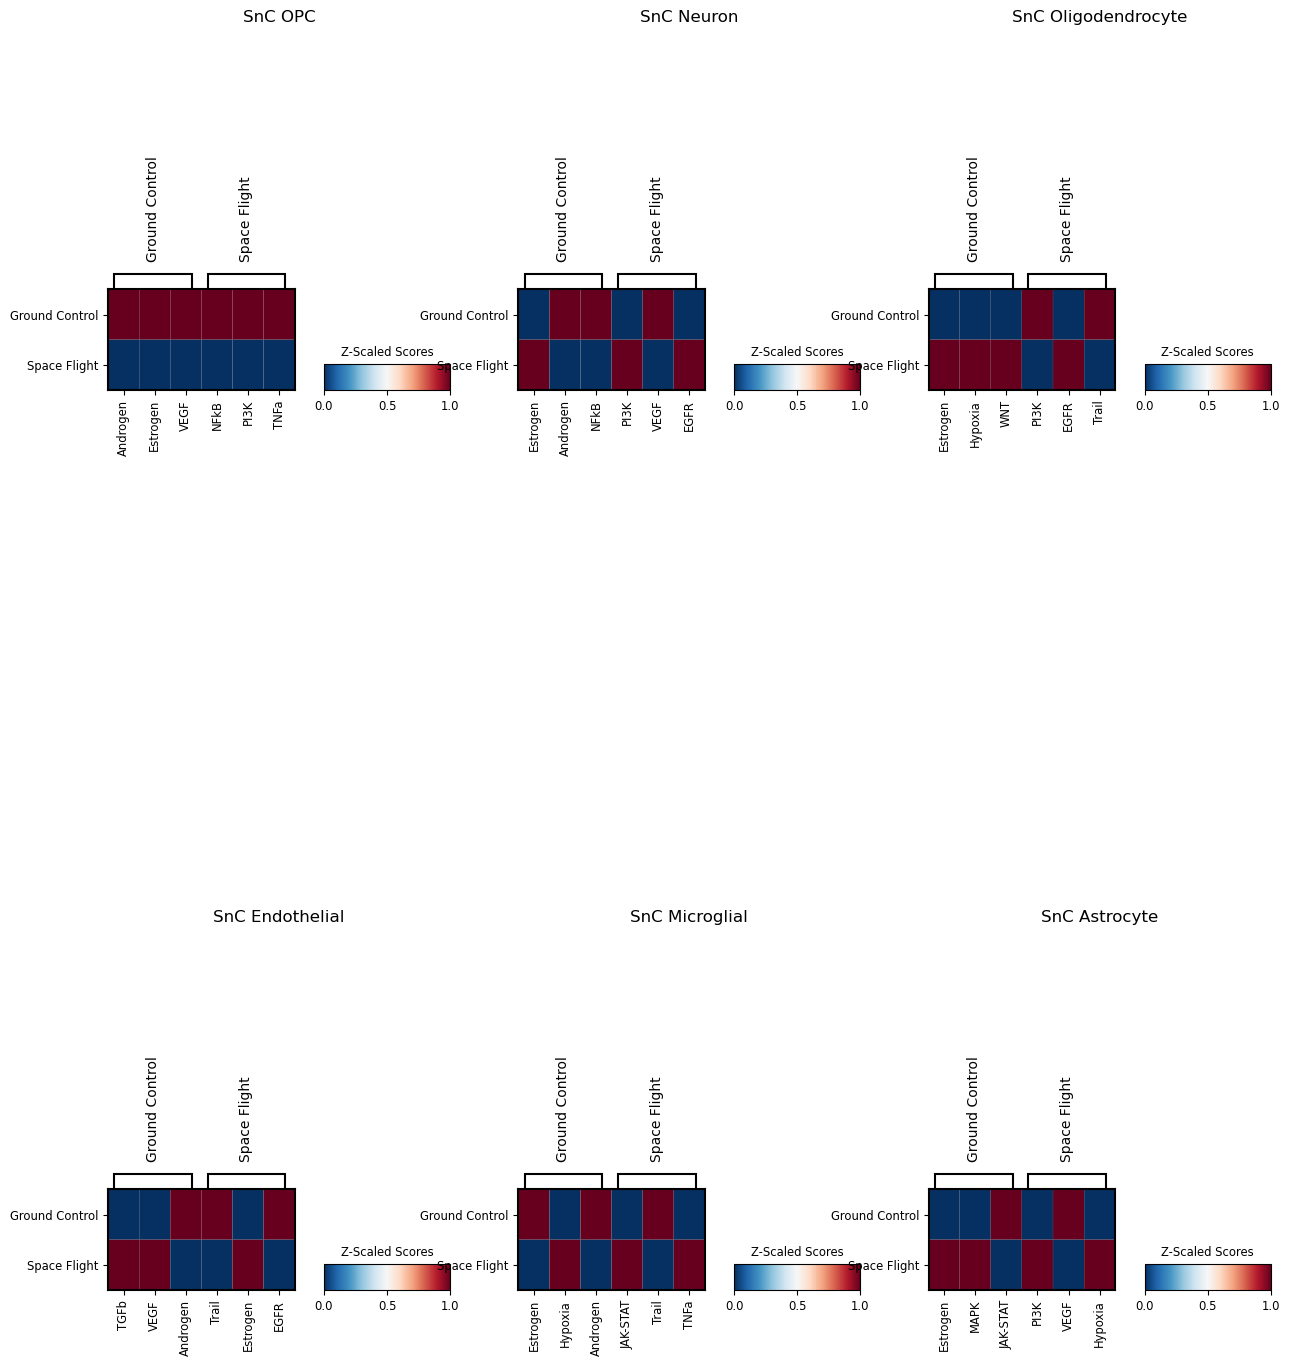

In [ ]:
res_dc_ulm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="progeny",
        hspace=0.5, wspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_scores = pd.concat([res_dc_ulm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm[0]],
                              keys=res_dc_ulm[0], names=[col_celltype])
res_dc_ulm_pathways = pd.concat([pd.Series(res_dc_ulm[0][x][2])
                                 for x in res_dc_ulm[0]], keys=res_dc_ulm[0])
print(res_dc_ulm_pathways)
res_dc_ulm_scores

#### Pathway Set = Hallmark

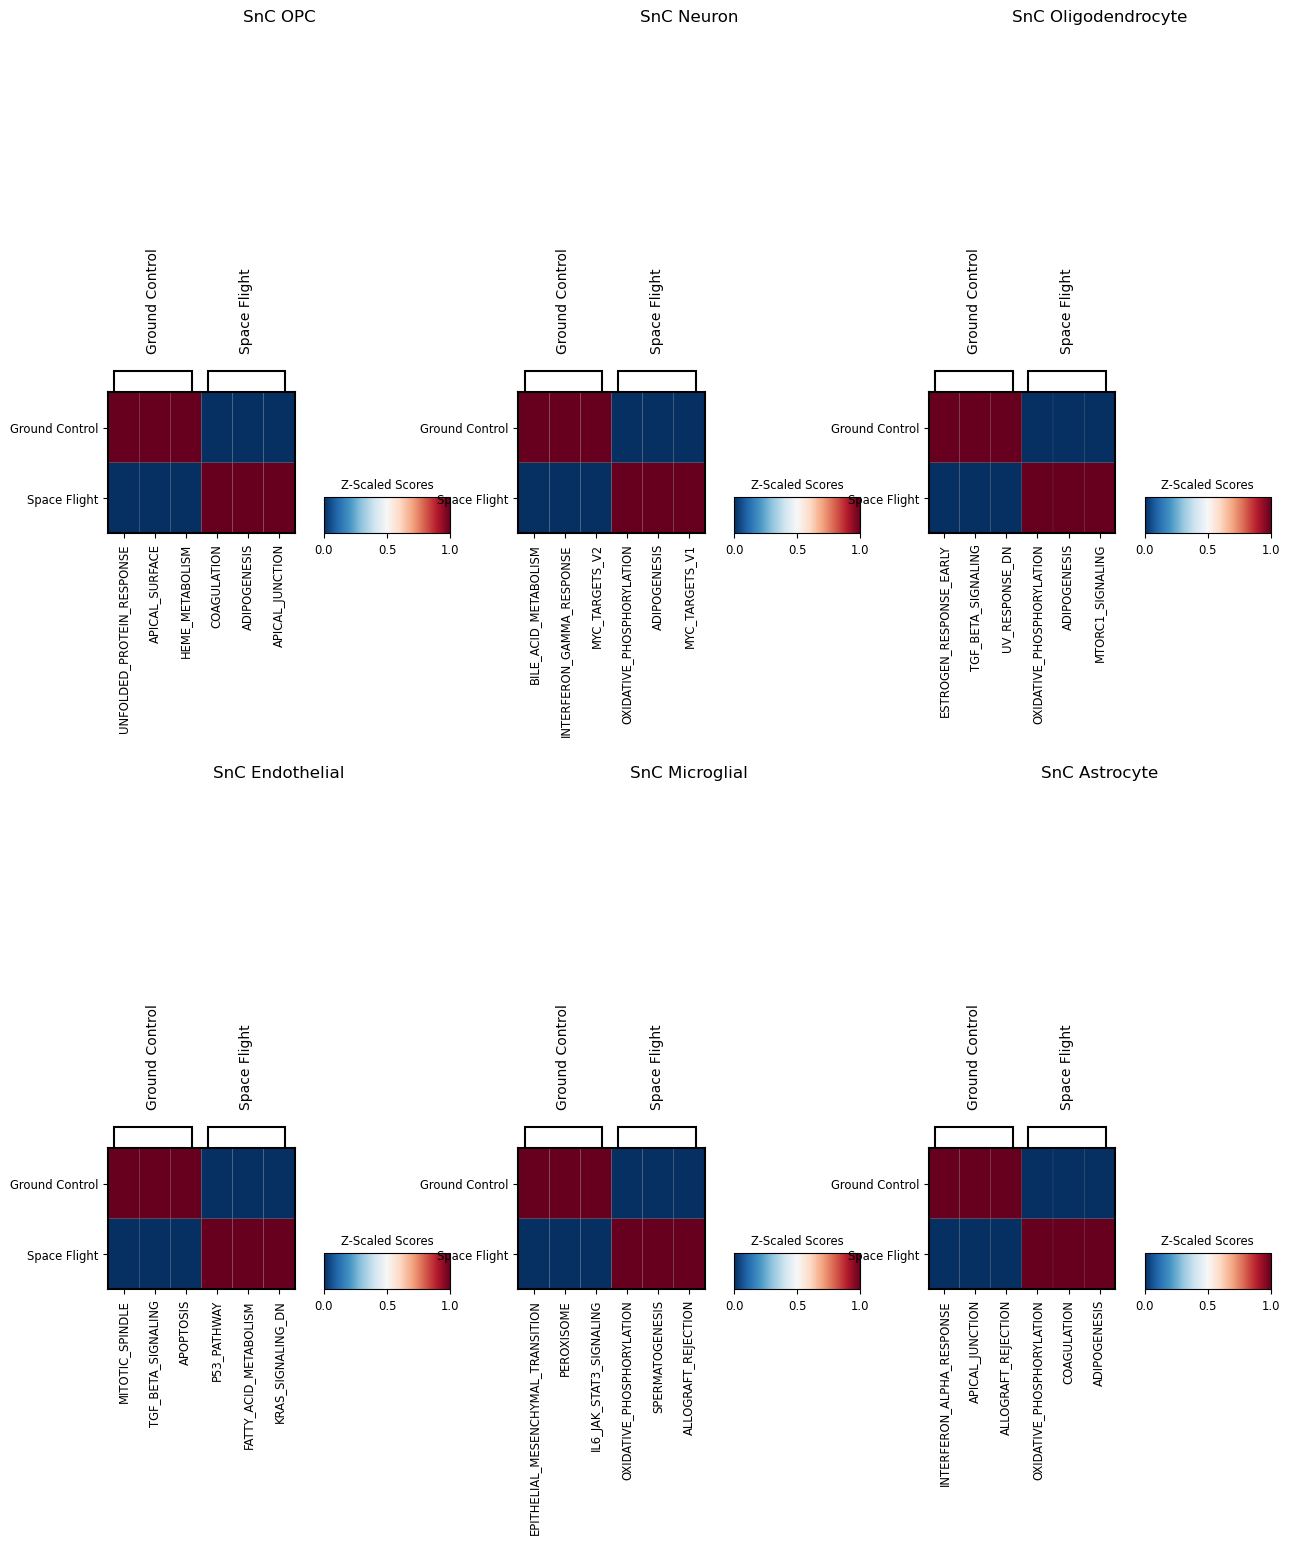

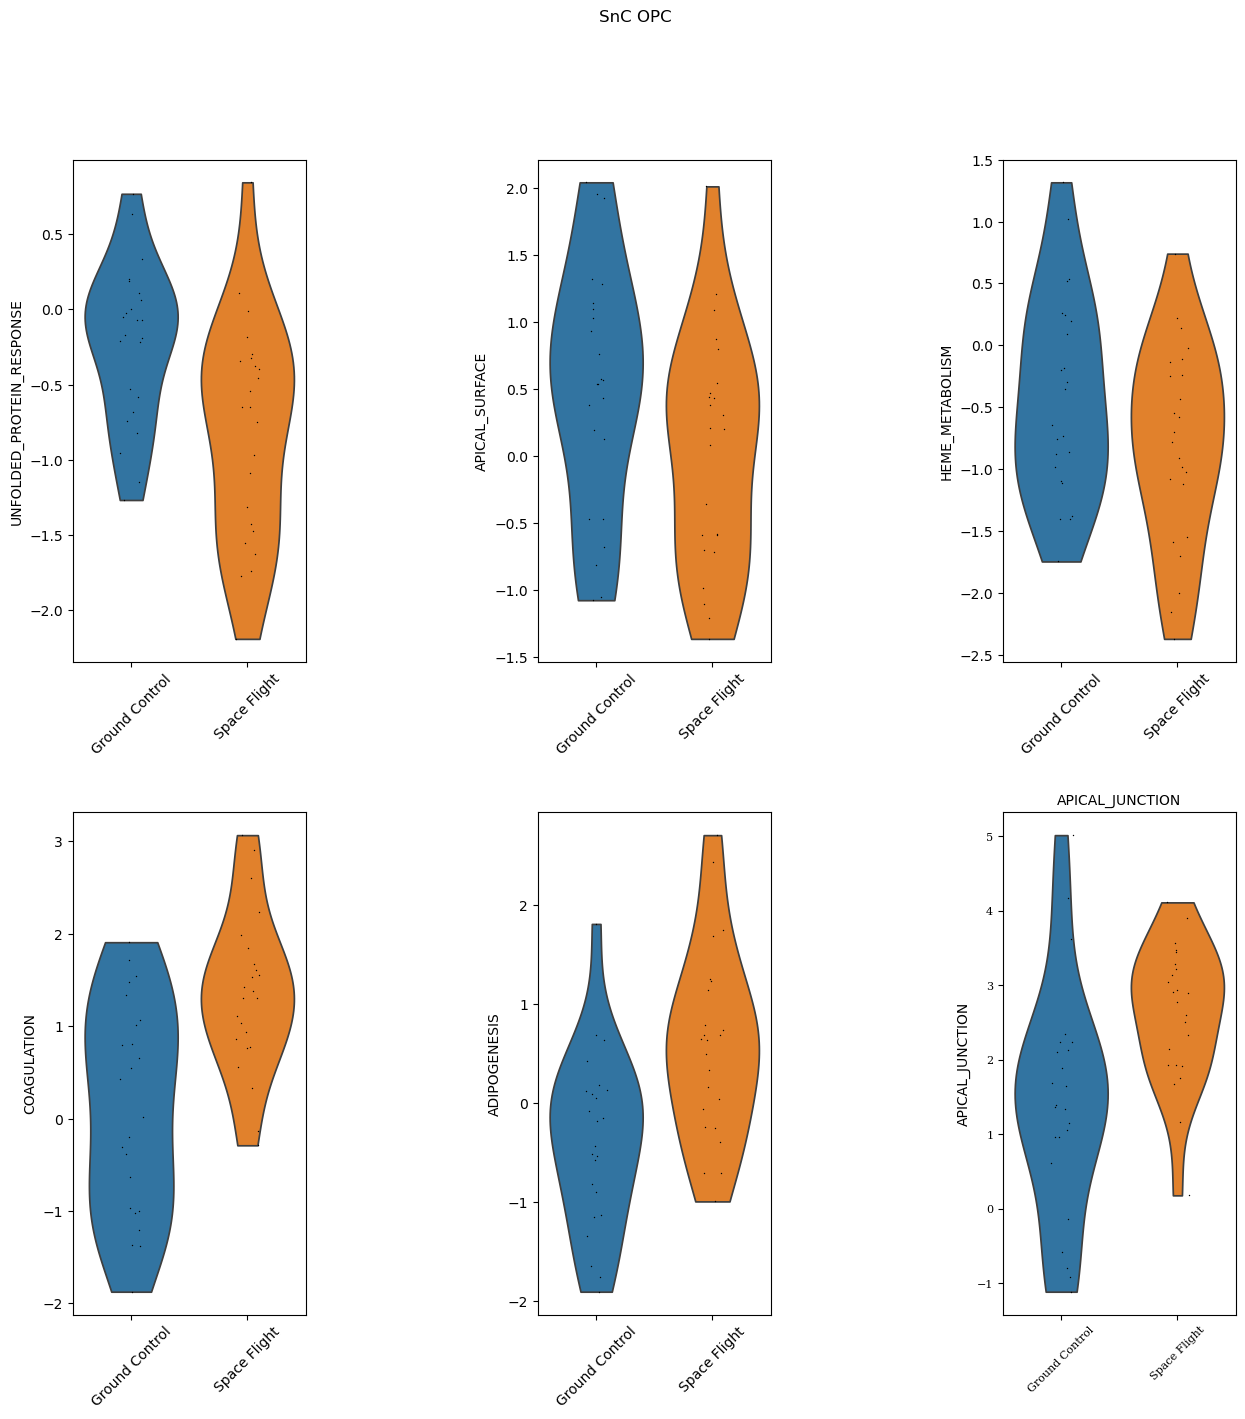

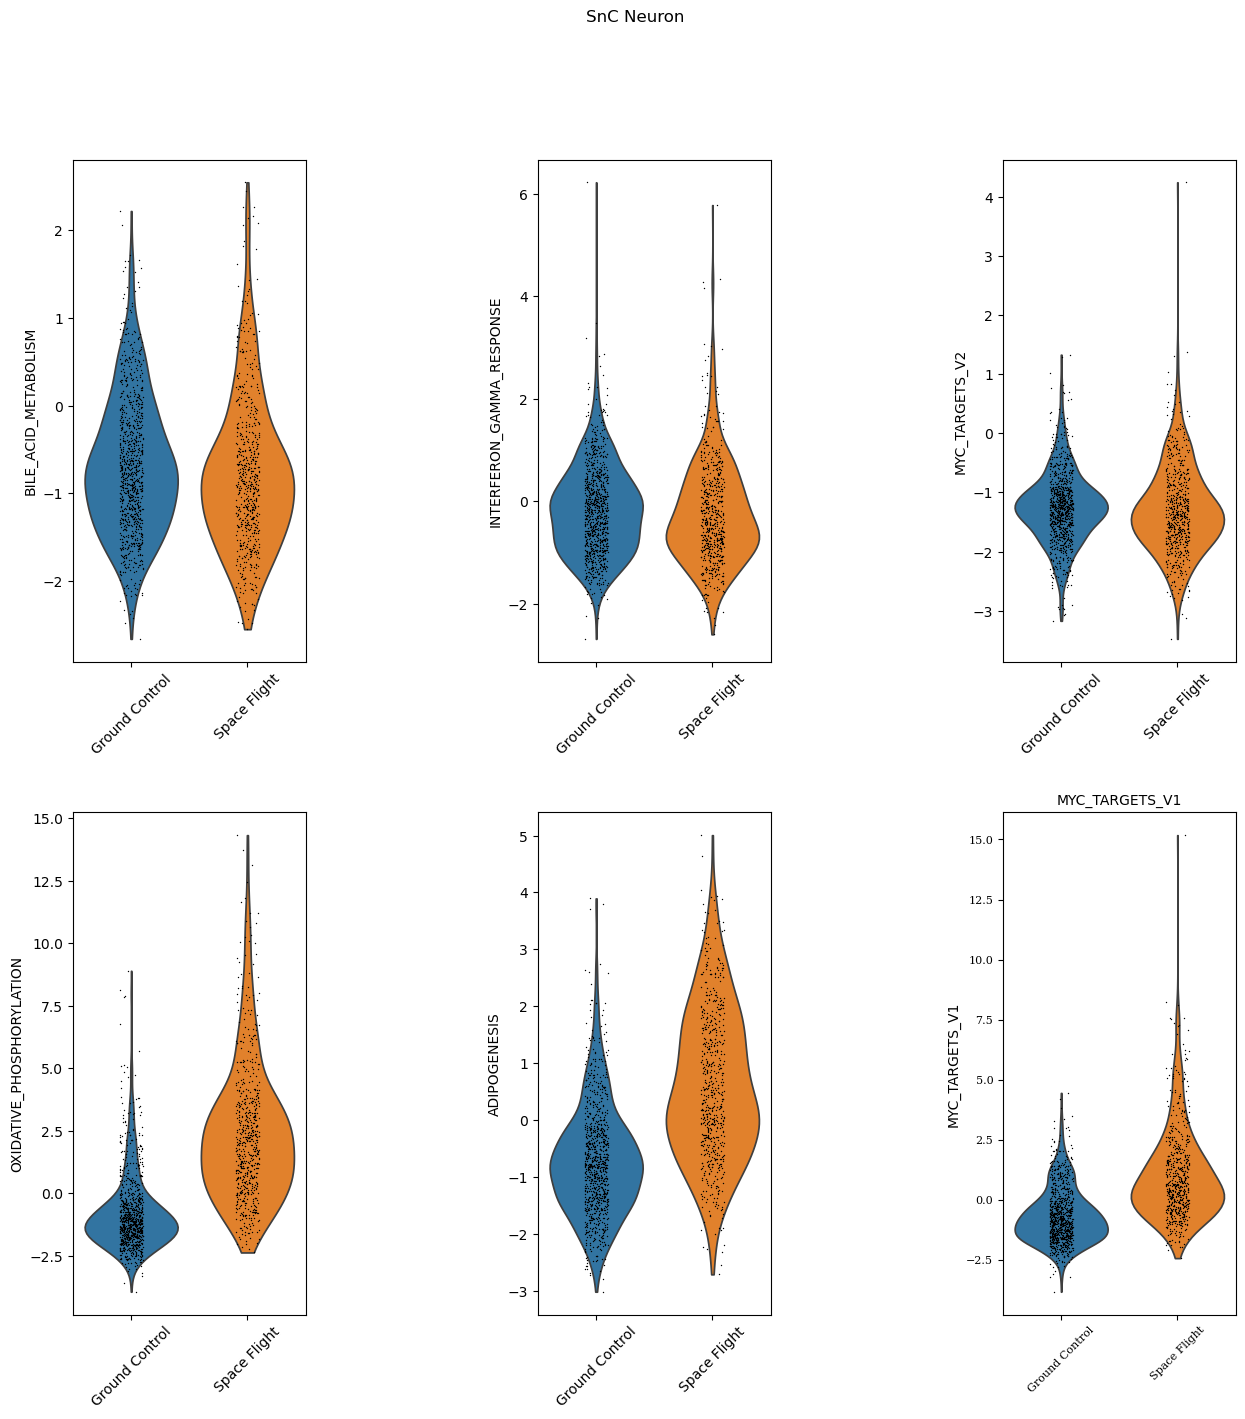

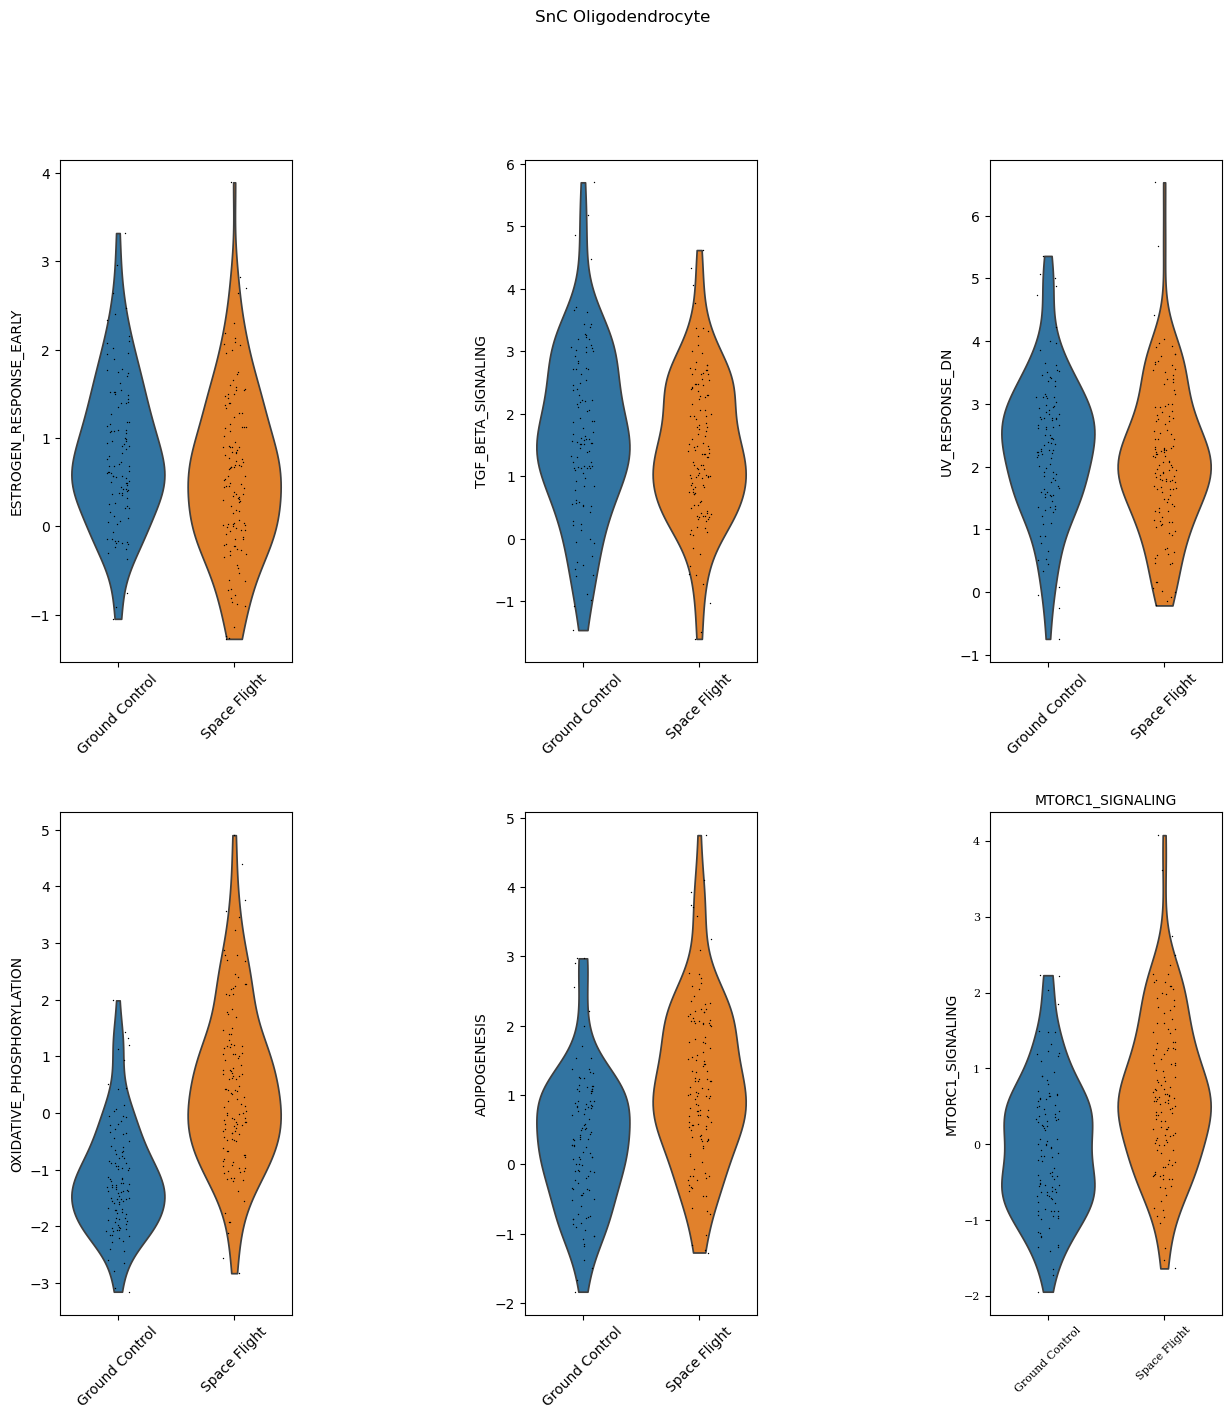

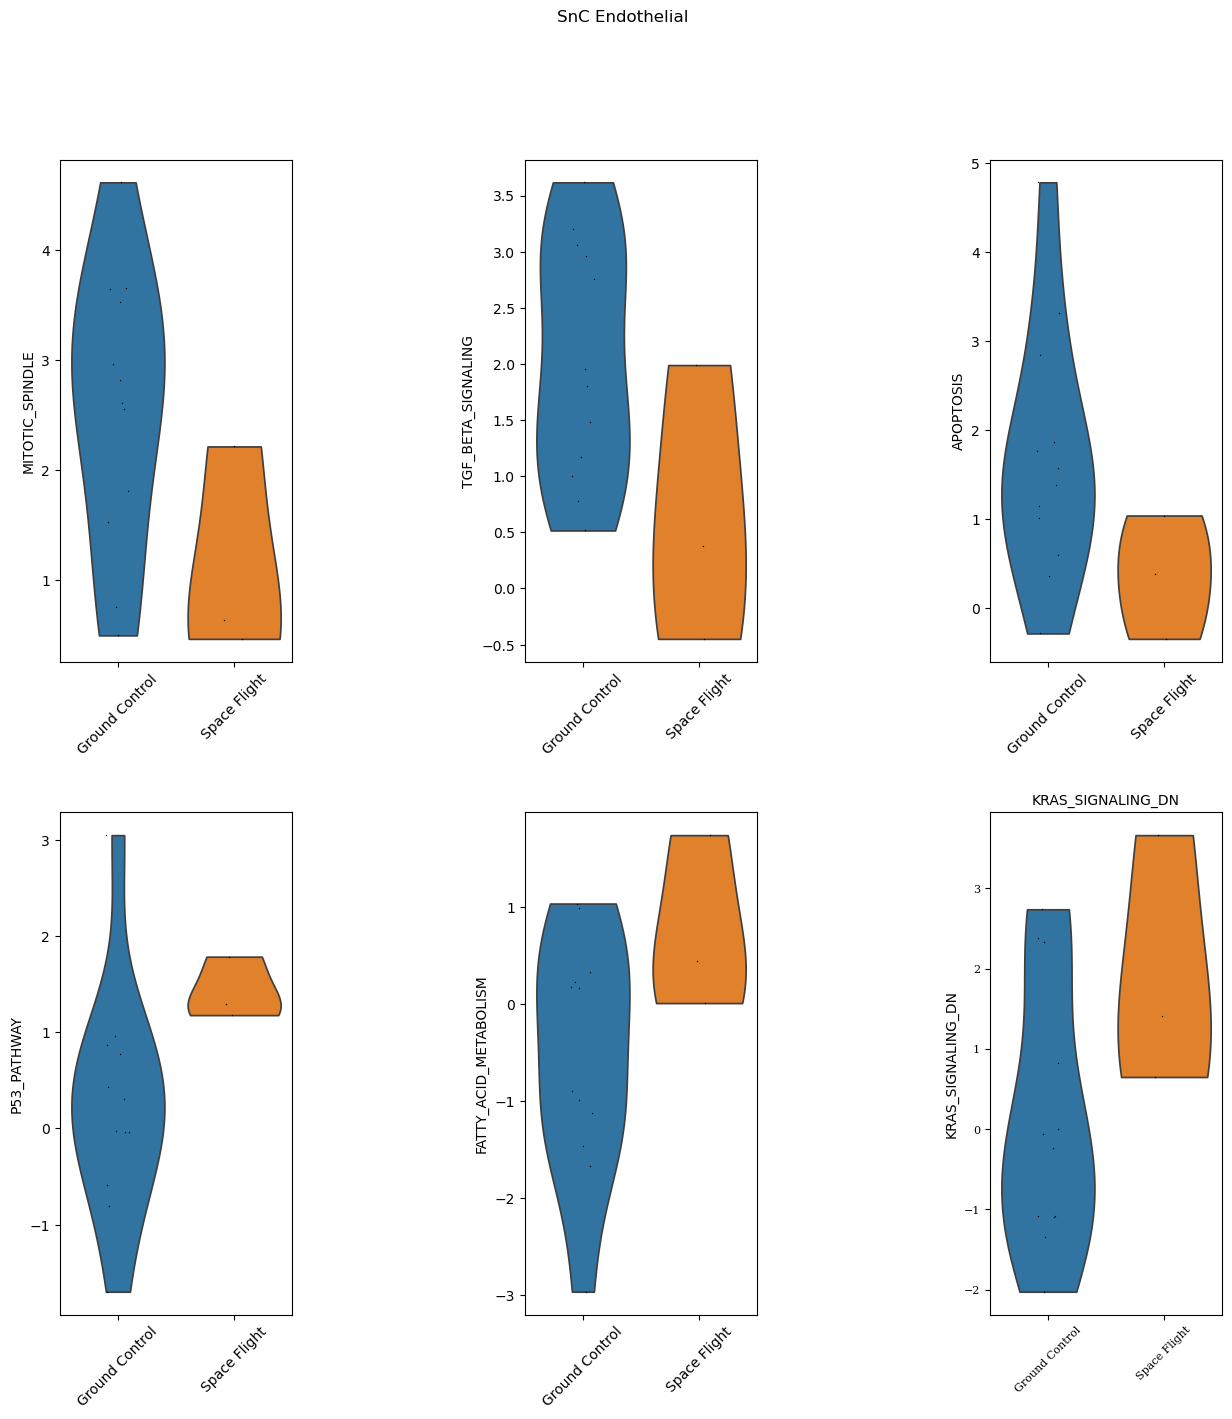

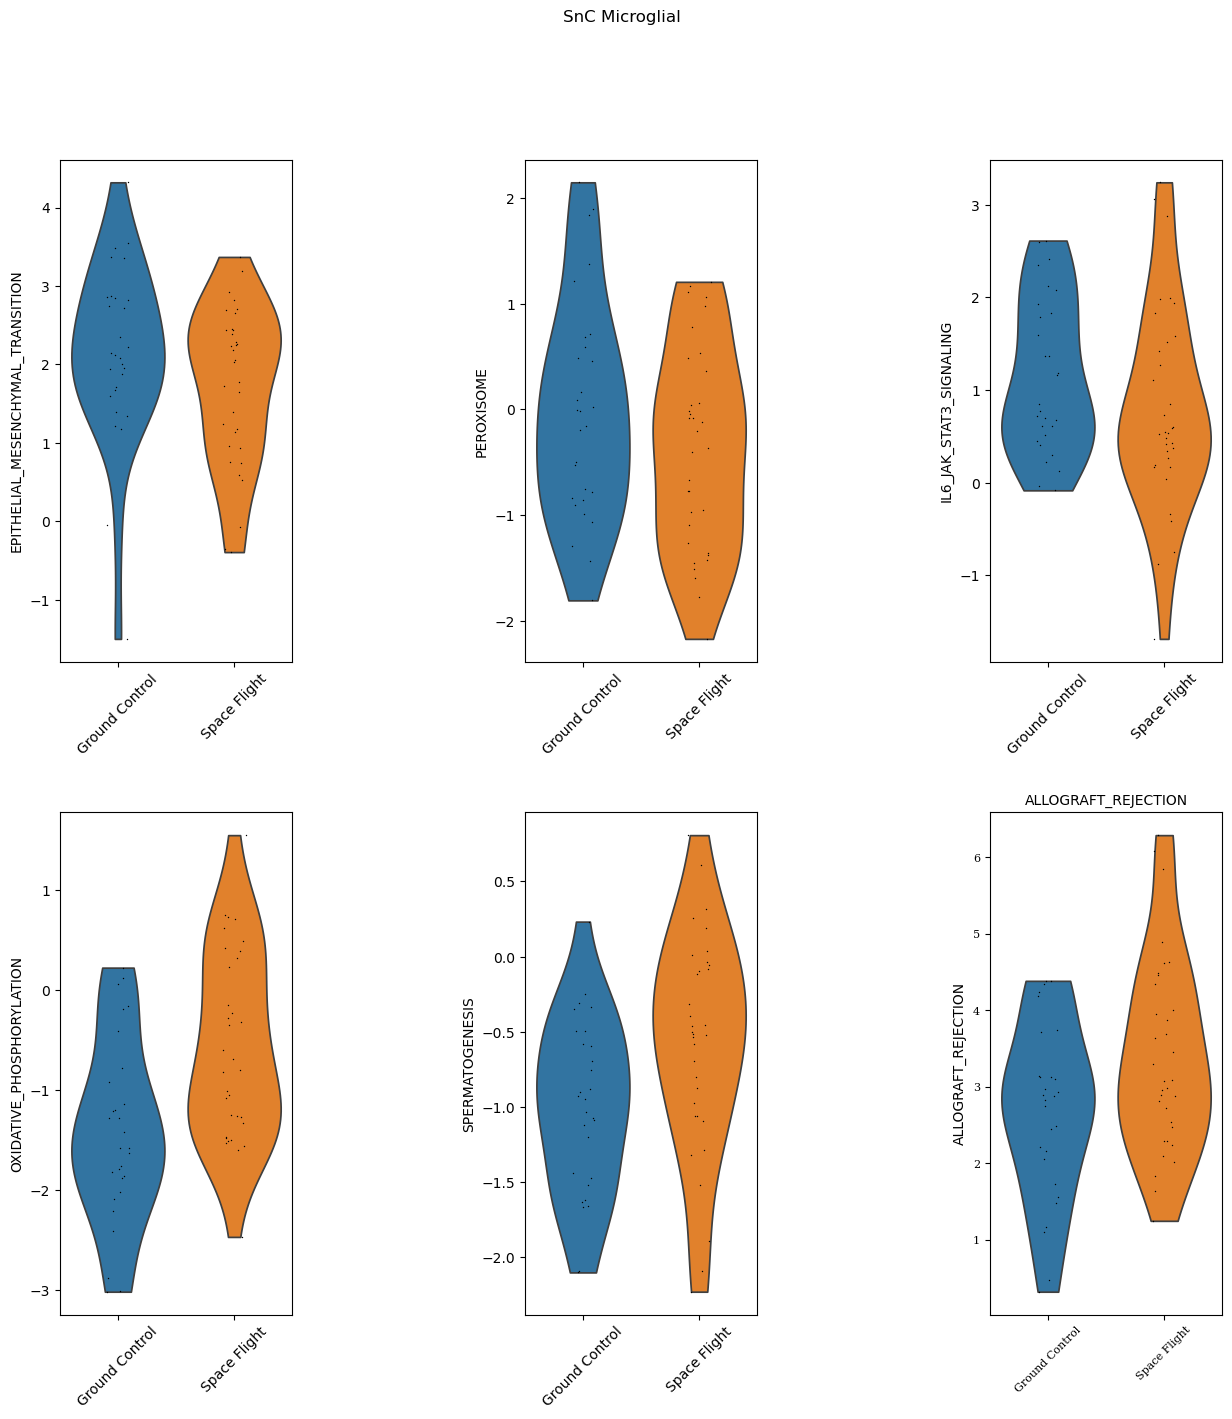

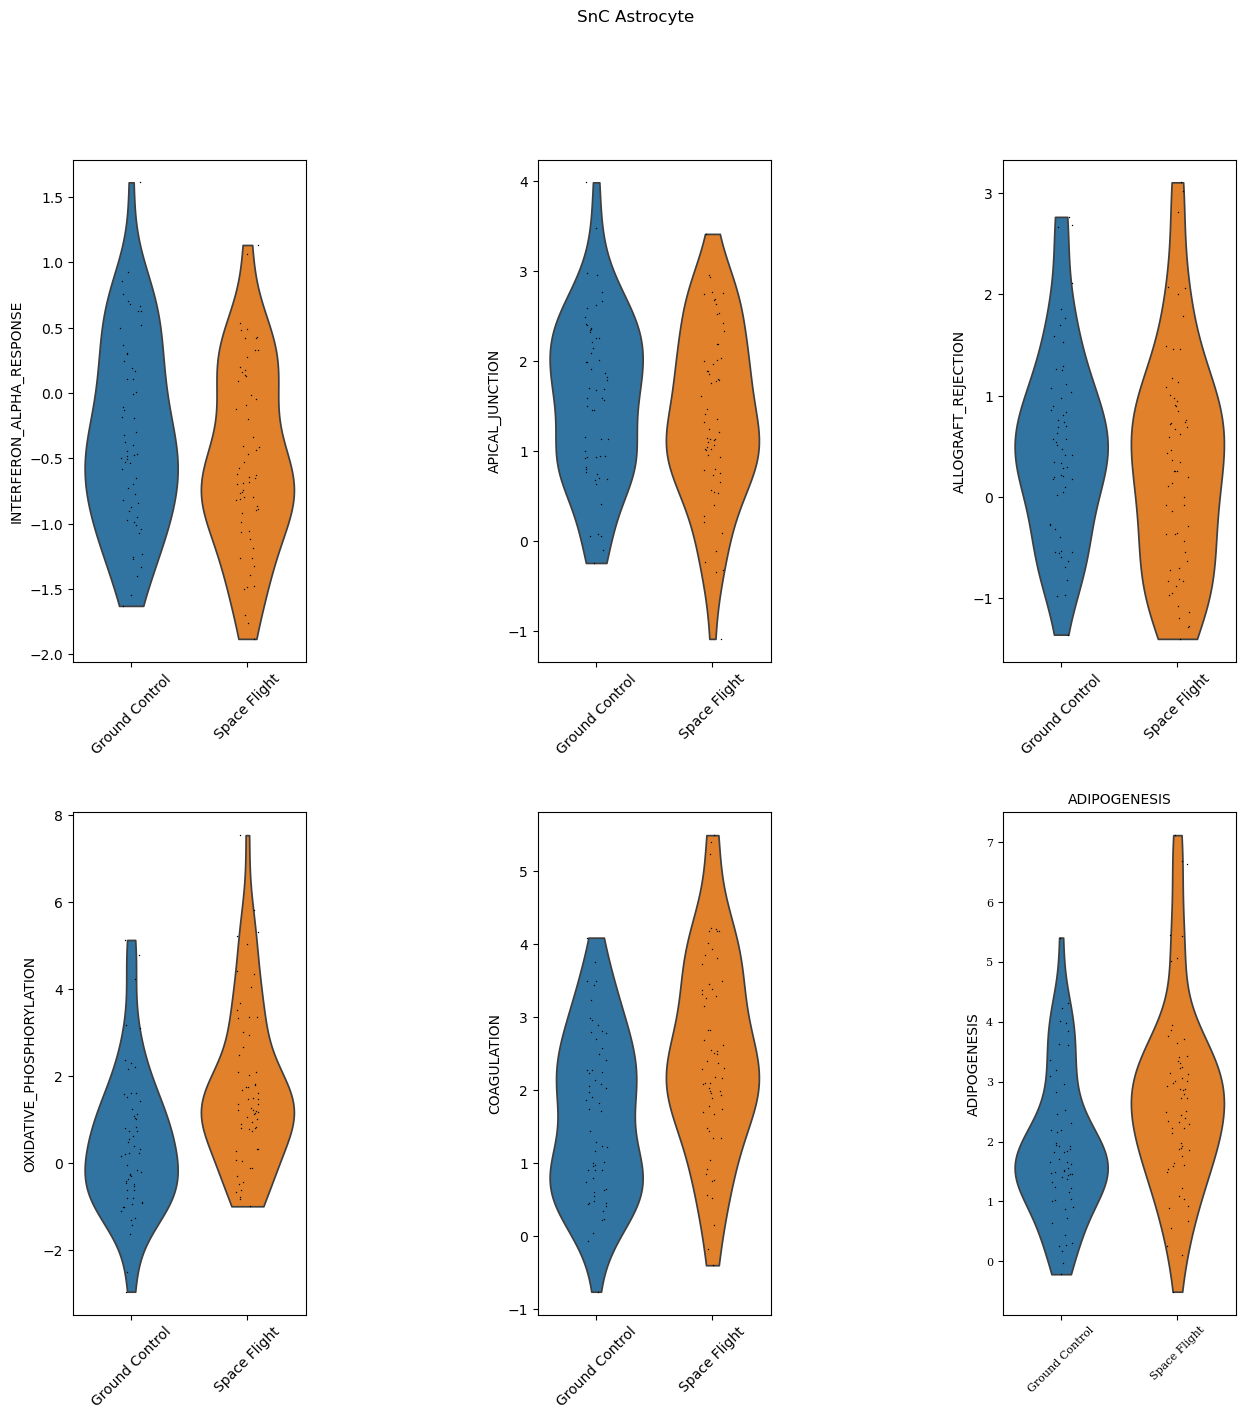

reference       stat  meanchange           pval           padj
annotation_scanvi_collapsed Condition      name                                                                                            
SnC OPC                     Ground Control UNFOLDED_PROTEIN_RESPONSE              rest   3.148356    0.573193   3.024018e-03   2.520015e-02
                                           APICAL_SURFACE                         rest   1.860512    0.476689   6.923833e-02   2.663013e-01
                                           HEME_METABOLISM                        rest   1.675026    0.389181   1.007165e-01   3.043063e-01
                                           ESTROGEN_RESPONSE_EARLY                rest   1.603981    0.395632   1.156364e-01   3.043063e-01
                                           BILE_ACID_METABOLISM                   rest   1.409833    0.305282   1.653179e-01   3.757224e-01
                                           PROTEIN_SECRETION                      rest   1.291372    0.465757   2.046302e-01   3.818708e-01
                                           ESTROGEN_RESPONSE_LATE                 rest   1.000520    0.274508   3.225932e-01   5.376553e-01
                                           MITOTIC_SPINDLE                        rest   0.843344    0.305709   4.034980e-01   6.304656e-01
                                           DNA_REPAIR                             rest   0.779627    0.166768   4.396200e-01   6.554873e-01
                                           ANDROGEN_RESPONSE                      rest   0.747198    0.218936   4.588411e-01   6.554873e-01
                                           MYC_TARGETS_V2                         rest   0.658130    0.143188   5.137388e-01   7.135262e-01
                                           PEROXISOME                             rest   0.619365    0.167230   5.387650e-01   7.280608e-01
                                           WNT_BETA_CATENIN_SIGNALING             rest   0.227567    0.057822   8.209931e-01   9.331232e-01
                                           APOPTOSIS                              rest   0.203285    0.045779   8.398109e-01   9.331232e-01
                                           SPERMATOGENESIS                        rest   0.151917    0.043679   8.799167e-01   9.360816e-01
                                           INTERFERON_GAMMA_RESPONSE              rest   0.060790    0.012859   9.517954e-01   9.914535e-01
                            Space Flight   COAGULATION                            rest   4.250807    1.224458   1.137765e-04   5.688826e-03
                                           ADIPOGENESIS                           rest   3.642291    0.960716   6.879389e-04   1.719847e-02
                                           APICAL_JUNCTION                        rest   3.270742    1.186918   2.297720e-03   2.520015e-02
                                           MYOGENESIS                             rest   3.192599    0.861542   2.743790e-03   2.520015e-02
                                           OXIDATIVE_PHOSPHORYLATION              rest   3.166107    1.168319   2.837315e-03   2.520015e-02
                                           TNFA_SIGNALING_VIA_NFKB                rest   2.968633    0.852557   4.833602e-03   3.452573e-02
                                           INFLAMMATORY_RESPONSE                  rest   2.863359    0.876734   6.539631e-03   4.087270e-02
                                           KRAS_SIGNALING_DN                      rest   2.723633    0.883038   9.217372e-03   4.762634e-02
                                           EPITHELIAL_MESENCHYMAL_TRANSITION      rest   2.748511    1.207515   9.525267e-03   4.762634e-02
                                           COMPLEMENT                             rest   2.267542    0.770072   2.883656e-02   1.310753e-01
                                           MTORC1_SIGNALING                       rest   1.991202    0.559144   5.243595e-02   2.184831e-01
                 

In [177]:
res_dc_ulm_hm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="hallmark",
        hspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_hm_scores = pd.concat([res_dc_ulm_hm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm_hm[0]],
                                 keys=res_dc_ulm_hm[0], names=[col_celltype])
res_dc_ulm_hm_scores

### Individual Cell Scores

In [ ]:
res_aucell = scflow.ax.run_decoupler_aucell(
    self.rna, col_covariates=["Senescent_Cell_Label_by_Type", col_condition],
    resource="progeny", species=species, inplace=True)
_ = self.plot(genes=list(self.rna.obsm["score_aucell"].columns),
              subset=self.rna.obs["Senescent_Cell"],
              col_celltype=col_condition, kind="violin",
              by_group="Senescent_Cell_Label_by_Type", figsize=(15, 15))

#### DEGs (`find_markers`) by Group

In [ ]:
out_pathway_snc_degs = scflow.ax.run_enrichr(
    df_snc_markers_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")
out_pathway_snc_degs_gc = scflow.ax.run_enrichr(
    df_snc_markers_top_gc, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_control"])
out_pathway_snc_degs_sf = scflow.ax.run_enrichr(
    df_snc_markers_top_sf, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_treatment"])
# out_pathway_snc_degs[1].drop("All", level=0)

#### Edger Contrasts (Pseudo-Bulk)

In [ ]:
# GSEA
print("\n\nGSEA Enrichment Analysis\n\n")
out_pathway_snc_degs = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=col_celltype,
    gene_sets=gene_sets, fx_replace_string=fx_replace_string)

# ToppGene
print("\n\nToppGene Enrichment Analysis\n\n")
mks_ctrsts_snc = dict(out_edgr_contrasts_snc_all_top.reset_index(
    1).variable.groupby(col_celltype).apply(lambda x: list(x)))  # SnC DEGs
results_toppgene_degs = scflow.pp.annotate_by_toppgene(
    mks_ctrsts_snc, species=species, min_genes=1,
    categories=["Pathway", "PubMed"])
results_toppgene_degs = results_toppgene_degs.join(pd.Series(
    mks_ctrsts_snc).to_frame("DEGs").rename_axis("Gene Set"))
results_toppgene_degs = results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: x.sort_values("PValue", ascending=True), include_groups=False)
pthwys = dict(results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: [i.capitalize() for i in x.Name.unique()]))
print("\n\n".join([f"{k}: {pthwys[k]}" for k in pthwys]))
results_toppgene_degs[["Name", "Symbols", "GenesInTerm", "GenesInQuery",
                       "GenesInTermInQuery", "PValue"]].reset_index(
                           2, drop=True)

## Plot

In [ ]:
# Top 10 Senescence Genes or All?
ggg = top_genes
# ggg = genes

# Mask for High Senescence Subset & Helper Variable for Figure Dimensions
subset = self.rna.obs["Senescent_Cell"].isin([1, True])
num_cts = len(self.rna[subset].obs[col_celltype].unique())

# Plot SnC Markers Overlap with Marker Sets
sc.pl.violin(self.rna[subset], set(genes).intersection(
    marker_gene_sets.explode().unique()),
             groupby=col_batch, rotation=90)  # plot overlap w/ SnC markers

# Plot Most Highly-Expressed Genes in Each Senescent Cell Type
_ = self.plot(kind=["matrix", "heat"], genes=top_genes,
              col_celltype=col_celltype, layer="log1p",
              subset=subset, dendrogram=True, swap_axes=False, heat=dict(
                  dendrogram=False), standard_scale="var",
              figsize=(len(top_genes) / 1.5, num_cts * 1.5))

# Grouped by Top Cell Types
_ = self.plot(kind=["matrix", "heat"], genes=top_genes_dict,
              standard_scale="obs", col_celltype=col_celltype,
              layer="log1p", swap_axes=False, figsize=(len(ggg), num_cts),
              subset=subset, dendrogram=True)

# Write Object

In [185]:
# Send Email with Output When Done
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

if overwrite is True or os.path.exists() is False:
    self.rna.write_h5ad(file_path_new)
else:
    print(f"\n\n\n{'=' * 120}\nOVERWRITE IS FALSE..."
          f"NOT WRITING OBJECT!!!\n{'=' * 120}\n\n\n")

[NbConvertApp] Converting notebook /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/analyze_senescence_celltype_specific_threshold.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 65 image(s).
[NbConvertApp] Writing 8121647 bytes to /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/analyze_senescence_celltype_specific_threshold.html
Authenticating (PLAIN)...
Closing connection to imap.gmail.com...


# SCRATCH

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()
df_degs = df_snc_markers.drop("All").reset_index(0, drop=True)

factor_name = col_celltype
# factor_name = col_condition

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

# factor_name = col_celltype
# factor_name = col_condition
factor_name = col_batch

df_degs = res_rank_genes_top.loc[:, "Overall", :]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs",
             fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 2
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 1
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]